In [52]:
#######################
### LOAD IN MODULES ###
#######################

import cv2 # to install on mac: pip install opencv-python
from scipy.interpolate import interp1d # for interpolating points
from sklearn.decomposition import PCA # for principal component analysis
from scipy.spatial import procrustes # for Procrustes analysis
from scipy.spatial import ConvexHull # for convex hull
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # for LDA
from sklearn.metrics import confusion_matrix # for confusion matrix
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
import matplotlib.pyplot as plt # for plotting
import numpy as np # for using arrays
import math # for mathematical operations
import pandas as pd # for using pandas dataframes
import seaborn as sns # for plotting in seaborn
from matplotlib.colors import LogNorm
from sklearn.model_selection import StratifiedKFold
import itertools # for pairwise combinations
import scipy.stats as stats # for kruskal wallis test
import statsmodels.stats.multitest as multitest # multiple test adjustment

In [53]:
#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean

def polygon_perimeter(vertices):
    # Ensure the polygon is closed: append the first point to the end
    closed_vertices = np.vstack([vertices, vertices[0]])
    # Compute pairwise distances
    diffs = np.diff(closed_vertices, axis=0)
    segment_lengths = np.linalg.norm(diffs, axis=1)
    return segment_lengths.sum()


# Read in data

In [54]:
########################
### READ IN METADATA ###
########################

mdata = pd.read_csv("./metadata_v5.csv") # read in csv

mdata.head() # head data to check

# drop any row with NaN
mdata = mdata.dropna().reset_index(drop=True)

# drop rows with "r" for node value
#mdata = mdata[mdata['node'] != "r"].reset_index(drop=True)

# replace species mis-spellings
mdata['species'] = mdata['species'].replace({'apalacnicolensis': 'apalachicolensis'}) 
mdata['species'] = mdata['species'].replace({'canybi': 'canbyi'}) 

# make sure variables are floats
#mdata["node"] = mdata["node"].astype(float)
#mdata["count"] = mdata["count"].astype(float)
mdata['px_cm'] = mdata['px_cm'].astype(float)


In [55]:
#######################################
### MAKE A LIST OF IMAGE FILE NAMES ###
#######################################

data_dir = "./binary_leaves_v5/" # set data directory

file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names

if '.DS_Store' in file_names:
    file_names.remove('.DS_Store') # remove .DS_Store file

file_names.sort() # sort the list of file names

file_names # check list of file names

['LAMOEWC23246-1_10_13.tif',
 'LAMOEWC23246-1_11_13.tif',
 'LAMOEWC23246-1_12_13.tif',
 'LAMOEWC23246-1_13_13.tif',
 'LAMOEWC23246-1_1_13.tif',
 'LAMOEWC23246-1_2_13.tif',
 'LAMOEWC23246-1_3_13.tif',
 'LAMOEWC23246-1_4_13.tif',
 'LAMOEWC23246-1_5_13.tif',
 'LAMOEWC23246-1_6_13.tif',
 'LAMOEWC23246-1_7_13.tif',
 'LAMOEWC23246-1_8_13.tif',
 'LAMOEWC23246-1_9_13.tif',
 'LAMOEWC23246-2_1_5.tif',
 'LAMOEWC23246-2_2_5.tif',
 'LAMOEWC23246-2_3_5.tif',
 'LAMOEWC23246-2_4_5.tif',
 'LAMOEWC23246-2_5_5.tif',
 'LAPALBS17132-1_10_28.tif',
 'LAPALBS17132-1_11_28.tif',
 'LAPALBS17132-1_12_28.tif',
 'LAPALBS17132-1_13_28.tif',
 'LAPALBS17132-1_14_28.tif',
 'LAPALBS17132-1_15_28.tif',
 'LAPALBS17132-1_16_28.tif',
 'LAPALBS17132-1_17_28.tif',
 'LAPALBS17132-1_18_28.tif',
 'LAPALBS17132-1_19_28.tif',
 'LAPALBS17132-1_1_28.tif',
 'LAPALBS17132-1_20_28.tif',
 'LAPALBS17132-1_21_28.tif',
 'LAPALBS17132-1_22_28.tif',
 'LAPALBS17132-1_23_28.tif',
 'LAPALBS17132-1_24_28.tif',
 'LAPALBS17132-1_25_28.tif',
 'LAP

# Process and landmark data

- Read in image in grayscale
- Select the contour of the largest object (the leaf)
- Interpolate with a high resolution of pseudo-landmarks
- Find the base and tip index point on the high resolution contour
- Reset the base index to zero
- Interpolate each side with desired number of equidistant pseudo-landmarks
- Rotate leaves and scale to centimeters
- Save pseudo-landmarks scaled to centimeters in an array

PARAMETERS AND INDEXING:
- `high_res_pts` is an arbitrarily high number of points to initially interpolate
- `res` is the desired number of points to interpolate on each side of the leaf
- The total number of pseudo-landmarks will be `2*res - 1`
- The base index will be `0`
- The tip index will be `res-1`
- The returned leaves in `cm_arr` are scaled in size to centimeters

First, find excluded and missing leaves where the metadata file name is not found in the binary files

In [56]:
exclude_leaves = [] # leaf names to exclude
exclude_inds = [] # indices of leaf names to exclude

missing_leaves = [] # metadata leaf name not in files
missing_inds = [] # indices of metadata leaf names not in files

# for each leaf . . .
for lf in range(len(mdata)):
    if mdata["include"][lf]=="N":
        exclude_leaves.append(mdata["file"][lf])
        exclude_inds.append(lf)

    elif mdata["file"][lf]+".tif" not in file_names:
        missing_leaves.append(mdata["file"][lf])
        missing_inds.append(lf)
        
print("There are", len(exclude_inds), "excluded leaves")
print("There are", len(missing_inds), "missing leaves")

# save the missing leaves
file_path = "missing_leaves.txt"
with open(file_path, 'w') as file:
    for item in missing_leaves:
        file.write(item + '\n')


There are 939 excluded leaves
There are 1 missing leaves


In [57]:
# which image files not in metadata?
# AFTER METADATA PROCESSED

meta_data_files = mdata["file"].to_list()
missing_metadata_files = []
for file in file_names:
    if file[:-4] not in meta_data_files:
        missing_metadata_files.append(file)

# save the missing leaves
file_path = "missing_leaves_in_metadata_AFTER_PROCESSING.txt"
with open(file_path, 'w') as file:
    for item in missing_metadata_files:
        file.write(item + '\n')

len(missing_metadata_files)


8

**NOTE: REMEMBER TO UNCOMMENT IF NEEDED**

In [58]:
# which image files not in metadata?
# BEFORE METADATA PROCESSED

#mdata = pd.read_csv("./metadata_v5.csv") # read in csv

meta_data_files = mdata["file"].to_list()
missing_metadata_files = []
for file in file_names:
    if file[:-4] not in meta_data_files:
        missing_metadata_files.append(file)

# save the missing leaves
file_path = "missing_leaves_in_metadata_BEFORE_PROCESSING.txt"
with open(file_path, 'w') as file:
    for item in missing_metadata_files:
        file.write(item + '\n')

len(missing_metadata_files)

8

Next, remove the indices of excluded or missing leaves before analysis

**NOTE: EXCLUDE INDICES ARE COMMENTED OUT**

In [59]:
remove_inds = missing_inds #+ exclude_inds # create list of indices to remove from mdata

mdata = mdata.drop(remove_inds, axis=0)

mdata = mdata.reset_index(drop=True) # Reset the index

print(len(mdata), "leaves will be analyzed") # how many leaves are being analyzed?

4086 leaves will be analyzed


In [60]:
######################
### SET PARAMETERS ###
######################

# the number of equidistant points to create
# an initial high resolution outline of the leaf
high_res_pts = 10000

# the ultimate number of equidistant points on each side of the leaf
# (-1 for the tip)
# the leaf will have res*2-1 pseudo-landmarks
#################
#################
#################
res = 50 ########
#################
#################
#################

# an array to store pseudo-landmarks
cm_arr = np.zeros((len(mdata),(res*2)-1,2))

# for each leaf . . .
for lf in range(len(mdata)):

    ###############################
    ### READ IN GRAYSCALE IMAGE ###
    ###############################

    curr_image = mdata["file"][lf]+".tif" # select the current image

    #if mdata["include"][lf]=="N":
    #    continue

    print(lf, curr_image) # print each leaf in case there are problems later

    # read in image
    # convert to grayscale
    # invert the binary
    img = cv2.bitwise_not(cv2.cvtColor(cv2.imread(data_dir + curr_image),cv2.COLOR_BGR2GRAY))

    # find contours of binary objects
    contours, hierarchy = cv2.findContours(img,  
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ##############################
    ### SELECT LARGEST CONTOUR ###
    ##############################

    # ideally there is only one leaf in the image
    # in the case there are smaller objects
    # this code selects the largest object (the leaf)
    # if there is one and only one object in the image
    # then the following code is not necessary

    x_conts = [] # list of lists of contour x vals
    y_conts = [] # list of lists of contour y vals
    areas_conts = [] # list of bounding box areas of contours
    for c in contours: # for each contour
        x_vals = [] # store x vals for current contour 
        y_vals = [] # store y vals for current contour
        for i in range(len(c)): # for each point in current contour
            x_vals.append(c[i][0][0]) # isolate x val
            y_vals.append(c[i][0][1]) # isolate y val
        area = (max(x_vals) - min(x_vals))*(max(y_vals) - min(y_vals)) # calculate bounding box area of contour
        x_conts.append(x_vals) # append the current contour x vals
        y_conts.append(y_vals) # append the current contour y vals
        areas_conts.append(area) # append the current contour bounding box areas

    area_inds = np.flip(np.argsort(areas_conts)) # get indices to sort contours by area
    sorted_x_conts = np.array(x_conts, dtype=object)[area_inds][0:] # areas sorted largest to smallest, x vals
    sorted_y_conts = np.array(y_conts, dtype=object)[area_inds][0:] # areas sorted largest to smallest, y vals

    ################################################
    ### INTERPOLATE HIGH RES NUMBER OF LANDMARKS ###
    ################################################

    # convert the leaf to high resolution number of landmarks
    # using high_res_pt value
    # need to convert arrays of pixel int to floats first
    high_res_x, high_res_y = interpolation(np.array(sorted_x_conts[0], dtype=np.float32), 
                                           np.array(sorted_y_conts[0], dtype=np.float32), high_res_pts)

    ###############################
    ### FIND BASE AND TIP INDEX ###
    ###############################

    # get the base and tip landmark point values
    base_pt = np.array((mdata["base_x"][lf], mdata["base_y"][lf]))
    tip_pt = np.array((mdata["tip_x"][lf], mdata["tip_y"][lf]))

    base_dists = [] # store distance of each high res point to base
    tip_dists = [] # store distance of each high res point to tip

    for pt in range(len(high_res_x)): # for each of the high resolution points

        # euclidean distance of the current point from the base and tip landmark
        ed_base = euclid_dist(base_pt[0], base_pt[1], high_res_x[pt], high_res_y[pt])
        ed_tip = euclid_dist(tip_pt[0], tip_pt[1], high_res_x[pt], high_res_y[pt])

        # store distance of current point from base/tip
        base_dists.append(ed_base)
        tip_dists.append(ed_tip)

    # get index of base and tip points
    base_ind = np.argmin(base_dists)
    tip_ind = np.argmin(tip_dists)

    ################################
    ### RESET BASE INDEX TO ZERO ###
    ################################

    # reset base index position to zero
    high_res_x = np.concatenate((high_res_x[base_ind:],high_res_x[:base_ind]))
    high_res_y = np.concatenate((high_res_y[base_ind:],high_res_y[:base_ind]))

    # recalculate indices with new indexing
    tip_ind = tip_ind-base_ind # note: negative index if tip_ind<base_ind
    base_ind = base_ind-base_ind

    # create single array for leaf coordinates
    lf_contour = np.column_stack((high_res_x, high_res_y))

    ##############################################################
    ### INTERPOLATE EACH SIDE WITH DESIRED NUMBER OF LANDMARKS ###
    ##############################################################

    # interpolate at desired resolution the left and right sides of the leaf
    left_inter_x, left_inter_y = interpolation(lf_contour[base_ind:tip_ind+1,0],lf_contour[base_ind:tip_ind+1,1],res)
    right_inter_x, right_inter_y = interpolation(lf_contour[tip_ind:,0],lf_contour[tip_ind:,1],res)

    # the start of the right side and end of the left side
    # both contain the tip landmark
    # delete the last point on the left side
    left_inter_x = np.delete(left_inter_x, -1)
    left_inter_y = np.delete(left_inter_y, -1)

    # BASE OF LEAF IS INDEX 0
    # TIP INDEX IS RES-1 IF BOTH LEFT & RIGHT POINTS
    # TOTAL PSEUDOLANDMARKS IS 2*RES-1
    lf_pts_left = np.column_stack((left_inter_x, left_inter_y))
    lf_pts_right = np.column_stack((right_inter_x, right_inter_y))
    lf_pts = np.row_stack((lf_pts_left, lf_pts_right))

    ##########################################################
    ### ROTATE LEAVES UPWARD AND SCALE SIZE TO CENTIMETERS ###
    ##########################################################

    tip_point = lf_pts[res-1,:] # get tip point
    base_point = lf_pts[0,:] # get base point

    # calculate angle between tip. base, and an arbitrary reference
    ang = angle_between(tip_point, base_point, (base_point[0]+1,base_point[1]) )

    # rotate points upwards
    rot_x, rot_y = rotate_points(lf_pts[:,0], lf_pts[:,1], ang) 
    rot_pts = np.column_stack((rot_x, rot_y))
    
    # calculate leaf area in pixels^2
    lf_area_px2 = poly_area(rot_pts[:,0], rot_pts[:,1])
    
    # get px_cm
    px_cm = mdata["px_cm"][lf]

    # scale leaf into cm
    cm_lf = rot_pts/(px_cm)
    
    # store the leaf scaled into cm into the cm_arr
    cm_arr[lf,:,:] = cm_lf


0 LAMOEWC23246-1_1_13.tif
1 LAMOEWC23246-1_10_13.tif
2 LAMOEWC23246-1_11_13.tif
3 LAMOEWC23246-1_12_13.tif
4 LAMOEWC23246-1_13_13.tif
5 LAMOEWC23246-1_2_13.tif
6 LAMOEWC23246-1_3_13.tif
7 LAMOEWC23246-1_4_13.tif
8 LAMOEWC23246-1_5_13.tif
9 LAMOEWC23246-1_6_13.tif
10 LAMOEWC23246-1_7_13.tif
11 LAMOEWC23246-1_8_13.tif
12 LAMOEWC23246-1_9_13.tif
13 LAMOEWC23246-2_1_5.tif
14 LAMOEWC23246-2_2_5.tif
15 LAMOEWC23246-2_3_5.tif
16 LAMOEWC23246-2_4_5.tif
17 LAMOEWC23246-2_5_5.tif
18 LAPALBS17132-1_1_28.tif
19 LAPALBS17132-1_10_28.tif
20 LAPALBS17132-1_11_28.tif
21 LAPALBS17132-1_12_28.tif
22 LAPALBS17132-1_13_28.tif
23 LAPALBS17132-1_14_28.tif
24 LAPALBS17132-1_15_28.tif
25 LAPALBS17132-1_16_28.tif
26 LAPALBS17132-1_17_28.tif
27 LAPALBS17132-1_18_28.tif
28 LAPALBS17132-1_19_28.tif
29 LAPALBS17132-1_2_28.tif
30 LAPALBS17132-1_20_28.tif
31 LAPALBS17132-1_21_28.tif
32 LAPALBS17132-1_22_28.tif
33 LAPALBS17132-1_23_28.tif
34 LAPALBS17132-1_24_28.tif
35 LAPALBS17132-1_25_28.tif
36 LAPALBS17132-1_26_28

/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_34636/1676128482.py:39: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]


116 LAPALMJ21173-2_5_17.tif
117 LAPALMJ21173-2_6_17.tif
118 LAPALMJ21173-2_7_17.tif
119 LAPALMJ21173-2_8_17.tif
120 LAPALMJ21173-2_9_17.tif
121 LAPALMJ21173-3_1_9.tif
122 LAPALMJ21173-3_2_9.tif
123 LAPALMJ21173-3_3_9.tif
124 LAPALMJ21173-3_4_9.tif
125 LAPALMJ21173-3_5_9.tif
126 LAPALMJ21173-3_6_9.tif
127 LAPALMJ21173-3_7_9.tif
128 LAPALMJ21173-3_8_9.tif
129 LAPALMJ21173-3_9_9.tif
130 LAPALMJ21173-4_1_11.tif
131 LAPALMJ21173-4_10_11.tif
132 LAPALMJ21173-4_11_11.tif
133 LAPALMJ21173-4_2_11.tif
134 LAPALMJ21173-4_3_11.tif
135 LAPALMJ21173-4_4_11.tif
136 LAPALMJ21173-4_5_11.tif
137 LAPALMJ21173-4_6_11.tif
138 LAPALMJ21173-4_7_11.tif
139 LAPALMJ21173-4_8_11.tif
140 LAPALMJ21173-4_9_11.tif
141 LAPPEAC21008-1_1_5.tif
142 LAPPEAC21008-1_2_5.tif
143 LAPPEAC21008-1_3_5.tif
144 LAPPEAC21008-1_4_5.tif
145 LAPPEAC21008-1_5_5.tif
146 LAPPEAC21008-2_1_13.tif
147 LAPPEAC21008-2_10_13.tif
148 LAPPEAC21008-2_11_13.tif
149 LAPPEAC21008-2_12_13.tif
150 LAPPEAC21008-2_13_13.tif
151 LAPPEAC21008-2_2_13.tif


# Check by plotting random leaves

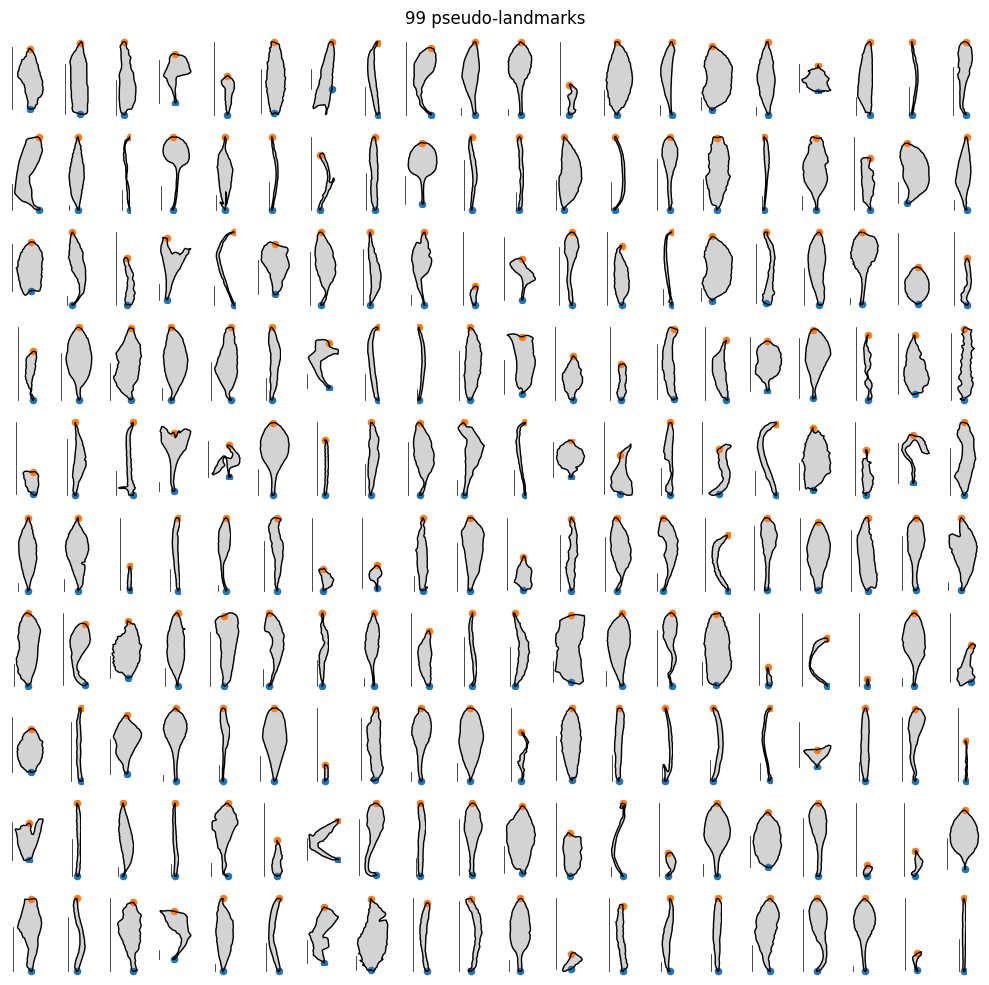

In [61]:
# Plot random leaves and check that it is working

plt.figure(figsize=(10,10)) # set figure size

rand_indices = np.random.randint(0,len(cm_arr),200) # generate random indices of leaves

plot_num = 1 # plot counter number

for i in rand_indices:
    
    plt.subplot(10,20,plot_num) # subplot number
    
    plt.plot(cm_arr[i,:,0], cm_arr[i,:,1], c="k", lw=1) # outline
    plt.fill(cm_arr[i,:,0], cm_arr[i,:,1], c="lightgray", lw=1) # fill
    
    plt.plot([min(cm_arr[i,:,0])-0.1,min(cm_arr[i,:,0])-0.1],
            [cm_arr[i,0,1], cm_arr[i,0,1]+1], c="k", lw=0.5) # cm scale
    
    #plt.scatter(cm_arr[i,:,0], cm_arr[i,:,1], c="k", s=0.1) # points
    plt.scatter(cm_arr[i,0,0], cm_arr[i,0,1], s=20) # base
    plt.scatter(cm_arr[i,res-1,0], cm_arr[i,res-1,1], s=20) # tip
    
    #plt.title(mdata["species"][i], fontsize=6)
    
    plt.gca().set_aspect("equal")
    plt.axis("off")
    
    plot_num += 1
    
plt.suptitle(str(res*2-1) + " pseudo-landmarks")
plt.tight_layout()

# Analyze leaf dimensions

Using placed pseudo-landmarks representing leaves that are rotated upwards and scaled in centimeters from `cm_arr`, calculate the following:

- `width`: difference in centimeters between minimum and maximum x values in an oriented leaf
- `length`: difference in centimeters between minimum and maximum y values in an oriented leaf
- `area`: area of the leaf in centimeters squared
- `solidity`: the ratio of area to convex hull area

Data is stored in the `mdata` dataframe.

In [62]:
# lists to store variables
width_list = []
length_list = []
area_list = []
peri_list = []
solidity_list = []
circ_list = []

# for each leaf . . .
for lf in range(len(cm_arr)):
    
    # for calculating dimensions, we need non-scaled leaves in centimeters
    curr_lf = cm_arr[lf,:,:] # select current leaf
    
    ### CALCULATE DIMENSIONS ###
    width = np.max(curr_lf[:,0])-np.min(curr_lf[:,0]) # calculate width
    length = np.max(curr_lf[:,1])-np.min(curr_lf[:,1]) # calculate length
    area = poly_area(curr_lf[:,0],curr_lf[:,1]) # calcualte area
    
    ### CALCULATE SOLIDITY ###
    hull = ConvexHull(curr_lf) # calculate convex hull of current leaf
    vertices = hull.vertices # isolate vertex indices of convex hull
    convex_area = poly_area(curr_lf[vertices,0], curr_lf[vertices,1]) # calculate convex area
    solidity = area / convex_area # calculate solidity

    ### CALCULATE CIRCULARITY ###
    peri = polygon_perimeter(curr_lf) # calculate perimeter
    circ = (4*(math.pi)*area)/(peri)**2

    # store data in lists
    width_list.append(width)
    length_list.append(length)
    area_list.append(area)
    peri_list.append(peri)
    solidity_list.append(solidity)
    circ_list.append(circ)
  
# add data to the mdata dataframe
mdata["width"] = width_list
mdata["length"] = length_list
mdata["area"] = area_list
mdata["perimeter"] = peri_list
mdata["solidity"] = solidity_list
mdata["circularity"] = circ_list
#mdata["rel_node"] = mdata["node"]/mdata["count"]

mdata.to_csv('lobelia_dimensions.csv', index=False)


# Dimensions and allometric models

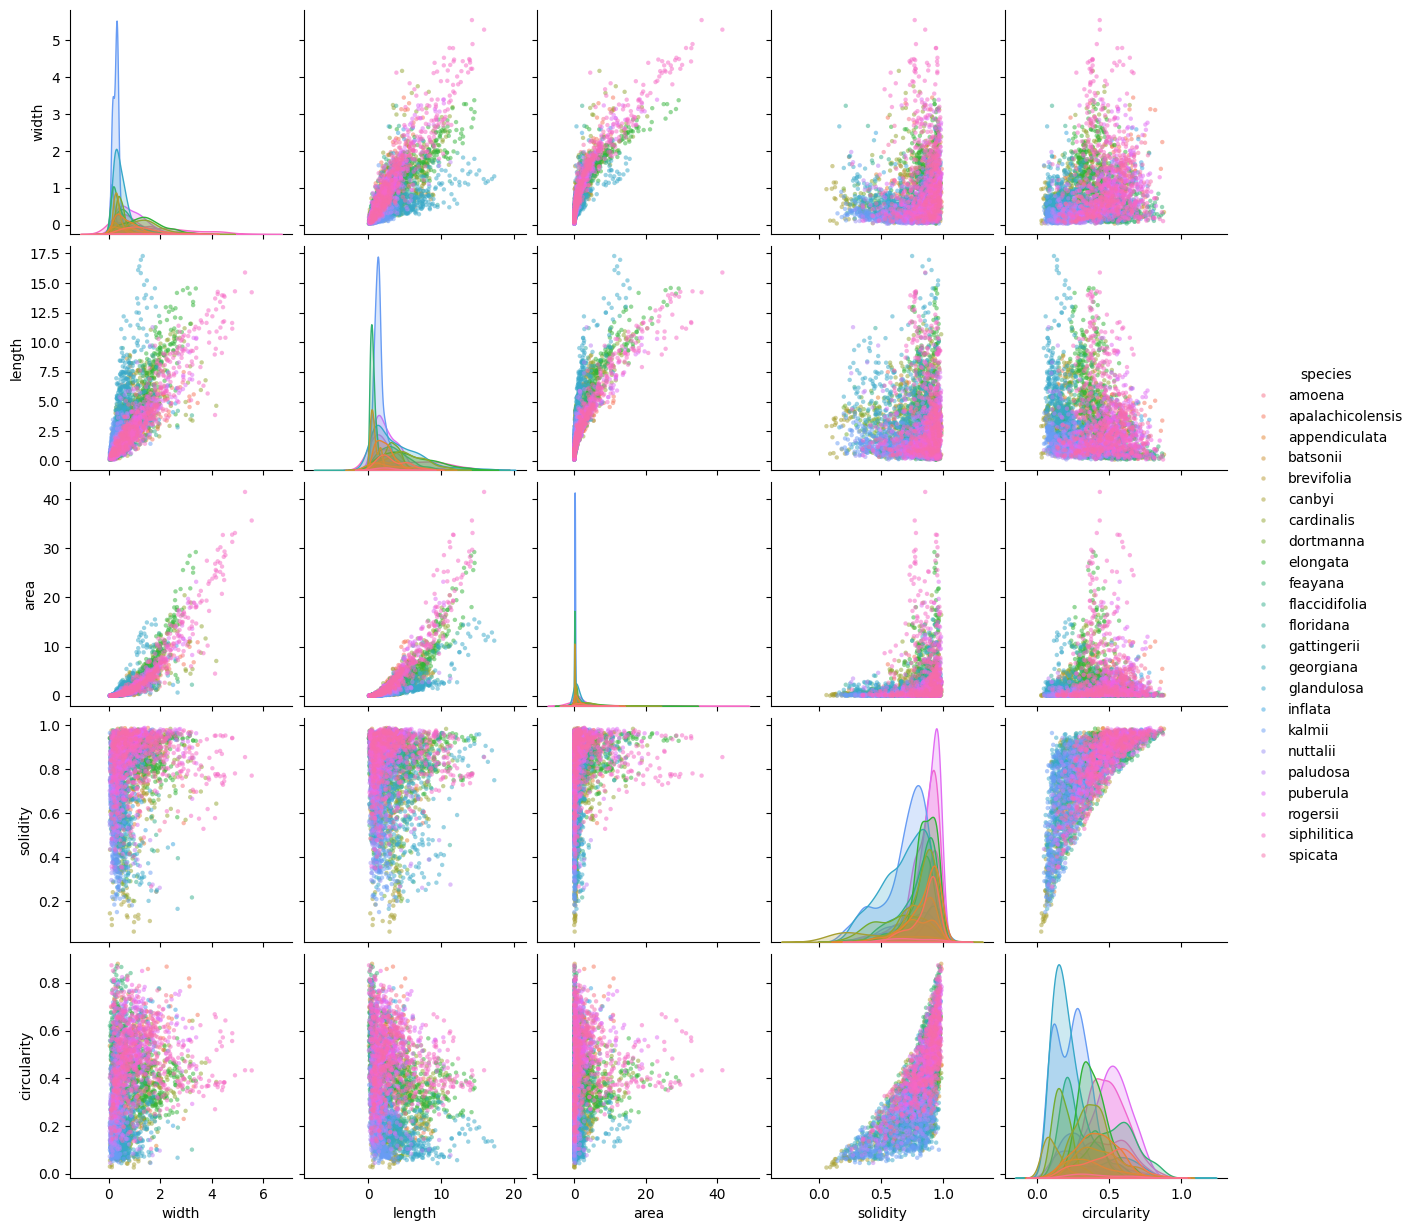

In [63]:
sns.pairplot(mdata,
             x_vars=["width", "length", "area","solidity","circularity"],
             y_vars=["width", "length", "area","solidity","circularity"],
             hue="species",
             plot_kws={"s": 10, "alpha":0.5, "lw":0}
            )


Check how linear and represented each species is before making allometric models

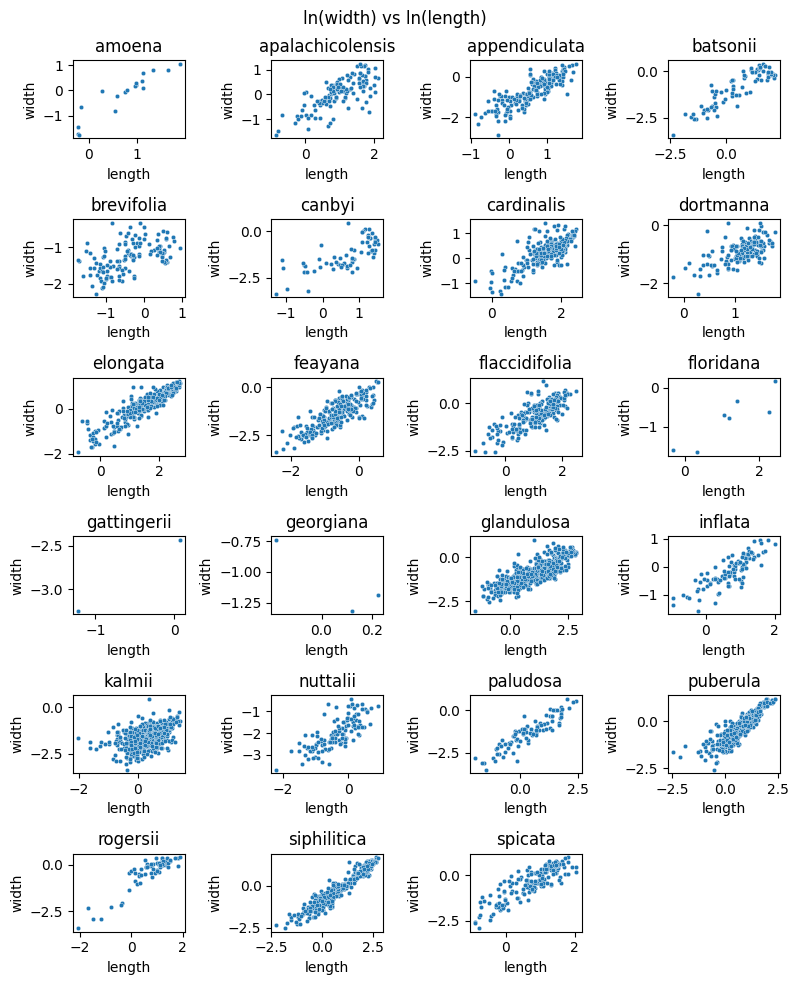

In [64]:
plt.figure(figsize=(8,10))

count = 1 # set a counter
for spe in mdata["species"].unique(): # for each species
    curr_spe = mdata[mdata["species"]==spe] # get current species

    plt.subplot(6,4,count)
    sns.scatterplot(x=np.log(curr_spe["length"]), y=np.log(curr_spe["width"]), s=10)
    plt.title(spe)
    count+=1

plt.suptitle("ln(width) vs ln(length)")
plt.tight_layout()

Create linear allometric models

In [65]:
spes = mdata["species"].unique() # get list of species

coef_list = []
func_list = []
xvals_list = []

for i in range(len(spes)):

    curr_spe = spes[i]

    coefs = np.polyfit(np.log(mdata["width"][mdata["species"]==curr_spe]),
                       np.log(mdata["length"][mdata["species"]==curr_spe]),
                      1)
    func = np.poly1d(coefs)
    xvals = np.linspace(np.log(np.min(mdata["width"][mdata["species"]==curr_spe])),
                             np.log(np.max(mdata["width"][mdata["species"]==curr_spe])), 100)

    coef_list.append(coefs)
    func_list.append(func)
    xvals_list.append(xvals)

Plot all allometric models

Text(0, 0.5, 'ln length, cm')

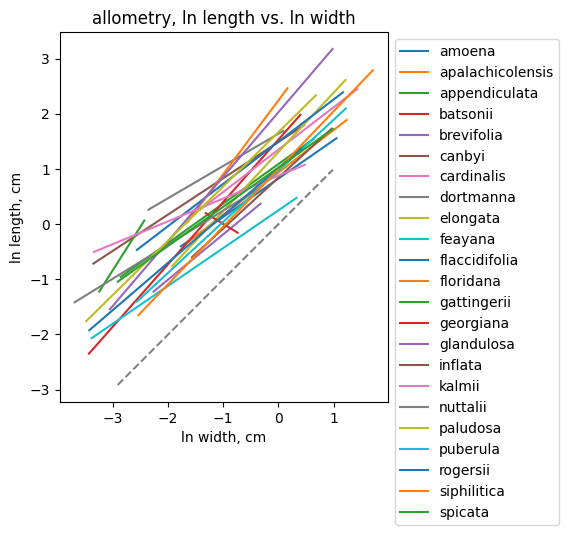

In [66]:
for i in range(len(spes)):

    curr_func = func_list[i]

    # plot allometric lines
    plt.plot(xvals_list[i], curr_func(xvals_list[i]), label=spes[i])

# plot one-to-one line
plt.plot(xvals, xvals, c="gray", linestyle="dashed")

plt.legend(bbox_to_anchor=(1, 1))
plt.gca().set_aspect("equal") # equal aspect ratio
plt.title("allometry, ln length vs. ln width") # title
plt.xlabel("ln width, cm") # x axis title
plt.ylabel("ln length, cm") # y axis title

Only plot models for those species with sufficient counts

Text(0, 0.5, 'ln length, cm')

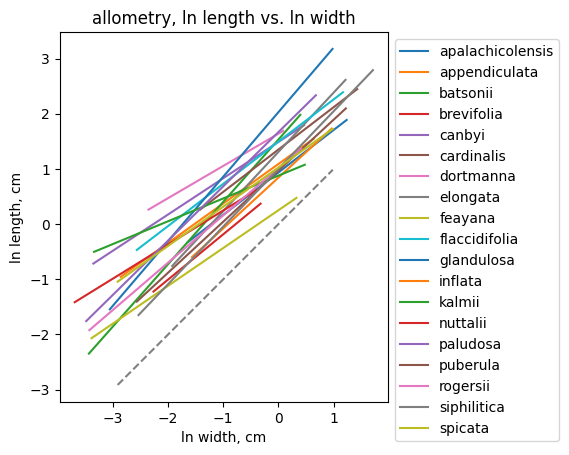

In [67]:
spe_counts = [] # a list of counts of species
for spe in spes: # for each species
    spe_counts.append(len(mdata[mdata["species"]==spe])) # get the count

thresh = 20 # set threshold count to plot

for i in range(len(spes)):
    curr_func = func_list[i]
    if spe_counts[i]>=20:
        # plot allometric lines
        plt.plot(xvals_list[i], curr_func(xvals_list[i]), label=spes[i])
    else:
        continue

# plot one-to-one line
plt.plot(xvals, xvals, c="gray", linestyle="dashed")

plt.legend(bbox_to_anchor=(1, 1))
plt.gca().set_aspect("equal") # equal aspect ratio
plt.title("allometry, ln length vs. ln width") # title
plt.xlabel("ln width, cm") # x axis title
plt.ylabel("ln length, cm") # y axis title

# Procrustes analysis

Perform a Procrustes analysis to translate, scale, and rotate leaf shapes

- Select number of pseudo-landmarks and dimensions
- Calculate the GPA mean leaf shape using the `gpa_mean` function
- Align all leaves to the GPA mean
- Store Procrustes super-imposed leaves in an array, `proc_arr`
- Calculate a PCA for all possible axes and their variance (the number of leaves)
- Calculate a PCA for just the axes needed for reconstruction of eigenleaves for morphospace (probably 2)

In [68]:
landmark_num = (res*2)-1 # select number of landmarks
dim_num = 2 # select number of coordinate value dimensions

##########################
### CALCULATE GPA MEAN ###
##########################

mean_shape = gpa_mean(cm_arr, landmark_num, dim_num)

################################
### ALIGN LEAVES TO GPA MEAN ###
################################

# array to store Procrustes aligned shapes
proc_arr = np.zeros(np.shape(cm_arr)) 

for i in range(len(cm_arr)):
    s1, s2, distance = procrustes(mean_shape, cm_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array
    

# Visualize mean leaf and allometry model together

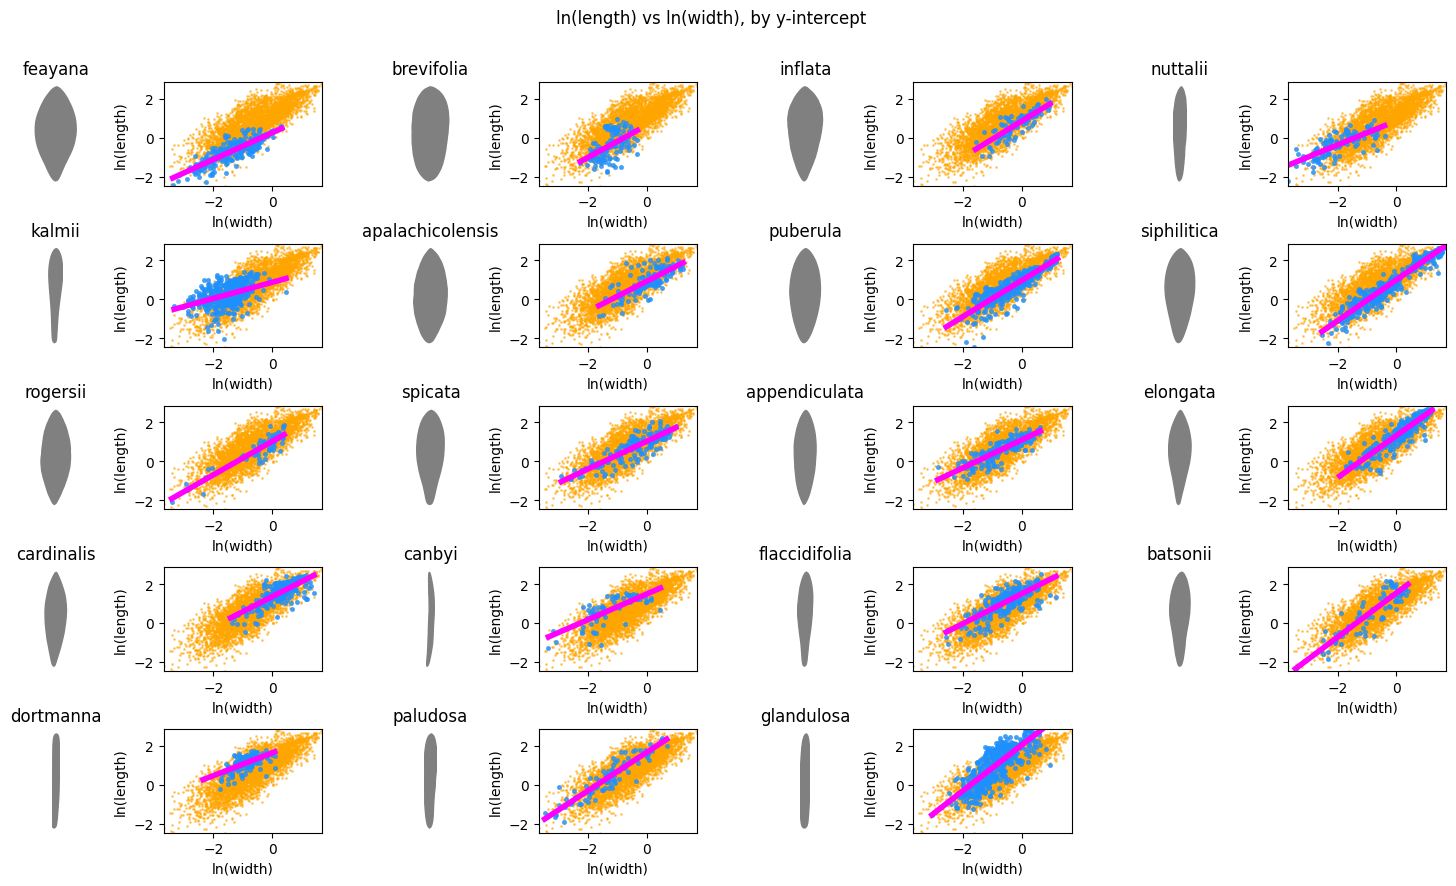

In [69]:
# get indices of species in order by slope
slope_vals = np.array(coef_list)[:,0]
slope_inds = np.argsort(slope_vals)
# get indices of species in order by intercept
intercept_vals = np.array(coef_list)[:,1]
intercept_inds = np.argsort(intercept_vals)

# get overall x and y value min and max for comparison in plotting
xmin = np.min(np.log(mdata["width"]))
xmax = np.max(np.log(mdata["width"]))
ymin = np.min(np.log(mdata["length"]))
ymax = np.max(np.log(mdata["length"]))

plt.figure(figsize=(10*1.5,6*1.5))

count=1
for i in intercept_inds:
    if spe_counts[i]<thresh: # if under threshold number of samples, continue
        continue

    # plot the mean leaf shape
    plt.subplot(5,8,count)
    spe_inds = mdata[mdata["species"]==spes[i]].index
    proc_mean = np.mean(proc_arr[spe_inds,:,:], axis=0)
    plt.fill(proc_mean[:,0], proc_mean[:,1], c="gray")
    plt.title(spes[i])
    plt.gca().set_aspect("equal")
    plt.axis("off")
    count+=1

    # plot the allometric model
    plt.subplot(5,8,count)
    plt.scatter(x=np.log(mdata["width"].iloc[spe_inds]), y=np.log(mdata["length"].iloc[spe_inds]), c="dodgerblue", s=7, alpha=0.7)
    plt.scatter(x=np.log(mdata["width"]), y=np.log(mdata["length"]), zorder=0, c="orange", s=1, alpha=0.5)
    curr_func = func_list[i]
    plt.plot( xvals_list[i], curr_func(xvals_list[i]) , c="magenta", lw=4)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel("ln(width)")
    plt.ylabel("ln(length)")
    count+=1

plt.suptitle("ln(length) vs ln(width), by y-intercept\n")
plt.tight_layout()



# Principal Component Analysis

In [70]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = 198 # PC number = not number of leaves, but features
#######

# use the reshape function to flatten to 2D
flat_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                 np.shape(proc_arr)[1]*np.shape(proc_arr)[2]) 

pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = pca_all.fit_transform(flat_arr) # fit a PCA for all data

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca_all.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca_all.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca_all.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )


PC: var, overall 
PC1: 48.1%, 48.1%
PC2: 13.6%, 61.6%
PC3: 9.4%, 71.0%
PC4: 9.2%, 80.2%
PC5: 7.4%, 87.6%
PC6: 1.9%, 89.6%
PC7: 1.8%, 91.3%
PC8: 1.7%, 93.0%
PC9: 1.5%, 94.5%
PC10: 0.8%, 95.4%
PC11: 0.6%, 96.0%
PC12: 0.5%, 96.5%
PC13: 0.5%, 97.0%
PC14: 0.3%, 97.4%
PC15: 0.3%, 97.7%
PC16: 0.3%, 97.9%
PC17: 0.2%, 98.2%
PC18: 0.2%, 98.4%
PC19: 0.2%, 98.5%
PC20: 0.1%, 98.7%
PC21: 0.1%, 98.8%
PC22: 0.1%, 98.9%
PC23: 0.1%, 99.0%
PC24: 0.1%, 99.0%
PC25: 0.1%, 99.1%
PC26: 0.1%, 99.2%
PC27: 0.1%, 99.2%
PC28: 0.1%, 99.3%
PC29: 0.1%, 99.3%
PC30: 0.0%, 99.4%
PC31: 0.0%, 99.4%
PC32: 0.0%, 99.4%
PC33: 0.0%, 99.5%
PC34: 0.0%, 99.5%
PC35: 0.0%, 99.5%
PC36: 0.0%, 99.6%
PC37: 0.0%, 99.6%
PC38: 0.0%, 99.6%
PC39: 0.0%, 99.6%
PC40: 0.0%, 99.6%
PC41: 0.0%, 99.7%
PC42: 0.0%, 99.7%
PC43: 0.0%, 99.7%
PC44: 0.0%, 99.7%
PC45: 0.0%, 99.7%
PC46: 0.0%, 99.7%
PC47: 0.0%, 99.7%
PC48: 0.0%, 99.7%
PC49: 0.0%, 99.7%
PC50: 0.0%, 99.8%
PC51: 0.0%, 99.8%
PC52: 0.0%, 99.8%
PC53: 0.0%, 99.8%
PC54: 0.0%, 99.8%
PC55: 0.0%, 99.8%

In [71]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_comps = 5 # keep to 5 for now for reconstruction
#######

pca = PCA(n_components=PC_comps) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )
    
# add PCs to dataframe for plotting
mdata["PC1"] = PCs[:,0]
mdata["PC2"] = PCs[:,1]
mdata["PC3"] = PCs[:,2]
mdata["PC4"] = PCs[:,3]
mdata["PC5"] = PCs[:,4]

PC: var, overall 
PC1: 48.1%, 48.1%
PC2: 13.6%, 61.6%
PC3: 9.4%, 71.0%
PC4: 9.2%, 80.2%
PC5: 7.4%, 87.6%


In [72]:
nstdev = 2 # set number of standard deviations
int = 20 # set interval number

## calculate PC vals for eigenkernels
PCval_arr = np.zeros((PC_comps, int, PC_comps)) # array to hold PC vals for eigenkernels
for i in range(PC_comps): # for each PC
    stdvals = np.linspace(-nstdev,+nstdev,int) # set standard deviation values to calculate eigenkernels
    for j in range(len(stdvals)): # for each stdval
        PCval_arr[i,j,i] =  (np.mean(PCs[:,i]))+np.std(PCs[:,i])*stdvals[j] # store PC vals

## calculate eigenleaf shapes
eigenlf = np.zeros((PC_comps, int, 2*res-1, 2))
for k in range(PC_comps):
    for l in range(int):
        # calculate the inverse eigenkernels
        inv_lf = pca.inverse_transform( PCval_arr[k,l,:] )
        inv_x = inv_lf[0:(2*res-1)*2:2] # select just inverse x vals
        inv_y = inv_lf[1:(2*res-1)*2:2] # select just inverse y vals
        eigenlf[k,l,:,:] = np.column_stack((inv_x, inv_y))

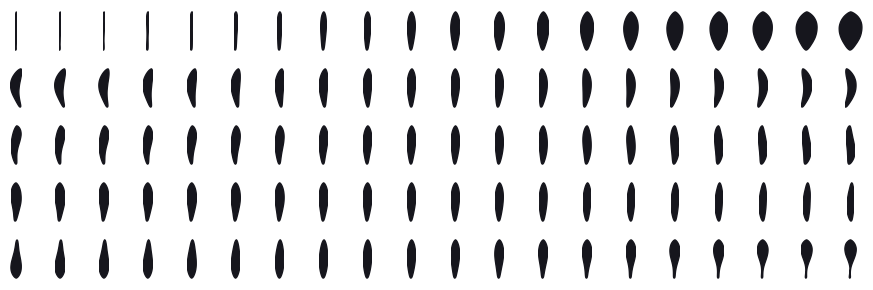

In [73]:
counter = 1
plt.figure(figsize=(9,3))

for m in range(PC_comps):
    for n in range(int):
        plt.subplot(PC_comps,int,counter)
        plt.fill(eigenlf[m,n,:,0], eigenlf[m,n,:,1], c="#16161d")
        plt.gca().set_aspect("equal")
        counter+=1
        plt.axis("off")
plt.tight_layout()

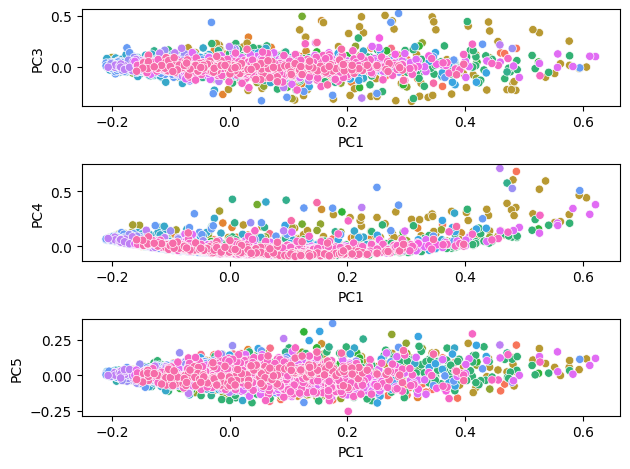

In [74]:
plt.subplot(3,1,1)
sns.scatterplot(mdata, x="PC1", y="PC3", hue="species", legend=False)

plt.subplot(3,1,2)
sns.scatterplot(mdata, x="PC1", y="PC4", hue="species", legend=False)

plt.subplot(3,1,3)
sns.scatterplot(mdata, x="PC1", y="PC5", hue="species", legend=False)

plt.tight_layout()

<Axes: xlabel='PC5', ylabel='Count'>

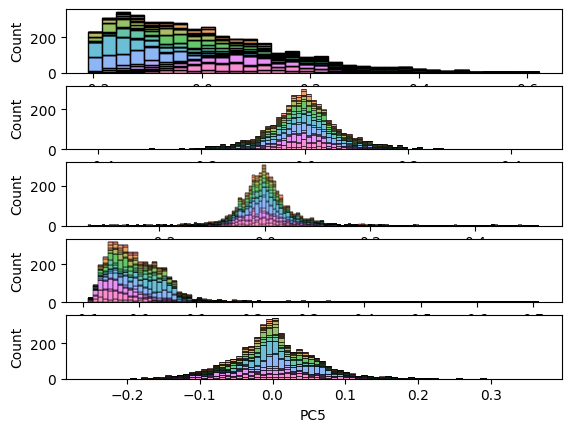

In [75]:
plt.subplot(5,1,1)
sns.histplot(mdata, x="PC1",hue="species", multiple="stack", legend=False)

plt.subplot(5,1,2)
sns.histplot(mdata, x="PC2",hue="species", multiple="stack", legend=False)

plt.subplot(5,1,3)
sns.histplot(mdata, x="PC3",hue="species", multiple="stack", legend=False)

plt.subplot(5,1,4)
sns.histplot(mdata, x="PC4",hue="species", multiple="stack", legend=False)

plt.subplot(5,1,5)
sns.histplot(mdata, x="PC5",hue="species", multiple="stack", legend=False)

Save PCA and PC vals for 3D light modeling

In [76]:
######
PC_comps = 10 
#######

pca = PCA(n_components=PC_comps) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

import pickle
with open("lobelia_pca.pkl", "wb") as file:
    pickle.dump(pca, file)
np.save('lobelia_pc_vals.npy', PCs)


________________
# PREDICTION:
# SPECIES
________________

In [77]:
# Get numbers of each species class (for initial check)
print("Initial species counts:\n", mdata["species"].value_counts())

# We are using K=5 fold stratified sampling
# Classes with less than 5 samples are removed
# Remove "georgiana" and "gattingerii"

# Class labels to remove
labels_to_remove = ['georgiana', 'gattingerii']
print(f"\nRemoving classes: {labels_to_remove}")

# Create mask
mask = ~mdata['species'].isin(labels_to_remove)

# Filter the DataFrame
mdata_filtered = mdata[mask]

# --- IMPORTANT ADDITION: Reset the index ---
# This creates a new, contiguous 0-based index and drops the old one.
mdata_filtered = mdata_filtered.reset_index(drop=True)

# Filter the numerical array using the same mask
proc_arr_filtered = proc_arr[mask.values] # .values converts pandas Series mask to numpy array for numpy indexing

# Change variable names for code compatibility
all_mdata = mdata_filtered
proc_arr = proc_arr_filtered

print(f"\nFiltered data shape: proc_arr {proc_arr.shape}, all_mdata {all_mdata.shape}")
print("Species counts after filtering:\n", all_mdata["species"].value_counts())

# --- Initialize results_storage (as you had it) ---
# Initialize this dictionary ONCE at the start of your notebook session
# This will store all comparison results for plotting later
results_storage = {}

# --- RUN THIS BLOCK FOR 'full_name' ---
TARGET_COLUMN = 'species'
# Initialize target_column entry in results_storage if it doesn't exist
if TARGET_COLUMN not in results_storage:
    results_storage[TARGET_COLUMN] = {
        'class_counts': {},
        'model_metrics': {} # This will store precision/recall for each model
    }
print(f"\n'{TARGET_COLUMN}' is set as the TARGET_COLUMN and results_storage initialized.")

Initial species counts:
 species
kalmii              544
glandulosa          505
puberula            390
siphilitica         374
elongata            294
flaccidifolia       232
feayana             227
cardinalis          223
spicata             179
appendiculata       179
dortmanna           149
brevifolia          126
apalachicolensis    123
nuttalii            118
inflata              96
paludosa             85
batsonii             79
canbyi               69
rogersii             64
amoena               18
floridana             7
georgiana             3
gattingerii           2
Name: count, dtype: int64

Removing classes: ['georgiana', 'gattingerii']

Filtered data shape: proc_arr (4081, 99, 2), all_mdata (4081, 19)
Species counts after filtering:
 species
kalmii              544
glandulosa          505
puberula            390
siphilitica         374
elongata            294
flaccidifolia       232
feayana             227
cardinalis          223
spicata             179
appendiculata    

## Unbalanced LDA

--- Running Unbalanced LDA for TARGET_COLUMN: species ---

--- Performing LDA with 5-Fold Stratified Cross-Validation on 'species' ---

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5


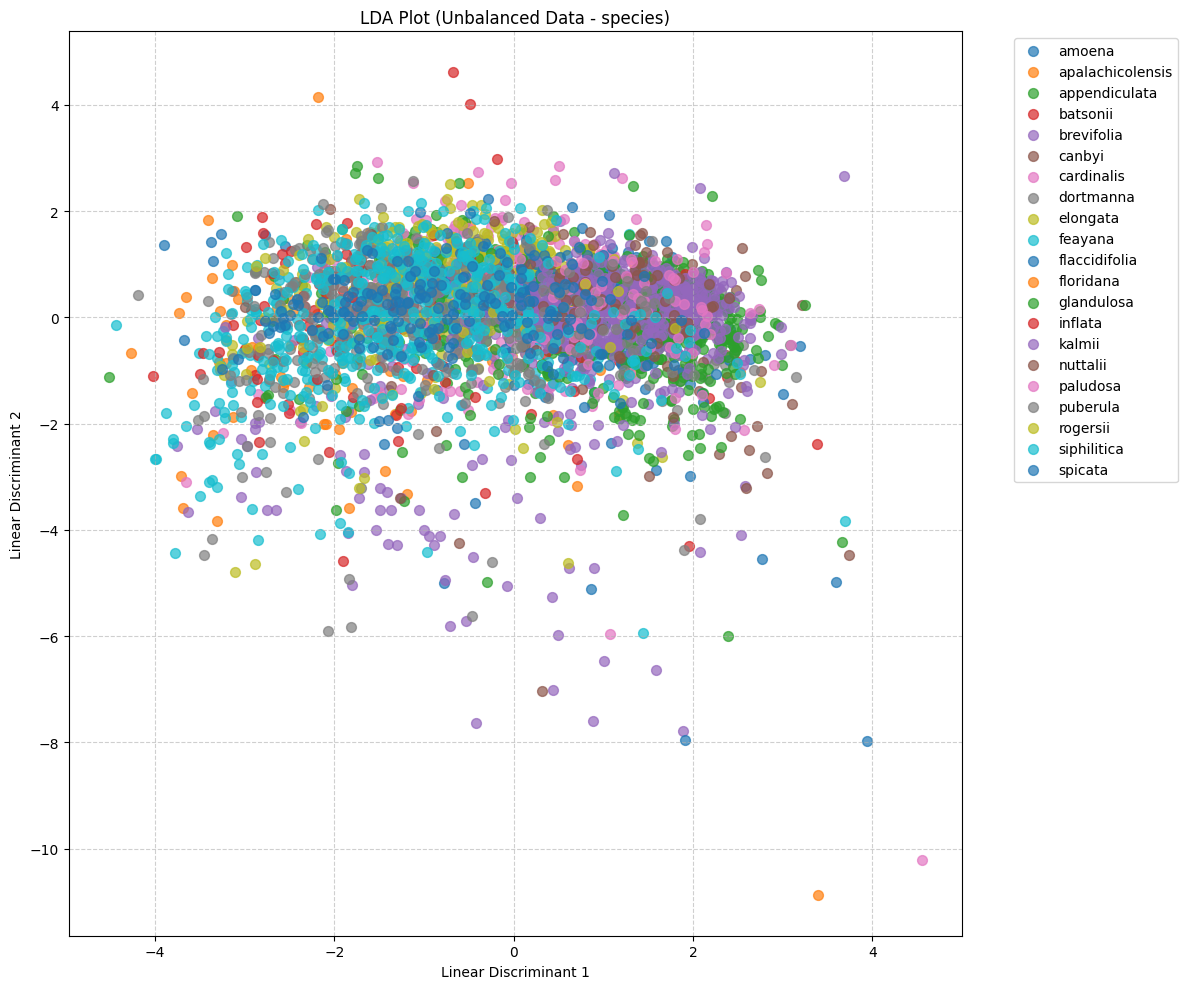


--- Overall Accuracy (Unbalanced Data - species): 0.2889 ---

--- Classification Report (Unbalanced Data - species) ---
                  precision    recall  f1-score   support

          amoena       0.00      0.00      0.00        18
apalachicolensis       0.16      0.10      0.12       123
   appendiculata       0.20      0.16      0.18       179
        batsonii       0.04      0.01      0.02        79
      brevifolia       0.38      0.35      0.36       126
          canbyi       0.23      0.26      0.24        69
      cardinalis       0.30      0.27      0.29       223
       dortmanna       0.21      0.15      0.17       149
        elongata       0.33      0.36      0.35       294
         feayana       0.35      0.30      0.32       227
   flaccidifolia       0.12      0.06      0.08       232
       floridana       0.00      0.00      0.00         7
      glandulosa       0.38      0.51      0.43       505
         inflata       0.09      0.05      0.07        96
        

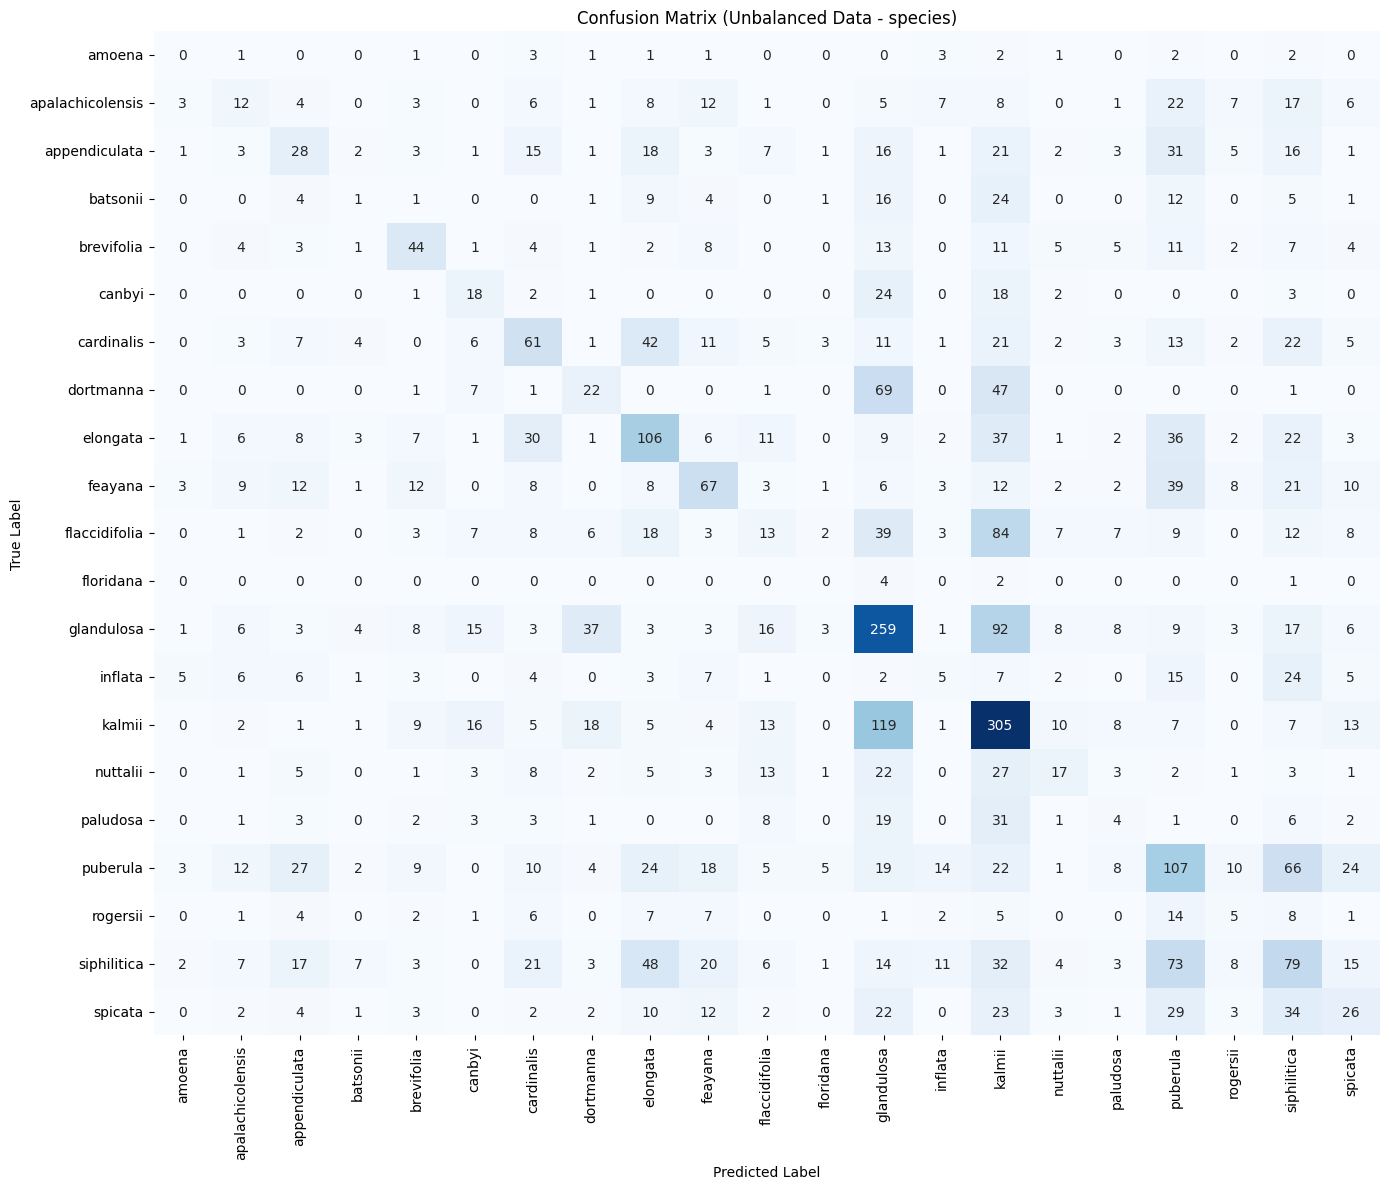

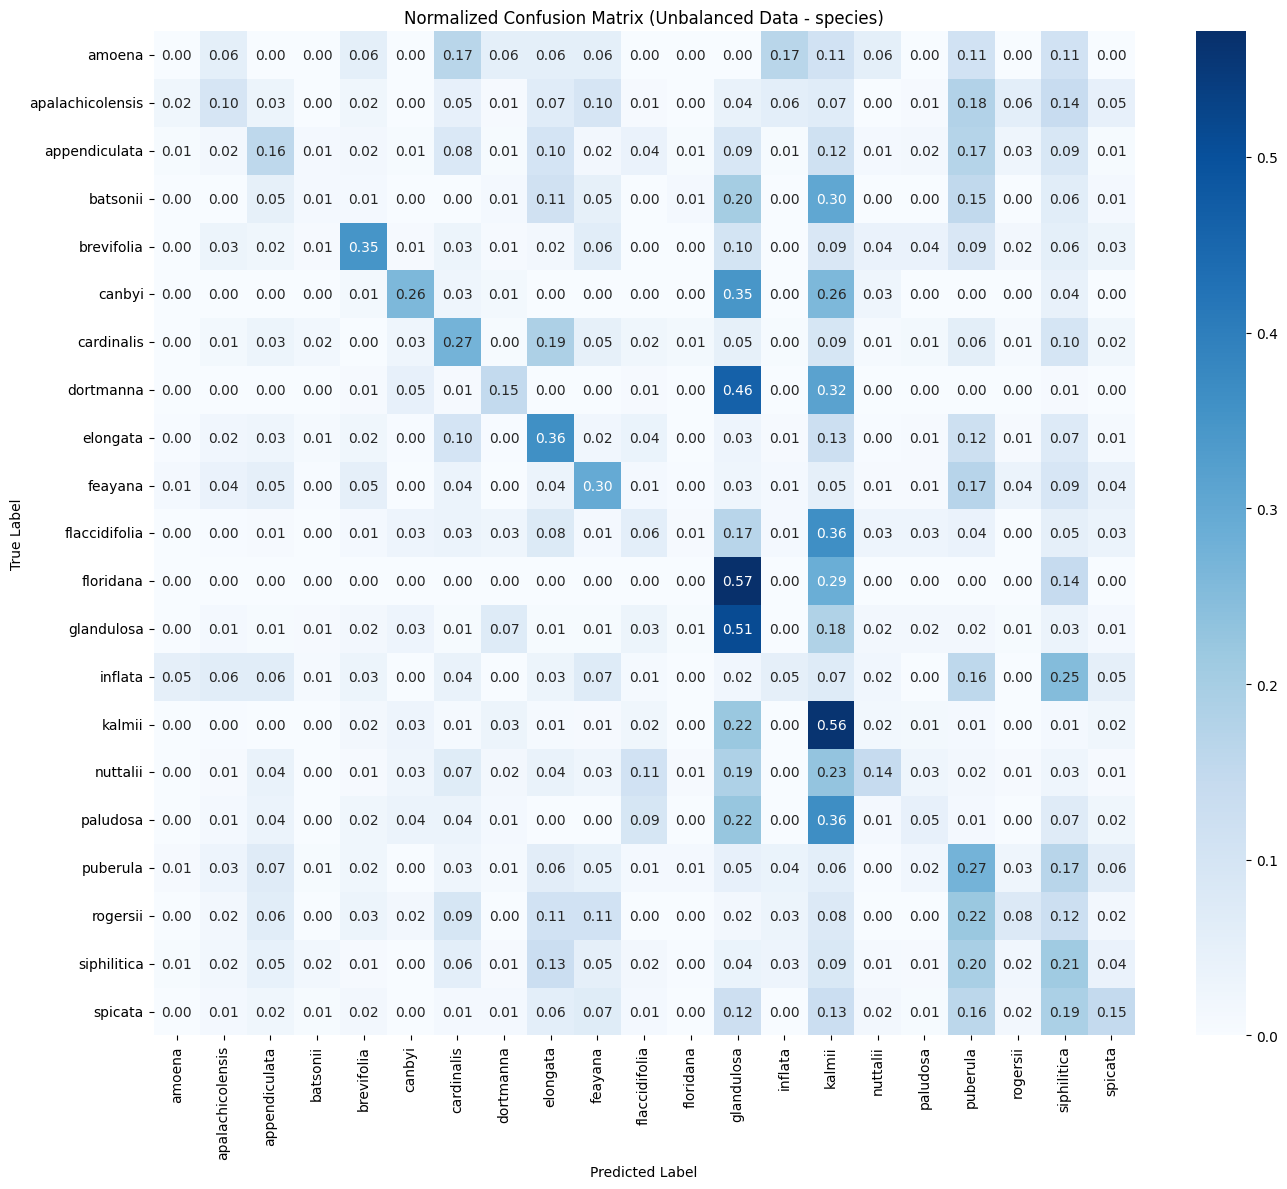

In [78]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- ASSUMPTION: Data (proc_arr, all_mdata, pca) is already loaded/defined. ---
# --- ASSUMPTION: TARGET_COLUMN is set (e.g., TARGET_COLUMN = 'full_name') ---
# --- ASSUMPTION: results_storage dictionary is initialized (see instructions above) ---

print(f"--- Running Unbalanced LDA for TARGET_COLUMN: {TARGET_COLUMN} ---")

# 1. Prepare Data for LDA
# Flatten the 3D proc_arr to a 2D array (samples, features)
X = proc_arr.reshape(np.shape(proc_arr)[0], np.shape(proc_arr)[1] * np.shape(proc_arr)[2])

# Get the target variable (labels) using the specified TARGET_COLUMN
y = all_mdata[TARGET_COLUMN]

# --- Store class counts for the current TARGET_COLUMN (only needs to be done once per TARGET_COLUMN) ---
if not results_storage[TARGET_COLUMN]['class_counts']: # Only populate if empty
    results_storage[TARGET_COLUMN]['class_counts'] = y.value_counts().sort_index().to_dict()


# --- Check for minimum samples per class for StratifiedKFold ---
min_samples_in_any_class = y.value_counts().min()
n_splits = 5 # Default, a good starting point

if min_samples_in_any_class < n_splits:
    print(f"Warning: Smallest class has {min_samples_in_any_class} samples for '{TARGET_COLUMN}', which is less than n_splits={n_splits}.")
    print("Consider adjusting n_splits or excluding very small classes if errors occur.")
    # StratifiedKFold will raise an error if a class has fewer than n_splits samples.
    # For now, we'll proceed assuming this is handled or `n_splits` is adjusted if truly necessary.

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store results for aggregation
all_y_true = []
all_y_pred = []
all_lda_scores = []
all_y_labels_for_plot = [] # Use a different name to avoid confusion with overall y

print(f"\n--- Performing LDA with {n_splits}-Fold Stratified Cross-Validation on '{TARGET_COLUMN}' ---")

# Iterate through folds
for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold_idx + 1}/{n_splits}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize and fit LDA model
    # The number of components for LDA is at most n_classes - 1.
    # Let's set it to the minimum of n_classes - 1 or the number of features.
    n_components_lda = min(len(y.unique()) - 1, X.shape[1])
    lda = LinearDiscriminantAnalysis(n_components=n_components_lda)

    # Fit LDA on training data and transform both train and test data
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)

    # Make predictions on the test set
    y_pred = lda.predict(X_test)

    # Store true and predicted labels for overall confusion matrix
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # Store LDA scores and corresponding true labels for plotting
    all_lda_scores.append(X_test_lda)
    all_y_labels_for_plot.extend(y_test)

# Concatenate all LDA scores for plotting
all_lda_scores = np.vstack(all_lda_scores)
all_y_labels_for_plot = np.array(all_y_labels_for_plot)


# 2. Visualize LDA Plot with LDA Scores

# Get unique class names in sorted order for consistent plotting
class_names = sorted(y.unique())
# num_classes = len(class_names) # Already defined when checking n_components_lda, if needed

# Plotting LDA scores (first two components if available)
plt.figure(figsize=(12, 10))
if all_lda_scores.shape[1] >= 2:
    for i, class_name in enumerate(class_names):
        # Filter data for the current class
        class_data = all_lda_scores[all_y_labels_for_plot == class_name]
        plt.scatter(class_data[:, 0], class_data[:, 1], label=class_name, alpha=0.7, s=50)
    plt.xlabel('Linear Discriminant 1')
    plt.ylabel('Linear Discriminant 2')
    plt.title(f'LDA Plot (Unbalanced Data - {TARGET_COLUMN})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
elif all_lda_scores.shape[1] == 1:
    # If only one component, plot as a 1D scatter or histogram
    plt.figure(figsize=(10, 6))
    for i, class_name in enumerate(class_names):
        class_data = all_lda_scores[all_y_labels_for_plot == class_name]
        plt.scatter(class_data[:, 0], np.zeros_like(class_data[:, 0]), label=class_name, alpha=0.7, s=50, jitter=0.1)
    plt.xlabel('Linear Discriminant 1')
    plt.title(f'LDA Plot (Unbalanced Data - {TARGET_COLUMN}) - 1D Projection')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print(f"LDA resulted in less than 1 discriminant component for '{TARGET_COLUMN}'. Cannot plot LDA scores.")


# 3. Calculate and Visualize Confusion Matrix & Store Results

# Convert lists to numpy arrays for sklearn metrics
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# Overall Accuracy
overall_accuracy = accuracy_score(all_y_true, all_y_pred)
print(f"\n--- Overall Accuracy (Unbalanced Data - {TARGET_COLUMN}): {overall_accuracy:.4f} ---")

# Classification Report (provides precision, recall, f1-score per class)
print(f"\n--- Classification Report (Unbalanced Data - {TARGET_COLUMN}) ---")
report_dict = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True, zero_division=0)
print(classification_report(all_y_true, all_y_pred, target_names=class_names, zero_division=0))

# --- STORE PER-CLASS PRECISION AND RECALL ---
model_name = 'unbalanced_lda'
results_storage[TARGET_COLUMN]['model_metrics'][model_name] = {
    'precision': {cls: report_dict[cls]['precision'] for cls in class_names},
    'recall': {cls: report_dict[cls]['recall'] for cls in class_names}
}
print(f"--- Stored metrics for '{model_name}' for '{TARGET_COLUMN}'. ---")

# Confusion Matrix
cm = confusion_matrix(all_y_true, all_y_pred, labels=class_names) # Use labels for consistent order

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Unbalanced Data - {TARGET_COLUMN})')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Optional: Normalized Confusion Matrix (to see proportions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize by true class
cm_normalized[np.isnan(cm_normalized)] = 0 # Handle potential NaN for classes with no true samples

plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Normalized Confusion Matrix (Unbalanced Data - {TARGET_COLUMN})')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Data augmentation LDA

--- Running Augmented LDA for TARGET_COLUMN: species ---
Shape of X_original: (4081, 198)
Number of components in your fitted PCA object (`pca_full`): 198
Shape of X_pca_original_full (after pca_full.transform): (4081, 198)

--- Starting Data Augmentation ---
Augmenting class 'glandulosa': generating 39 new samples.
Augmenting class 'puberula': generating 154 new samples.
Augmenting class 'siphilitica': generating 170 new samples.
Augmenting class 'elongata': generating 250 new samples.
Augmenting class 'flaccidifolia': generating 312 new samples.
Augmenting class 'feayana': generating 317 new samples.
Augmenting class 'cardinalis': generating 321 new samples.
Augmenting class 'spicata': generating 365 new samples.
Augmenting class 'appendiculata': generating 365 new samples.
Augmenting class 'dortmanna': generating 395 new samples.
Augmenting class 'brevifolia': generating 418 new samples.
Augmenting class 'apalachicolensis': generating 421 new samples.
Augmenting class 'nuttalii': ge

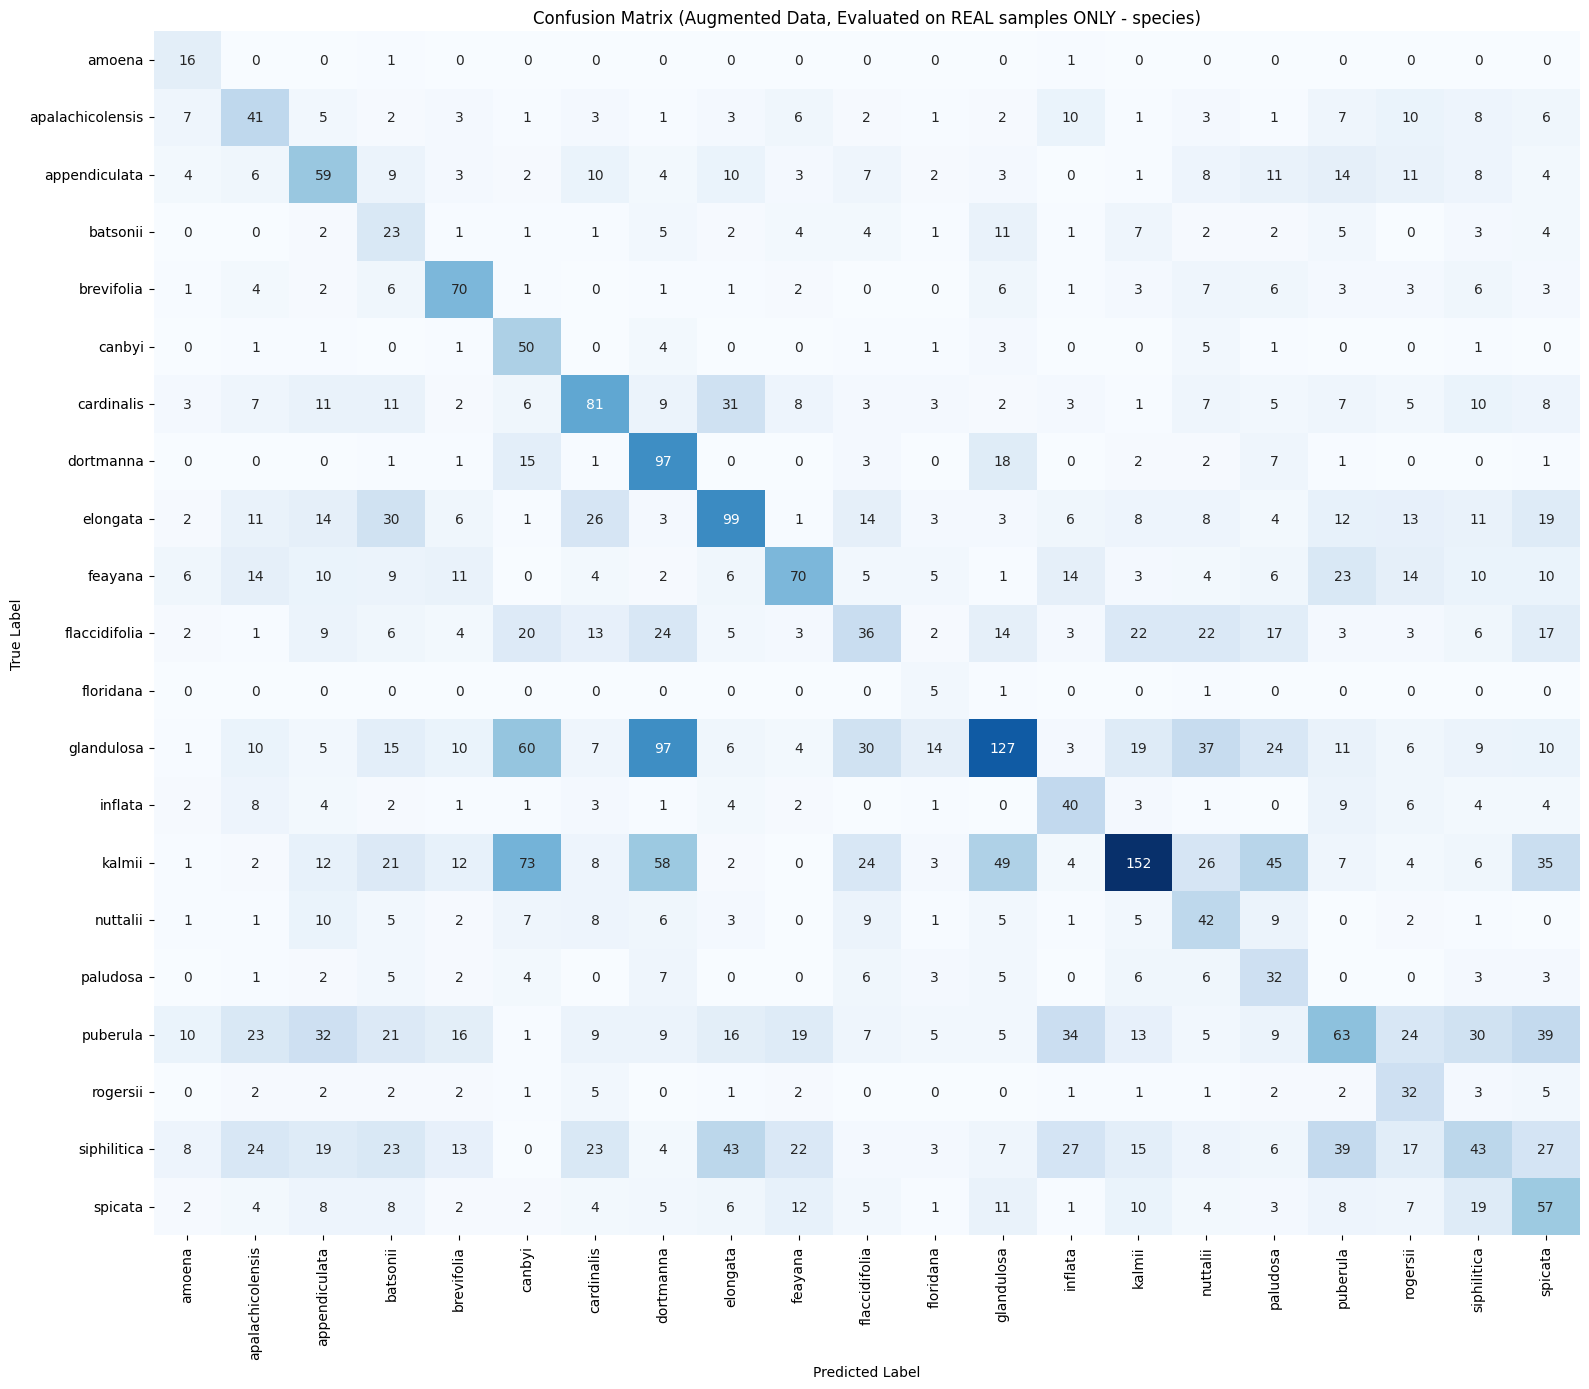

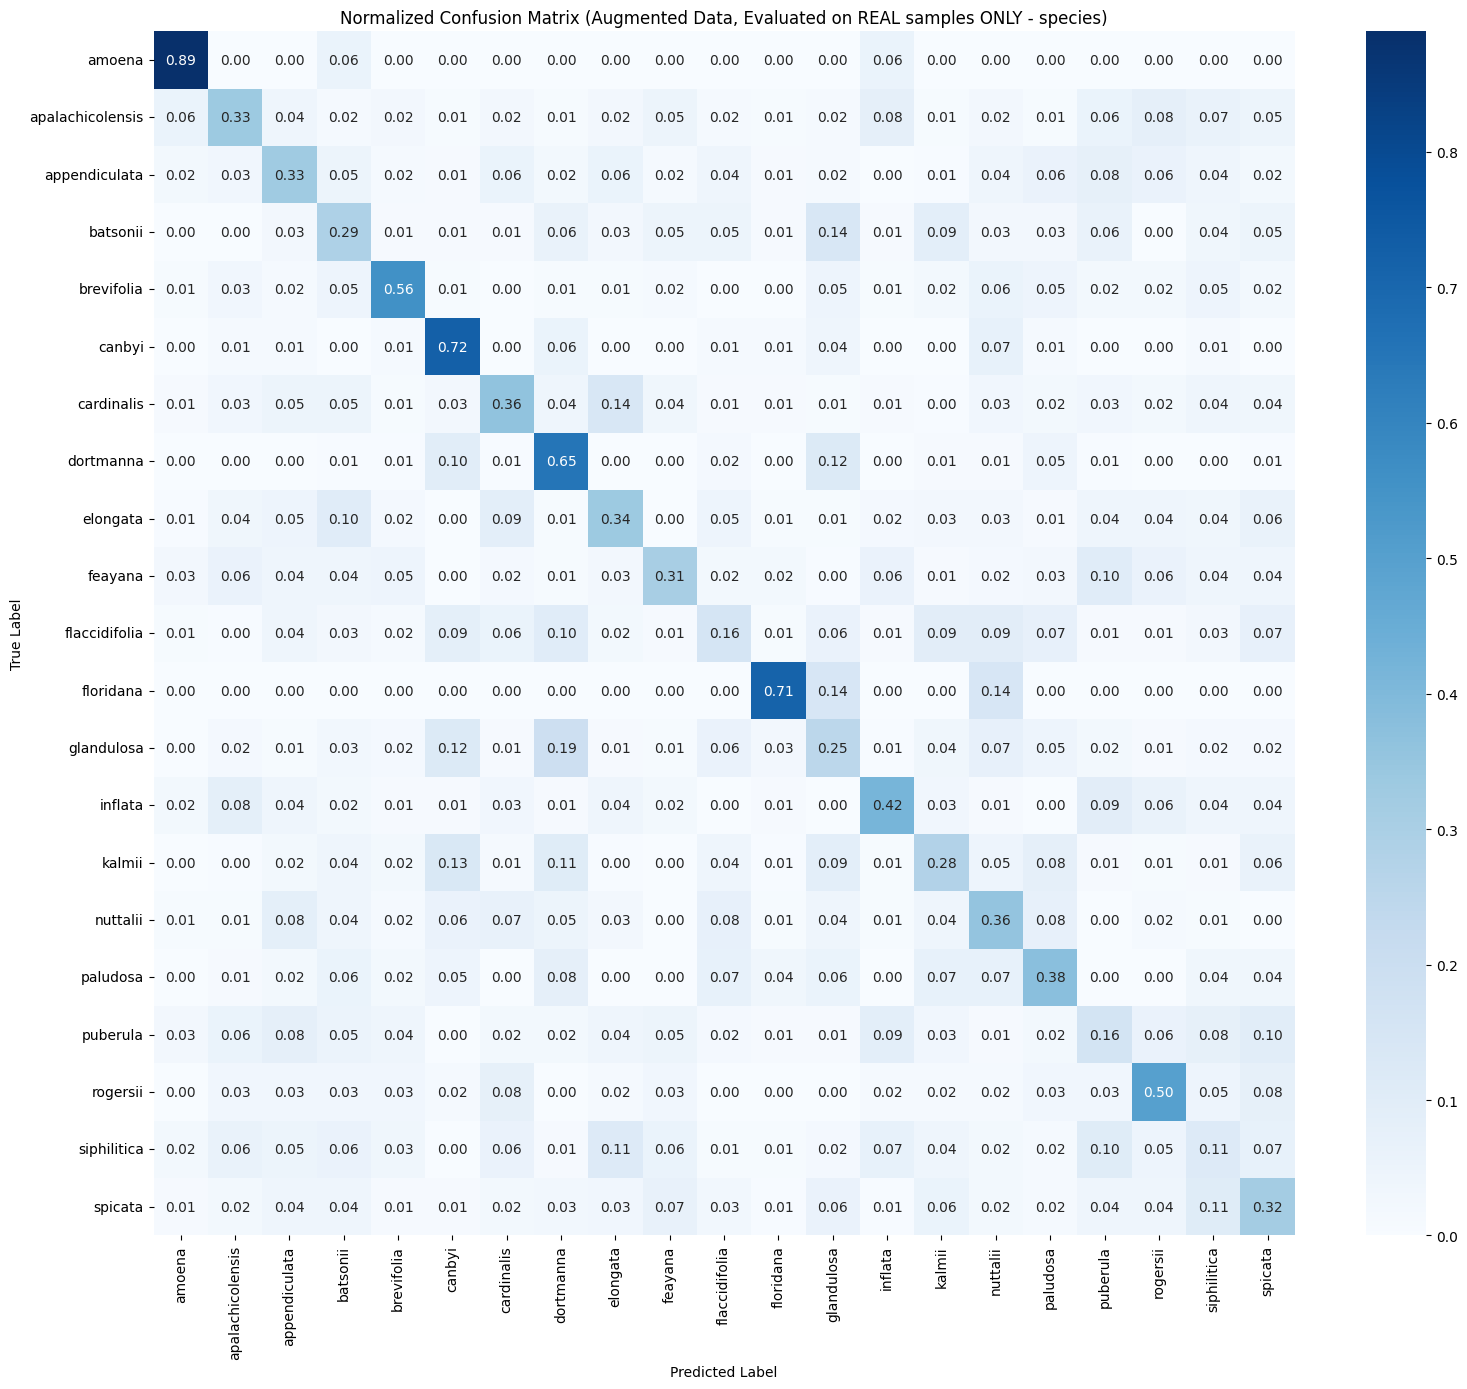

In [79]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# --- ASSUMPTION: Data (proc_arr, all_mdata) is already loaded/defined. ---
# --- ASSUMPTION: TARGET_COLUMN is set (e.g., TARGET_COLUMN = 'full_name') ---
# --- ASSUMPTION: results_storage dictionary is initialized (from a previous cell) ---

print(f"--- Running Augmented LDA for TARGET_COLUMN: {TARGET_COLUMN} ---")

# --- PCA setup and Data Augmentation (SMOTE-like in FULL PCA space) ---
# X_original is the flattened proc_arr
X_original = proc_arr.reshape(np.shape(proc_arr)[0], np.shape(proc_arr)[1] * np.shape(proc_arr)[2])
y_original = all_mdata[TARGET_COLUMN] # Use the specified TARGET_COLUMN

# Fit PCA on the full features
# n_components=None means keep all components up to min(n_samples, n_features) - 1
pca_full = PCA(n_components=None, random_state=42)
pca_full.fit(X_original)

# Now, transform X_original to get scores for ALL components
X_pca_original_full = pca_full.transform(X_original)

print(f"Shape of X_original: {X_original.shape}")
print(f"Number of components in your fitted PCA object (`pca_full`): {pca_full.n_components_}")
print(f"Shape of X_pca_original_full (after pca_full.transform): {X_pca_original_full.shape}")

print("\n--- Starting Data Augmentation ---")

# Calculate value counts to determine target size and identify minority classes
class_counts = y_original.value_counts()
max_samples = class_counts.max() # Target size for all classes

# Initialize lists to store augmented data AND a flag for real/synthetic
augmented_X_pca = X_pca_original_full.tolist()
augmented_y = y_original.tolist()
is_real_flag = [True] * len(y_original) # All original samples are real

# Iterate through each class to perform augmentation
for class_name, count in class_counts.items():
    if count < max_samples:
        samples_to_generate = max_samples - count
        print(f"Augmenting class '{class_name}': generating {samples_to_generate} new samples.")

        class_indices = y_original[y_original == class_name].index
        class_pca_samples = X_pca_original_full[class_indices]

        n_neighbors_for_class = min(len(class_pca_samples) - 1, 6) # Ensure at least 1 neighbor available
        if n_neighbors_for_class < 1: # Needs at least 1 for NearestNeighbors, 2 for interpolation
            print(f"Warning: Class '{class_name}' has too few samples ({len(class_pca_samples)}) for meaningful augmentation. Skipping.")
            continue
        
        # Ensure n_neighbors is at least 1 for NearestNeighbors, but needs 2 for alpha * (neighbor - sample)
        # If n_neighbors_for_class is 1, it means we can only pick the sample itself as a neighbor.
        # So, if only 1 sample, we can't interpolate.
        if len(class_pca_samples) < 2:
             print(f"Warning: Class '{class_name}' has less than 2 samples. Cannot perform SMOTE-like augmentation for interpolation. Skipping.")
             continue

        nn = NearestNeighbors(n_neighbors=n_neighbors_for_class).fit(class_pca_samples)
        distances, indices = nn.kneighbors(class_pca_samples)

        generated_count = 0
        while generated_count < samples_to_generate:
            idx_in_class = np.random.randint(0, len(class_pca_samples))
            sample = class_pca_samples[idx_in_class]

            # Select a random neighbor, ensuring it's not the sample itself (hence neighbor_idx_in_nn_output starts from 1)
            # Make sure there is at least one actual neighbor (indices[idx_in_class] has more than 1 element)
            if len(indices[idx_in_class]) < 2:
                # This should ideally not happen if n_neighbors_for_class was set > 1 and len(class_pca_samples) > 1
                continue

            neighbor_idx_in_nn_output = np.random.randint(1, len(indices[idx_in_class]))
            neighbor_original_idx_in_class_pca = indices[idx_in_class][neighbor_idx_in_nn_output]
            neighbor = class_pca_samples[neighbor_original_idx_in_class_pca]

            alpha = np.random.rand()
            synthetic_pca_sample = sample + alpha * (neighbor - sample)

            augmented_X_pca.append(synthetic_pca_sample)
            augmented_y.append(class_name)
            is_real_flag.append(False) # Mark as synthetic
            generated_count += 1

print("--- Data Augmentation Complete ---")

# Convert augmented data lists to numpy arrays
X_pca_augmented_full = np.array(augmented_X_pca)
y_augmented = np.array(augmented_y)
is_real_flag = np.array(is_real_flag) # Convert flag to numpy array

# Inverse transform the augmented PCA data back to original feature space (198 features)
X_augmented = pca_full.inverse_transform(X_pca_augmented_full)

# Verify shapes
print(f"\nOriginal data shape (X_original): {X_original.shape}")
print(f"Augmented data shape (X_augmented): {X_augmented.shape}")
print(f"Augmented real/synthetic flag shape: {is_real_flag.shape}")
print(f"Original label counts for {TARGET_COLUMN}:\n{y_original.value_counts()}")
print(f"Augmented label counts for {TARGET_COLUMN}:\n{pd.Series(y_augmented).value_counts()}")


# --- Re-run LDA with Stratified K-Fold on Augmented Data, Evaluate on REAL samples ---

n_splits_cv = 5 # Use a distinct variable name to avoid confusion with the previous block's n_splits
skf_augmented = StratifiedKFold(n_splits=n_splits_cv, shuffle=True, random_state=42)

# Store results for aggregation (ONLY for real samples)
all_y_true_real = []
all_y_pred_real = []

print(f"\n--- Performing LDA with {n_splits_cv}-Fold Stratified Cross-Validation on AUGMENTED '{TARGET_COLUMN}' data (Evaluating on REAL samples) ---")


# Iterate through folds on augmented data
for fold_idx, (train_index, test_index) in enumerate(skf_augmented.split(X_augmented, y_augmented)):
    print(f"\nFold {fold_idx + 1}/{n_splits_cv} (Augmented Data Split)")

    # TRAIN on the full (real + synthetic) training fold
    X_train_aug, X_test_aug = X_augmented[train_index], X_augmented[test_index]
    y_train_aug, y_test_aug = y_augmented[train_index], y_augmented[test_index]
    is_real_test_fold = is_real_flag[test_index] # Get real/synthetic flags for current test fold

    n_components_lda = min(len(np.unique(y_augmented)) - 1, X_augmented.shape[1])
    lda_aug = LinearDiscriminantAnalysis(n_components=n_components_lda)

    lda_aug.fit(X_train_aug, y_train_aug) # Fit on augmented training data
    y_pred_on_test_fold = lda_aug.predict(X_test_aug) # Predict on augmented test data

    # Filter to get ONLY real samples from the test fold
    y_test_real_samples = y_test_aug[is_real_test_fold]
    y_pred_real_samples = y_pred_on_test_fold[is_real_test_fold]

    # Store true and predicted labels for overall confusion matrix (only real samples)
    all_y_true_real.extend(y_test_real_samples)
    all_y_pred_real.extend(y_pred_real_samples)

# Convert lists to numpy arrays for sklearn metrics
all_y_true_real = np.array(all_y_true_real)
all_y_pred_real = np.array(all_y_pred_real)

# Get unique class names from the ORIGINAL data for consistent plotting/reporting
class_names_original = sorted(y_original.unique())

# --- Calculate and Visualize Confusion Matrix (Evaluation on REAL samples ONLY) & Store Results ---

overall_accuracy_real = accuracy_score(all_y_true_real, all_y_pred_real)
print(f"\n--- Overall Accuracy (Augmented Data, Evaluated on REAL samples ONLY - {TARGET_COLUMN}): {overall_accuracy_real:.4f} ---")

print(f"\n--- Classification Report (Augmented Data, Evaluated on REAL samples ONLY - {TARGET_COLUMN}) ---")
report_dict = classification_report(all_y_true_real, all_y_pred_real, target_names=class_names_original, output_dict=True, zero_division=0)
print(classification_report(all_y_true_real, all_y_pred_real, target_names=class_names_original, zero_division=0))

# --- STORE PER-CLASS PRECISION AND RECALL ---
model_name = 'augmented_lda'
results_storage[TARGET_COLUMN]['model_metrics'][model_name] = {
    'precision': {cls: report_dict[cls]['precision'] for cls in class_names_original},
    'recall': {cls: report_dict[cls]['recall'] for cls in class_names_original}
}
print(f"--- Stored metrics for '{model_name}' for '{TARGET_COLUMN}'. ---")

cm_real = confusion_matrix(all_y_true_real, all_y_pred_real, labels=class_names_original)

plt.figure(figsize=(16, 14))
sns.heatmap(cm_real, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names_original, yticklabels=class_names_original)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Augmented Data, Evaluated on REAL samples ONLY - {TARGET_COLUMN})')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

cm_normalized_real = cm_real.astype('float') / cm_real.sum(axis=1)[:, np.newaxis]
cm_normalized_real[np.isnan(cm_normalized_real)] = 0

plt.figure(figsize=(16, 14))
sns.heatmap(cm_normalized_real, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=class_names_original, yticklabels=class_names_original)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Normalized Confusion Matrix (Augmented Data, Evaluated on REAL samples ONLY - {TARGET_COLUMN})')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- You would not typically plot LDA scores for real-only test data, as the axes
# are learned from the full augmented data. The focus here is on the metrics.

## Image and ECT generation with data augmentation

--- Starting Unified Augmented Data Generation for TARGET_COLUMN: 'species' ---
Original data shape (flattened Procrustes): (4081, 198)
Number of original samples: 4081
Number of classes: 21
Original label counts:
kalmii              544
glandulosa          505
puberula            390
siphilitica         374
elongata            294
flaccidifolia       232
feayana             227
cardinalis          223
spicata             179
appendiculata       179
dortmanna           149
brevifolia          126
apalachicolensis    123
nuttalii            118
inflata              96
paludosa             85
batsonii             79
canbyi               69
rogersii             64
amoena               18
floridana             7
Name: count, dtype: int64

Shape of X_pca_original_full (after PCA transform): (4081, 198)
Number of components in fitted PCA: 198

--- Performing SMOTE-like Data Augmentation ---
Augmenting class 'glandulosa' (12): generating 39 new samples.
Augmenting class 'puberula' (17): gener

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape of generated ECT image dataset (X_ect_images_augmented): (11424, 1, 128, 128)

--- Shuffling all augmented data consistently ---

--- Unified Augmented Data Generation Complete ---
All generated and augmented data (images, ECT, labels, real/synthetic flags) are available in the 'final_data' dictionary.

--- Displaying a few generated leaf images (Grayscale and ECT) ---


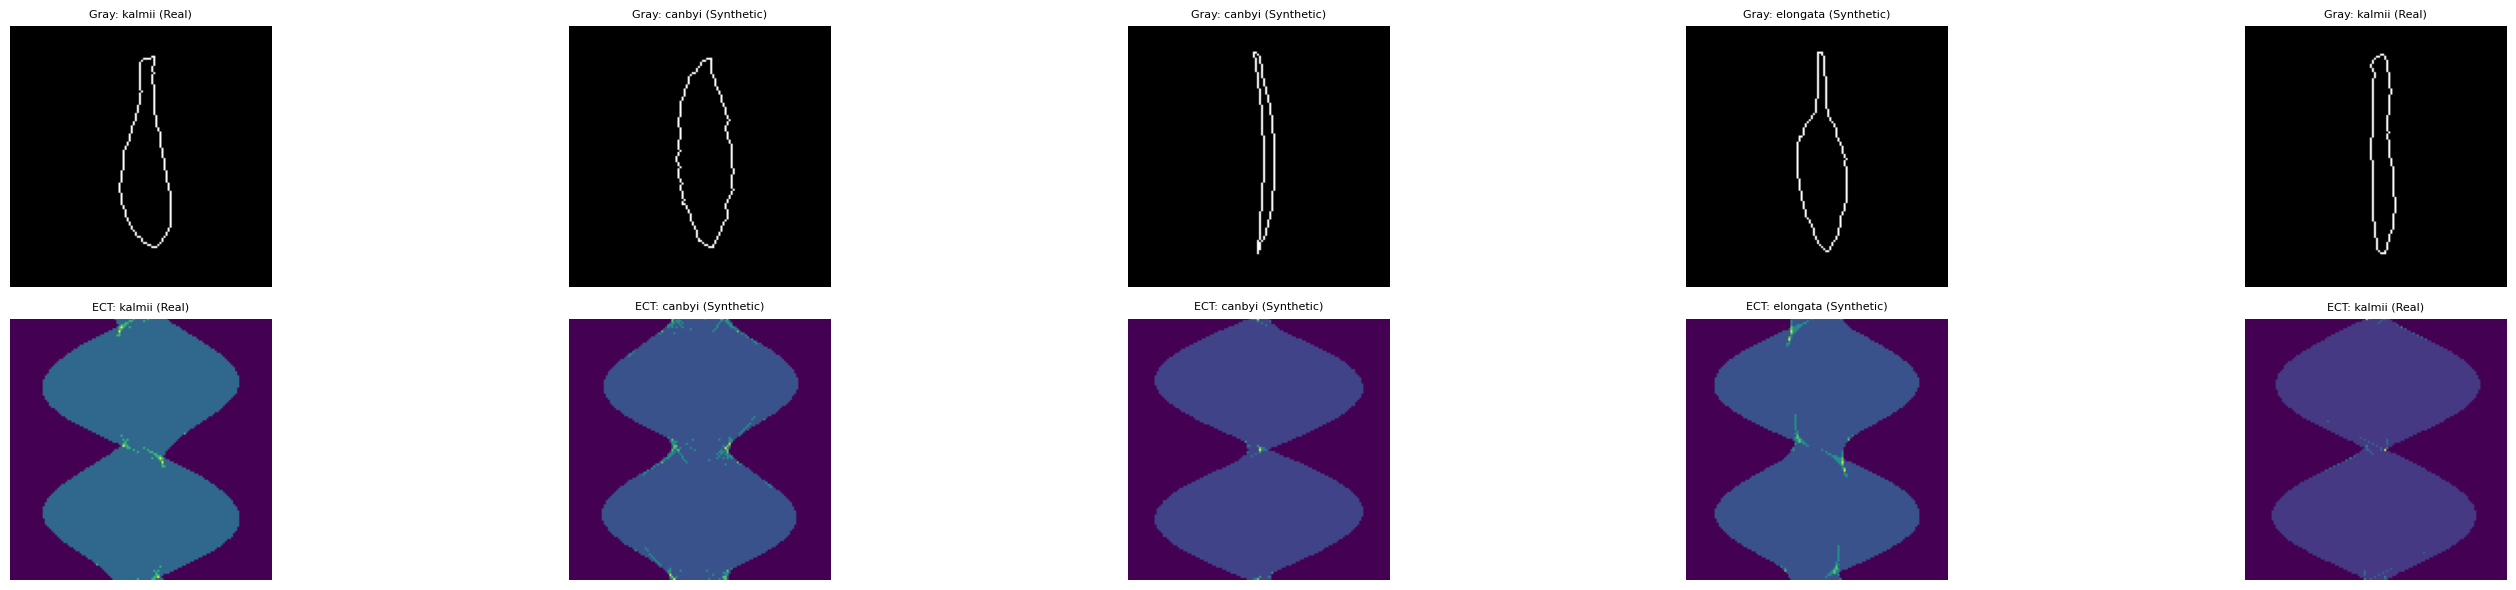

In [80]:
import numpy as np
import pandas as pd
import cv2 # OpenCV for image drawing
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns # For optional visualizations
import ect # For Euler Characteristic Transform
import networkx as nx # For graph representation in ECT

# --- Configuration for Data Generation (can be adjusted) ---
# NOTE: TARGET_COLUMN is now expected to be defined GLOBALLY BEFORE this block.
#       Do NOT uncomment and define it here unless you explicitly want to override
#       the global setting.
# TARGET_COLUMN = 'full_name' # THIS LINE IS NOW REMOVED/COMMENTED OUT

IMAGE_SIZE = 128            # Target size for generated images (e.g., 128x128 pixels)
PADDING = 10                # Pixels of padding around the leaf outline for image generation
# Target number of samples per class for augmentation.
# Setting it to `None` will use the maximum existing class count as the target.
# Set to a specific number (e.g., 180) to pad all classes up to that number.
MAX_SAMPLES_PER_CLASS_TARGET = None 

# --- Assume these are already loaded/defined in your notebook ---
# proc_arr: (N, 99, 2) numpy array (Original Procrustes coordinates)
# all_mdata: pandas DataFrame (Original metadata with 'full_name', 'PC1', 'PC2', etc.)
# Example placeholders (remove/comment out if your data is already loaded):
# proc_arr = np.random.rand(769, 99, 2) # Example (samples, landmarks, coords)
# all_mdata = pd.DataFrame({
#   'full_name': [f'Species_{i % 5}' for i in range(769)],
#   'type_name': [f'Type_{i % 3}' for i in range(769)],
#   'PC1': np.random.rand(769), 'PC2': np.random.rand(769)
# })


# Verify that TARGET_COLUMN is defined (should be from global scope)
if 'TARGET_COLUMN' not in globals():
    raise NameError("TARGET_COLUMN is not defined. Please define it at the top of your notebook.")

print(f"--- Starting Unified Augmented Data Generation for TARGET_COLUMN: '{TARGET_COLUMN}' ---")

# --- 1. Data Preparation (Original Data) ---
X_original_procrustes_flat = proc_arr.reshape(np.shape(proc_arr)[0], -1)
y_original_labels = all_mdata[TARGET_COLUMN].values

# Encode labels
label_encoder = LabelEncoder()
y_original_encoded = label_encoder.fit_transform(y_original_labels)
NUM_CLASSES = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_original_samples = X_original_procrustes_flat.shape[0]

print(f"Original data shape (flattened Procrustes): {X_original_procrustes_flat.shape}")
print(f"Number of original samples: {num_original_samples}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Original label counts:\n{pd.Series(y_original_labels).value_counts()}")


# --- 2. PCA for SMOTE-like Augmentation ---
# Re-initialize and fit PCA with maximum components (None means min(n_samples, n_features))
# This is CRITICAL for inverse_transform to work correctly later.
pca_full = PCA(n_components=None, random_state=42)
pca_full.fit(X_original_procrustes_flat)
X_pca_original_full = pca_full.transform(X_original_procrustes_flat)

print(f"\nShape of X_pca_original_full (after PCA transform): {X_pca_original_full.shape}")
print(f"Number of components in fitted PCA: {pca_full.n_components_}")


# --- 3. SMOTE-like Data Augmentation in FULL PCA space (198 components) ---
print("\n--- Performing SMOTE-like Data Augmentation ---")

class_counts_original = pd.Series(y_original_encoded).value_counts()
if MAX_SAMPLES_PER_CLASS_TARGET is None:
    max_samples_target = class_counts_original.max() # Target size for all classes based on majority
else:
    max_samples_target = MAX_SAMPLES_PER_CLASS_TARGET

augmented_X_pca_list = X_pca_original_full.tolist()
augmented_y_encoded_list = y_original_encoded.tolist()
is_real_flag_list = [True] * num_original_samples

for class_encoded, count in class_counts_original.items():
    if count < max_samples_target:
        samples_to_generate = max_samples_target - count
        class_name = label_encoder.inverse_transform([class_encoded])[0]
        print(f"Augmenting class '{class_name}' ({class_encoded}): generating {samples_to_generate} new samples.")

        class_indices = np.where(y_original_encoded == class_encoded)[0]
        class_pca_samples = X_pca_original_full[class_indices]

        # Use min(len(class_pca_samples), k+1) for n_neighbors, where k is desired neighbors.
        # Ensure at least 2 samples for KNN to make sense.
        n_neighbors_for_class = min(len(class_pca_samples), 6) # Using 6 to get 5 neighbors + self
        if n_neighbors_for_class < 2:
            print(f"Warning: Class '{class_name}' has too few samples ({len(class_pca_samples)}) for meaningful SMOTE-like augmentation. Skipping.")
            continue 

        nn = NearestNeighbors(n_neighbors=n_neighbors_for_class).fit(class_pca_samples)
        distances, indices = nn.kneighbors(class_pca_samples)

        generated_count = 0
        while generated_count < samples_to_generate:
            idx_in_class_pca_samples = np.random.randint(0, len(class_pca_samples))
            sample = class_pca_samples[idx_in_class_pca_samples]

            # Ensure there's at least one actual neighbor (index 0 is the sample itself)
            if len(indices[idx_in_class_pca_samples]) < 2:
                continue 
            
            # Select a random neighbor (excluding the sample itself)
            neighbor_idx_in_nn_output = np.random.randint(1, len(indices[idx_in_class_pca_samples]))
            neighbor_idx_in_class_pca = indices[idx_in_class_pca_samples][neighbor_idx_in_nn_output]
            neighbor = class_pca_samples[neighbor_idx_in_class_pca]

            alpha = np.random.rand() # Random value between 0 and 1
            synthetic_pca_sample = sample + alpha * (neighbor - sample)

            augmented_X_pca_list.append(synthetic_pca_sample)
            augmented_y_encoded_list.append(class_encoded)
            is_real_flag_list.append(False) # Mark as synthetic
            generated_count += 1

X_pca_augmented_full = np.array(augmented_X_pca_list)
y_augmented_encoded = np.array(augmented_y_encoded_list)
is_real_flag_augmented = np.array(is_real_flag_list)

# Inverse transform augmented PCA data back to original feature space (flattened Procrustes)
X_augmented_procrustes_flat = pca_full.inverse_transform(X_pca_augmented_full)

# Reshape augmented data back to 3D Procrustes coordinates (samples, landmarks, coords)
num_samples_total = X_augmented_procrustes_flat.shape[0]
num_landmarks = np.shape(proc_arr)[1] # Should be 99
num_coords = np.shape(proc_arr)[2]      # Should be 2
proc_arr_augmented_3d = X_augmented_procrustes_flat.reshape(num_samples_total, num_landmarks, num_coords)


print("--- SMOTE-like Data Augmentation Complete ---")
print(f"Total samples after SMOTE-like augmentation: {num_samples_total}")
print(f"Augmented label counts:\n{pd.Series(y_augmented_encoded).value_counts()}")
print(f"Shape of augmented Procrustes data (3D): {proc_arr_augmented_3d.shape}")
print(f"Shape of augmented real/synthetic flag: {is_real_flag_augmented.shape}")


# --- 4. Global Scaling for Image Generation (applied to ALL augmented data) ---

# Determine global min/max coordinates across ALL augmented leaves for consistent scaling
all_x_coords = proc_arr_augmented_3d[:, :, 0].flatten()
all_y_coords = proc_arr_augmented_3d[:, :, 1].flatten()

min_x, max_x = np.min(all_x_coords), np.max(all_x_coords)
min_y, max_y = np.min(all_y_coords), np.max(all_y_coords)

data_width = max_x - min_x
data_height = max_y - min_y

# Calculate scaling factor and offset to fit all data within the image size
scale_factor = min((IMAGE_SIZE - 2 * PADDING) / data_width, (IMAGE_SIZE - 2 * PADDING) / data_height)

# Offset to center the scaled data in the image
offset_x = (IMAGE_SIZE / 2) - (data_width / 2 * scale_factor) - (min_x * scale_factor)
offset_y = (IMAGE_SIZE / 2) - (data_height / 2 * scale_factor) - (min_y * scale_factor)

print(f"\nImage Generation Parameters: IMAGE_SIZE={IMAGE_SIZE}, PADDING={PADDING}")
print(f"Calculated scale_factor: {scale_factor:.4f}, offset_x: {offset_x:.4f}, offset_y: {offset_y:.4f}")


# --- 5. Image Generation Function (Grayscale Outline Images) ---
def create_leaf_image(coords_2d, img_size, scale_factor_val, offset_x_val, offset_y_val):
    """
    Creates a grayscale image of a leaf outline from 2D Procrustes coordinates.
    The coordinates are first scaled and offset globally.
    """
    image = np.zeros((img_size, img_size), dtype=np.uint8)

    scaled_coords = np.copy(coords_2d)

    scaled_coords[:, 0] = (scaled_coords[:, 0] * scale_factor_val) + offset_x_val
    scaled_coords[:, 1] = (scaled_coords[:, 1] * scale_factor_val) + offset_y_val

    pixel_coords = np.array(scaled_coords).astype(np.int32)

    # Clip coordinates to image boundaries to prevent drawing outside
    pixel_coords[:, 0] = np.clip(pixel_coords[:, 0], 0, img_size - 1)
    pixel_coords[:, 1] = np.clip(pixel_coords[:, 1], 0, img_size - 1)

    # Draw the polygon on the image
    cv2.polylines(image, [pixel_coords], isClosed=True, color=255, thickness=1)

    return image

print(f"\n--- Generating {len(proc_arr_augmented_3d)} Grayscale Leaf Images ---")
X_images_augmented_list = []
for i in range(len(proc_arr_augmented_3d)):
    leaf_coords = proc_arr_augmented_3d[i]
    img = create_leaf_image(leaf_coords, IMAGE_SIZE, scale_factor, offset_x, offset_y)
    X_images_augmented_list.append(img)

# Convert list of images to a single NumPy array and reshape for CNN input
X_images_augmented = np.array(X_images_augmented_list).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

print(f"Shape of generated grayscale image dataset (X_images_augmented): {X_images_augmented.shape}")


# --- 6. ECT Image Generation Function (from Procrustes Coordinates) ---
# This function will now accept the globally determined threshold_range_extent
def coords_to_ect_image(procrustes_coords_for_single_leaf, image_size, threshold_range_extent):
    # We are using Procrustes-aligned coordinates directly, as they are already
    # centered and globally scaled while preserving aspect ratio.
    
    if len(procrustes_coords_for_single_leaf) < 2: # Handle edge case for very few points
        return np.zeros((image_size, image_size), dtype=np.float32)

    G = nx.Graph()
    for i, (x, y) in enumerate(procrustes_coords_for_single_leaf):
        G.add_node(i, pos=(x, y))

    num_landmarks = procrustes_coords_for_single_leaf.shape[0]
    # Assuming points form a closed loop for a leaf outline
    for i in range(num_landmarks):
        G.add_edge(i, (i + 1) % num_landmarks)

    embedded_graph = ect.EmbeddedGraph()
    nodes_with_pos = {n: G.nodes[n]['pos'] for n in G.nodes()}
    embedded_graph.add_nodes_from_dict(nodes_with_pos)
    embedded_graph.add_edges_from(G.edges())

    thetas = np.linspace(0, 2 * np.pi, image_size, endpoint=False) # Angles for directions

    # ******************************************************************
    # CRITICAL: Define thresholds using the provided threshold_range_extent.
    # This range will be symmetric around 0, covering your Procrustes coordinates.
    thresholds = np.linspace(-threshold_range_extent, threshold_range_extent, image_size)
    # ******************************************************************

    direction_vectors = np.column_stack([np.cos(thetas), np.sin(thetas)])

    ect_calculator = ect.ECT(embedded_graph, direction_vectors, thresholds)
    ect_calculator.directions = ect.Directions.from_vectors(direction_vectors)
    ect_calculator.num_thresh = image_size
    ect_calculator.thresholds = thresholds

    ect_matrix = ect_calculator.calculate(embedded_graph)

    # Normalize ECT matrix to 0-1 range for image representation
    ect_min = np.min(ect_matrix)
    ect_max = np.max(ect_matrix)

    if ect_max == ect_min:
        normalized_ect = np.zeros((image_size, image_size), dtype=np.float32)
    else:
        normalized_ect = (ect_matrix - ect_min) / (ect_max - ect_min)

    return normalized_ect

print(f"\n--- Generating {len(proc_arr_augmented_3d)} ECT Images ---")

# --- MODIFICATION START ---
# Calculate the global ECT_THRESHOLD_EXTENT here, based on the augmented Procrustes data.
# This ensures consistency across all generated ECTs.
all_augmented_procrustes_coords_flat = proc_arr_augmented_3d.reshape(-1, 2)
max_abs_procrustes_val_augmented = np.max(np.abs(all_augmented_procrustes_coords_flat))
# Add a small buffer to ensure full coverage without clipping
ECT_THRESHOLD_EXTENT = max_abs_procrustes_val_augmented + 0.02 
print(f"Calculated ECT_THRESHOLD_EXTENT (based on augmented data): {ECT_THRESHOLD_EXTENT:.4f}")
# --- MODIFICATION END ---


X_ect_images_augmented_list = []
for i, procrustes_coords in enumerate(proc_arr_augmented_3d):
    # --- MODIFICATION START ---
    # Pass the calculated ECT_THRESHOLD_EXTENT to the function
    ect_img = coords_to_ect_image(procrustes_coords, IMAGE_SIZE, ECT_THRESHOLD_EXTENT)
    # --- MODIFICATION END ---
    X_ect_images_augmented_list.append(ect_img)

X_ect_images_augmented = np.array(X_ect_images_augmented_list, dtype=np.float32)

# Reshape for PyTorch CNN (num_samples, channels, height, width)
# Assuming ECT images are grayscale, so 1 channel
X_ect_images_augmented = X_ect_images_augmented.reshape(-1, 1, IMAGE_SIZE, IMAGE_SIZE)

print(f"Shape of generated ECT image dataset (X_ect_images_augmented): {X_ect_images_augmented.shape}")


# --- 7. Final Shuffling of All Augmented Data ---
# It's crucial to shuffle all datasets (images, ECT, labels, real_flag)
# with the same permutation to maintain correspondence.
print("\n--- Shuffling all augmented data consistently ---")
overall_shuffle_indices = np.random.permutation(num_samples_total)

proc_arr_augmented_3d_shuffled = proc_arr_augmented_3d[overall_shuffle_indices]
X_images_augmented_shuffled = X_images_augmented[overall_shuffle_indices]
X_ect_images_augmented_shuffled = X_ect_images_augmented[overall_shuffle_indices]
y_augmented_encoded_shuffled = y_augmented_encoded[overall_shuffle_indices]
is_real_flag_augmented_shuffled = is_real_flag_augmented[overall_shuffle_indices]

# Extract original samples' indices from the shuffled array for evaluation later
# This is used to filter out synthetic samples during evaluation for fairness.
# We need the original indices *before* shuffling to filter the original data.
# Then apply the overall_shuffle_indices to get their new positions.
original_sample_logical_indices_before_shuffle = np.array([True]*num_original_samples + [False]*(num_samples_total - num_original_samples))
original_real_shuffled_logical_indices = original_sample_logical_indices_before_shuffle[overall_shuffle_indices]

# Store the final data variables that subsequent CNNs will use
final_data = {
    'X_images': X_images_augmented_shuffled,
    'X_ect_images': X_ect_images_augmented_shuffled,
    'y_encoded': y_augmented_encoded_shuffled,
    'is_real_flag': is_real_flag_augmented_shuffled,
    'num_original_samples': num_original_samples, # Keep track of how many are real
    'label_encoder': label_encoder,
    'class_names': class_names,
    'image_size': IMAGE_SIZE,
    'original_real_shuffled_logical_indices': original_real_shuffled_logical_indices,
    'target_column_used': TARGET_COLUMN # Store the target column used for generation
}

print("\n--- Unified Augmented Data Generation Complete ---")
print("All generated and augmented data (images, ECT, labels, real/synthetic flags) are available in the 'final_data' dictionary.")

# --- Optional: Visualize a few generated images to verify ---
print("\n--- Displaying a few generated leaf images (Grayscale and ECT) ---")
num_display = min(5, final_data['X_images'].shape[0])
plt.figure(figsize=(num_display * 6, 6))

for i in range(num_display):
    # Grayscale Image
    plt.subplot(2, num_display, i + 1)
    plt.imshow(final_data['X_images'][i, :, :, 0], cmap='gray')
    current_label = final_data['label_encoder'].inverse_transform([final_data['y_encoded'][i]])[0]
    is_real = " (Real)" if final_data['is_real_flag'][i] else " (Synthetic)"
    plt.title(f"Gray: {current_label}{is_real}", fontsize=8)
    plt.axis('off')

    # ECT Image
    plt.subplot(2, num_display, i + 1 + num_display)
    plt.imshow(final_data['X_ect_images'][i, 0, :, :], cmap='viridis')
    plt.title(f"ECT: {current_label}{is_real}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

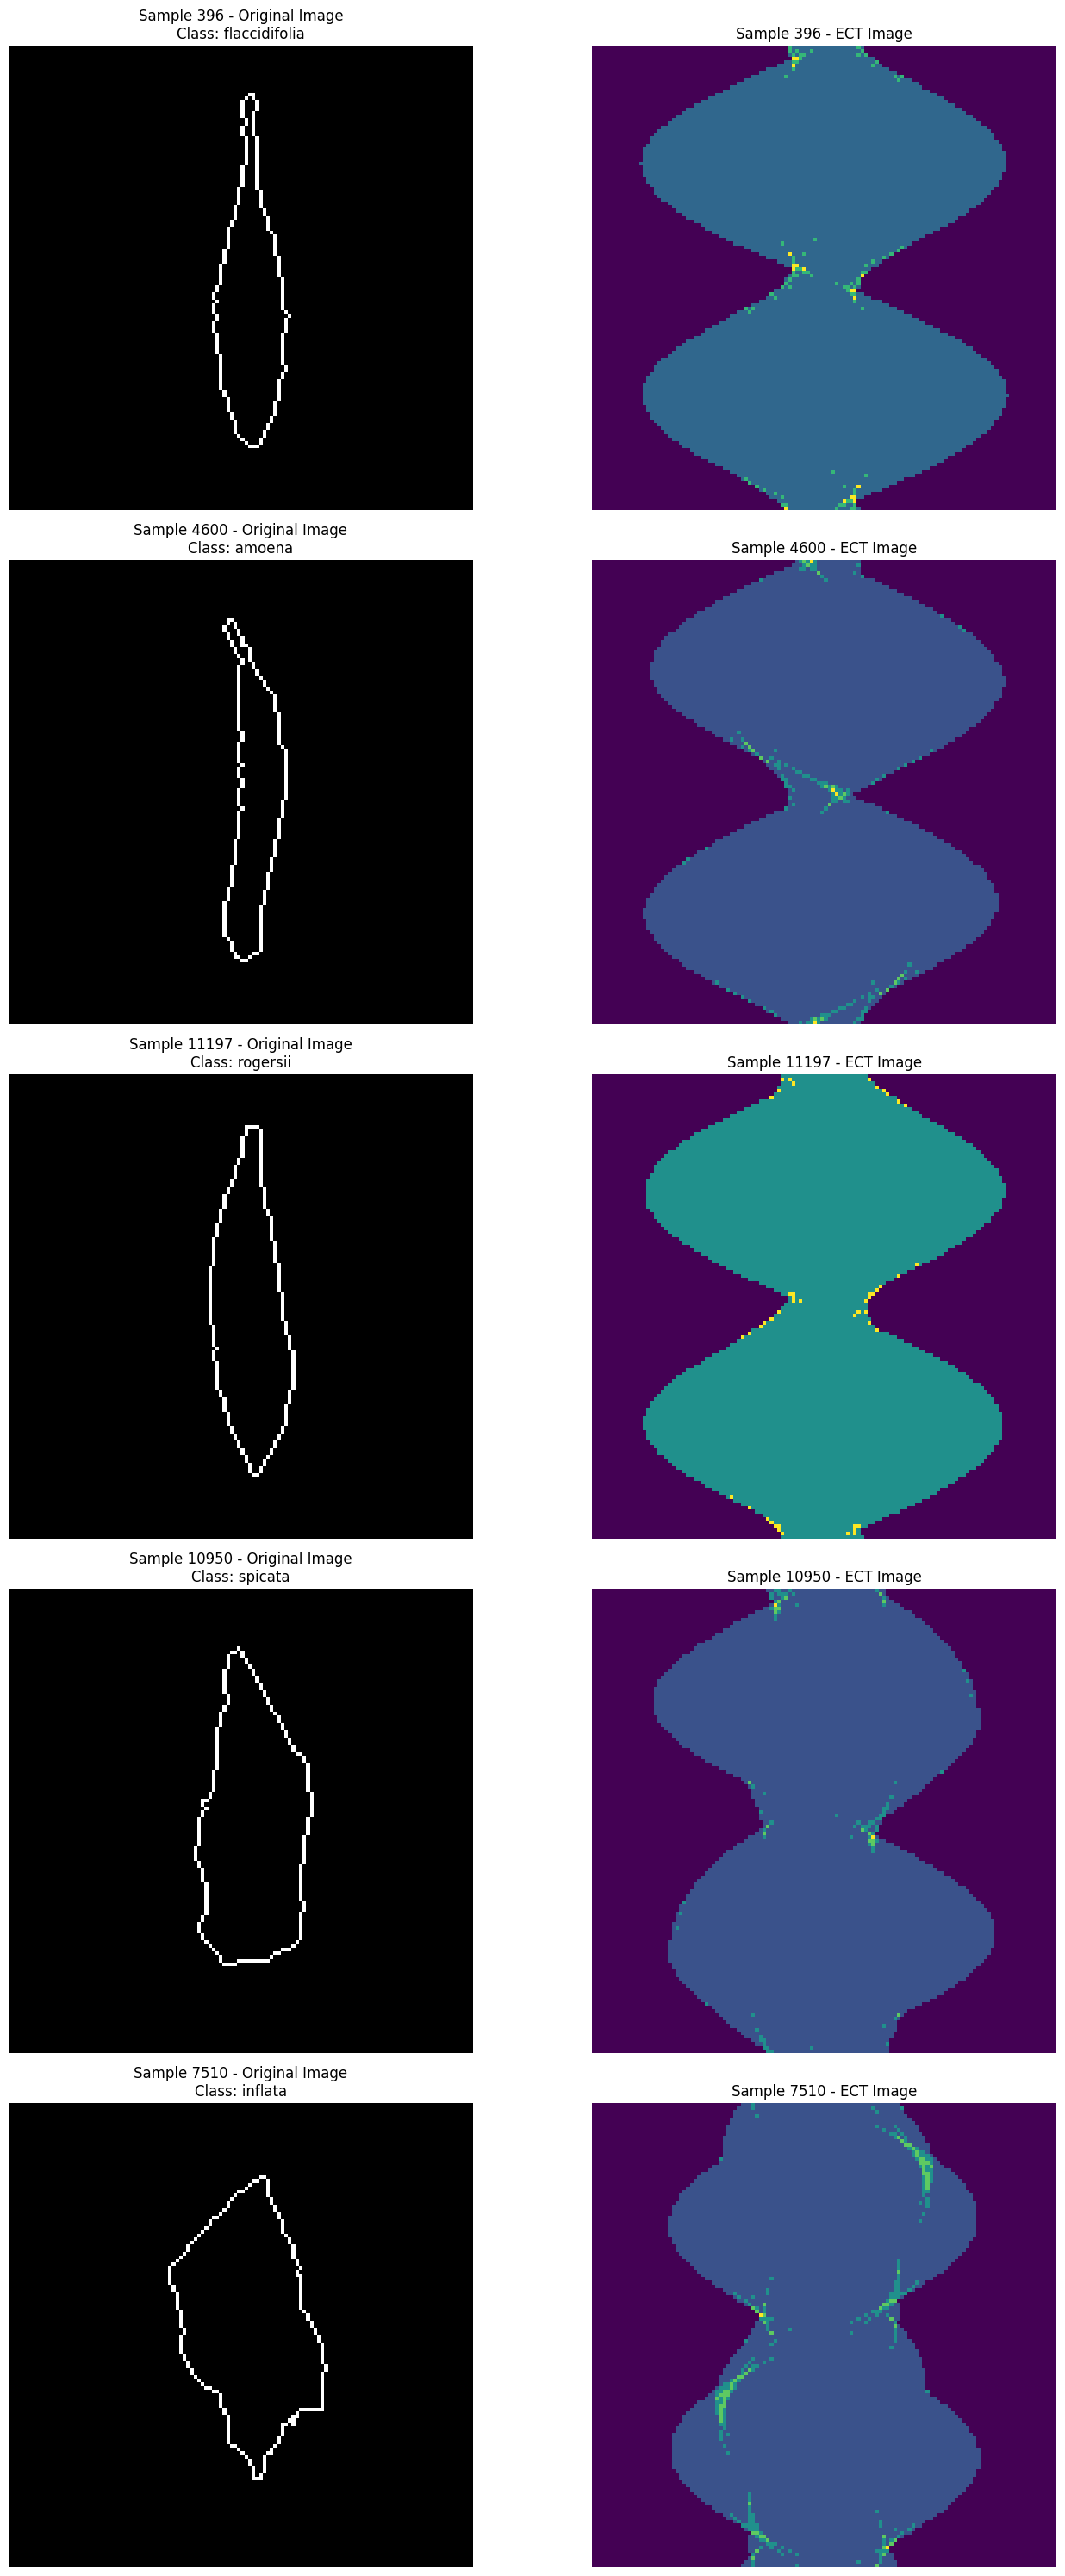

In [81]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset # Import Dataset class

# Assuming final_data is available from the Unified Augmented Data Generation block

try:
    X_images = final_data['X_images'] # Original grayscale images (N, H, W, C)
    X_ect_images = final_data['X_ect_images'] # ECT images (N, C, H, W)
    y_encoded = final_data['y_encoded']
    label_encoder = final_data['label_encoder']

    # Select a few random indices to visualize
    num_samples_to_show = 5
    random_indices = np.random.choice(X_images.shape[0], num_samples_to_show, replace=False)

    plt.figure(figsize=(15, 6 * num_samples_to_show))

    for i, idx in enumerate(random_indices):
        # Original Grayscale Image
        ax1 = plt.subplot(num_samples_to_show, 2, i * 2 + 1)
        # X_images is (N, H, W, C), so take the first channel
        img_display = X_images[idx, :, :, 0]
        ax1.imshow(img_display, cmap='gray')
        ax1.set_title(f"Sample {idx} - Original Image\nClass: {label_encoder.inverse_transform([y_encoded[idx]])[0]}")
        ax1.axis('off')

        # ECT Image
        ax2 = plt.subplot(num_samples_to_show, 2, i * 2 + 2)
        # X_ect_images is (N, C, H, W), so take the first channel
        ect_display = X_ect_images[idx, 0, :, :]
        ax2.imshow(ect_display, cmap='viridis') # Viridis or other colormaps often work well for ECTs
        ax2.set_title(f"Sample {idx} - ECT Image")
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

except NameError:
    print("Error: 'final_data' dictionary not found. Please ensure the 'Unified Augmented Data Generation' block has been run.")

## CNN on images

Using device: mps

--- Data Loaded from Unified Generation Block ---
Loaded image data shape: (11424, 128, 128, 1)
Number of classes: 21
Image size: 128x128
Data was generated using TARGET_COLUMN: 'species'
Tensor image data shape (after permute): torch.Size([11424, 1, 128, 128])

--- Performing PyTorch CNN with 5-Fold Stratified Cross-Validation (Image Data) ---

--- Fold 1/5 ---
  Epoch 1/50, Train Loss: 2.4148, Val Loss: 2.2303, Val Acc: 0.2644 (Real Samples)
  --> Saved best model for Fold 0 (Acc: 0.2644)
  --> Saved best model for Fold 0 (Acc: 0.3599)
  --> Saved best model for Fold 0 (Acc: 0.3978)
  --> Saved best model for Fold 0 (Acc: 0.4651)
  Epoch 5/50, Train Loss: 1.0058, Val Loss: 1.5412, Val Acc: 0.5104 (Real Samples)
  --> Saved best model for Fold 0 (Acc: 0.5104)
  --> Saved best model for Fold 0 (Acc: 0.5557)
  Epoch 10/50, Train Loss: 0.4766, Val Loss: 1.5121, Val Acc: 0.5802 (Real Samples)
  Epoch 15/50, Train Loss: 0.2824, Val Loss: 1.7993, Val Acc: 0.6034 (Real Sam

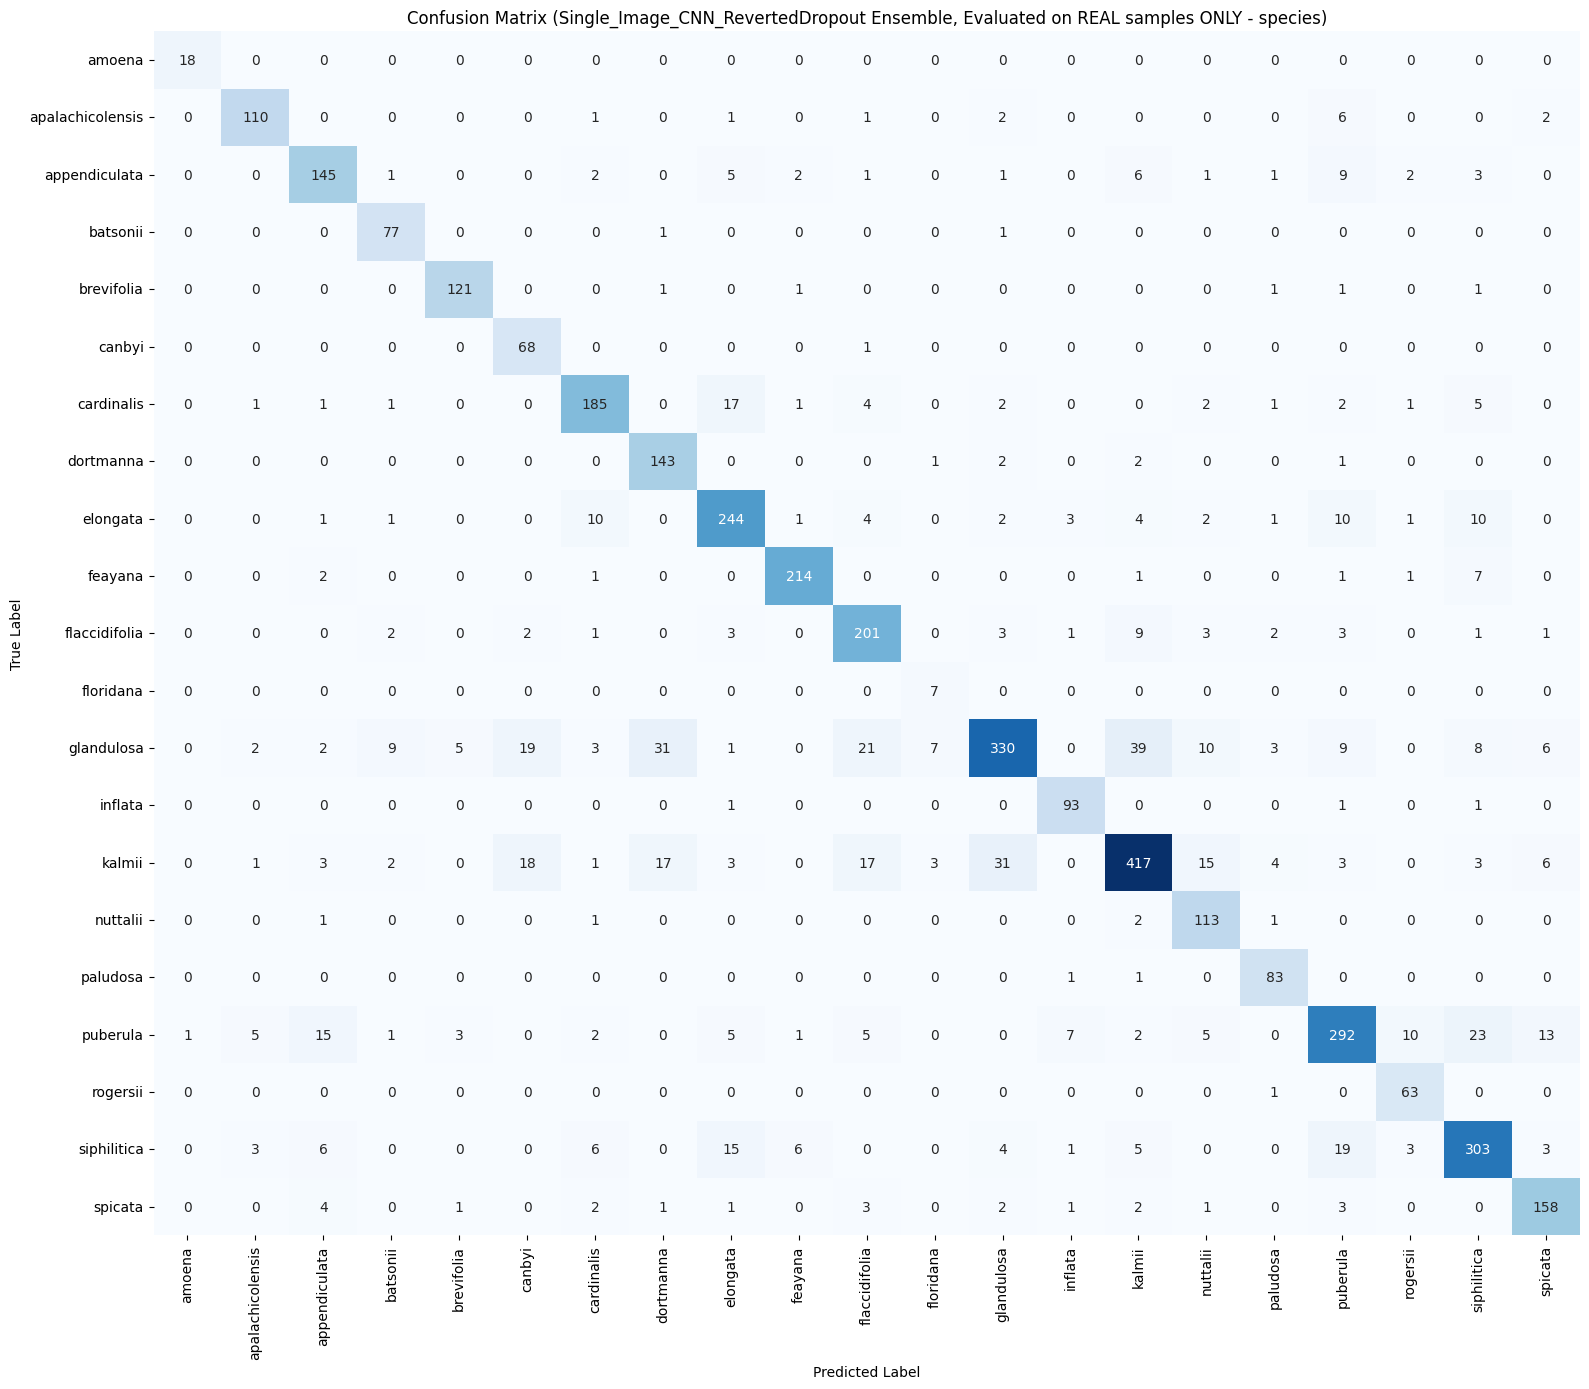

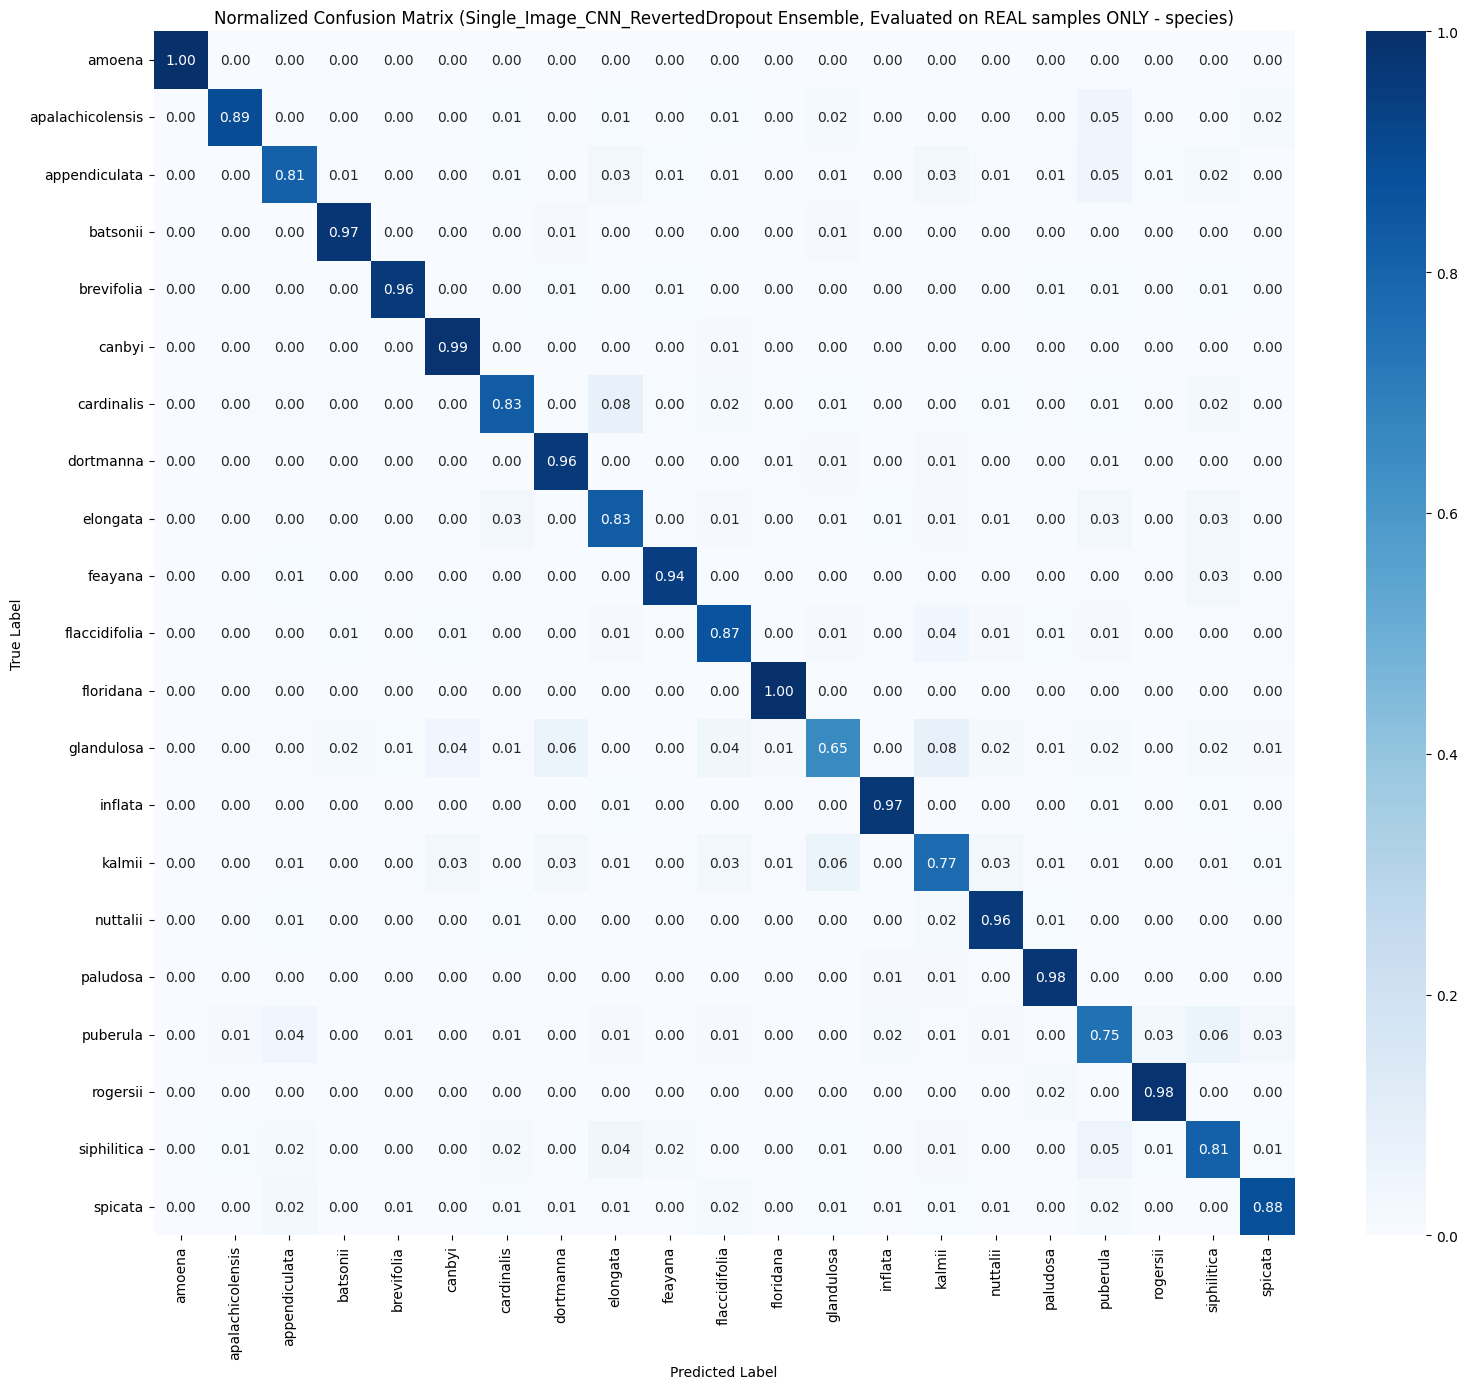

Global TARGET_COLUMN for this session: 'species'
Metrics for 'Single_Image_CNN_RevertedDropout' stored in results_storage for 'species'.

--- Current contents of results_storage (should include new model metrics) ---
{'species': {'class_counts': {'amoena': 18, 'apalachicolensis': 123, 'appendiculata': 179, 'batsonii': 79, 'brevifolia': 126, 'canbyi': 69, 'cardinalis': 223, 'dortmanna': 149, 'elongata': 294, 'feayana': 227, 'flaccidifolia': 232, 'floridana': 7, 'glandulosa': 505, 'inflata': 96, 'kalmii': 544, 'nuttalii': 118, 'paludosa': 85, 'puberula': 390, 'rogersii': 64, 'siphilitica': 374, 'spicata': 179}, 'model_metrics': {'unbalanced_lda': {'precision': {'amoena': 0.0, 'apalachicolensis': 0.15584415584415584, 'appendiculata': 0.2028985507246377, 'batsonii': 0.03571428571428571, 'brevifolia': 0.3793103448275862, 'canbyi': 0.22784810126582278, 'cardinalis': 0.305, 'dortmanna': 0.21359223300970873, 'elongata': 0.334384858044164, 'feayana': 0.3544973544973545, 'flaccidifolia': 0.12380

/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_34636/321750485.py:330: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_to_visualize_p

  Calculated average for class: 'amoena' (18 samples)
  Calculated average for class: 'apalachicolensis' (123 samples)
  Calculated average for class: 'appendiculata' (179 samples)
  Calculated average for class: 'batsonii' (79 samples)
  Calculated average for class: 'brevifolia' (126 samples)
  Calculated average for class: 'canbyi' (69 samples)
  Calculated average for class: 'cardinalis' (223 samples)
  Calculated average for class: 'dortmanna' (149 samples)
  Calculated average for class: 'elongata' (294 samples)
  Calculated average for class: 'feayana' (227 samples)
  Calculated average for class: 'flaccidifolia' (232 samples)
  Calculated average for class: 'floridana' (7 samples)
  Calculated average for class: 'glandulosa' (505 samples)
  Calculated average for class: 'inflata' (96 samples)
  Calculated average for class: 'kalmii' (544 samples)
  Calculated average for class: 'nuttalii' (118 samples)
  Calculated average for class: 'paludosa' (85 samples)
  Calculated average

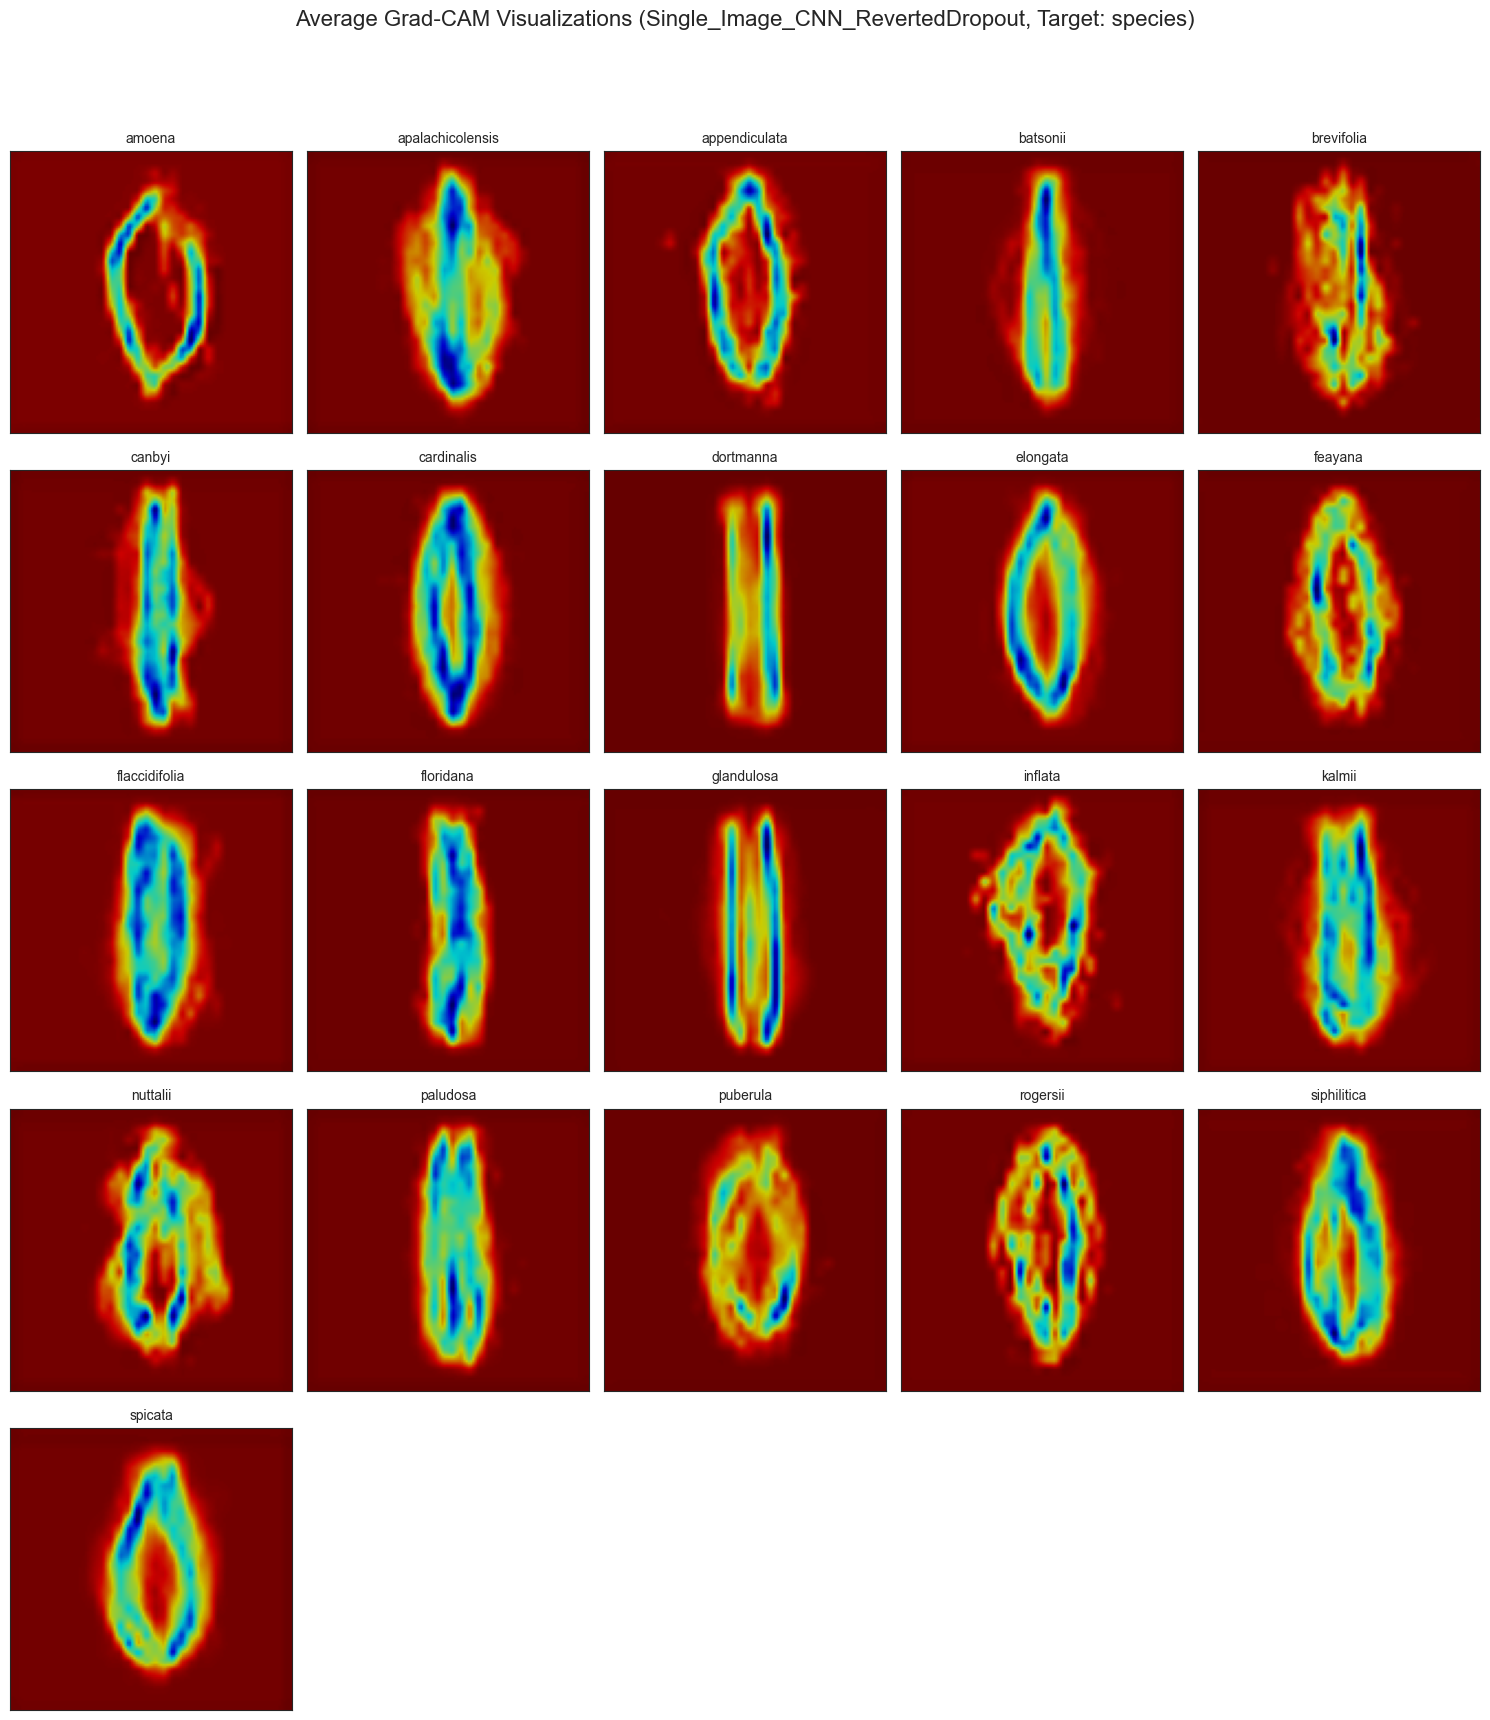

In [82]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os # Ensure os is imported for path handling

# PyTorch Imports
import torch
import torch.nn as tnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import copy
import cv2
from PIL import Image

# --- Configuration ---
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
K_FOLDS = 5
PATIENCE = 10
MODEL_IDENTIFIER = 'Single_Image_CNN_RevertedDropout'

# Grad-CAM specific configurations (not directly used for 'average' plot num samples, but useful for context)
NUM_SAMPLES_PER_CLASS_FOR_CAM_PLOT = 5 # This setting is less relevant now, as we average ALL real samples per class.


# Ensure MPS is available (or use CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load Data from Unified Generation Output ---
try:
    X_images_augmented_shuffled = final_data['X_images']
    y_augmented_encoded_shuffled = final_data['y_encoded']
    is_real_flag_augmented_shuffled = final_data['is_real_flag']
    label_encoder = final_data['label_encoder']
    class_names = final_data['class_names']
    num_classes = len(class_names)
    image_size = final_data['image_size']
    original_real_shuffled_logical_indices = final_data['original_real_shuffled_logical_indices']
    target_column_used_for_data = final_data['target_column_used']

    print(f"\n--- Data Loaded from Unified Generation Block ---")
    print(f"Loaded image data shape: {X_images_augmented_shuffled.shape}")
    print(f"Number of classes: {num_classes}")
    print(f"Image size: {image_size}x{image_size}")
    print(f"Data was generated using TARGET_COLUMN: '{target_column_used_for_data}'")

except NameError:
    print("Error: 'final_data' dictionary not found. Please run the 'Unified Augmented Data Generation' block first.")
    raise RuntimeError("Required data not found. Please execute the data generation cell.")


# --- PyTorch Data Preparation ---

X_images_tensor = torch.from_numpy(X_images_augmented_shuffled).float().permute(0, 3, 1, 2) / 255.0
y_encoded_tensor = torch.from_numpy(y_augmented_encoded_shuffled).long()
is_real_flag_tensor = torch.from_numpy(is_real_flag_augmented_shuffled).bool()

print(f"Tensor image data shape (after permute): {X_images_tensor.shape}")


class LeafDataset(Dataset):
    def __init__(self, images, labels, is_real_flags):
        self.images = images
        self.labels = labels
        self.is_real_flags = is_real_flags

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx], self.is_real_flags[idx]


class LeafCNN(tnn.Module):
    def __init__(self, num_classes, image_size):
        super(LeafCNN, self).__init__()
        self.features = tnn.Sequential(
            tnn.Conv2d(1, 32, kernel_size=3, padding=1), tnn.ReLU(), tnn.MaxPool2d(kernel_size=2, stride=2),
            tnn.Conv2d(32, 64, kernel_size=3, padding=1), tnn.ReLU(), tnn.MaxPool2d(kernel_size=2, stride=2),
            tnn.Conv2d(64, 128, kernel_size=3, padding=1), tnn.ReLU(), tnn.MaxPool2d(kernel_size=2, stride=2),
        )

        with torch.no_grad():
            temp_features_model = self.features.to(device)
            dummy_input = torch.zeros(1, 1, image_size, image_size).to(device)
            flattened_size = temp_features_model(dummy_input).view(1, -1).shape[1]
            temp_features_model.to("cpu")

        self.classifier = tnn.Sequential(
            tnn.Flatten(),
            tnn.Linear(flattened_size, 512),
            tnn.ReLU(),
            tnn.Dropout(0.5),
            tnn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# --- Model Saving Setup ---
MODEL_SAVE_DIR = "trained_models"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

def save_model_checkpoint(model, optimizer, epoch, accuracy, model_identifier, target_column, fold_idx):
    filepath = os.path.join(MODEL_SAVE_DIR, f"{model_identifier}_fold{fold_idx}_best_{target_column}.pth")
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy,
    }
    torch.save(state, filepath)
    print(f"  --> Saved best model for Fold {fold_idx} (Acc: {accuracy:.4f})")


# --- PyTorch CNN Training and Evaluation with Stratified K-Fold (Evaluate on REAL samples ONLY) ---

print(f"\n--- Performing PyTorch CNN with {K_FOLDS}-Fold Stratified Cross-Validation (Image Data) ---")

real_original_indices_global = torch.where(is_real_flag_tensor)[0].cpu().numpy()

X_original_images_for_skf = X_images_tensor[real_original_indices_global]
y_original_for_skf = y_encoded_tensor[real_original_indices_global]

skf_pytorch = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

all_predictions_logits = []
all_true_labels_real_validation = []

saved_model_paths_per_fold = [None] * K_FOLDS # Pre-allocate list to store paths for each fold

for fold_idx, (train_original_real_indices, val_original_real_indices) in enumerate(skf_pytorch.split(X_original_images_for_skf.cpu().numpy(), y_original_for_skf.cpu().numpy())):
    print(f"\n--- Fold {fold_idx + 1}/{K_FOLDS} ---")

    X_val_img_fold = X_original_images_for_skf[val_original_real_indices]
    y_val_fold = y_original_for_skf[val_original_real_indices]
    val_dataset = LeafDataset(X_val_img_fold, y_val_fold, torch.ones_like(y_val_fold, dtype=torch.bool))
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    synthetic_indices = torch.where(~is_real_flag_tensor)[0].cpu().numpy()
    global_real_train_indices = real_original_indices_global[train_original_real_indices]
    all_training_indices_global = np.concatenate((global_real_train_indices, synthetic_indices))

    X_train_img_fold_tensor = X_images_tensor[all_training_indices_global]
    y_train_fold_tensor = y_encoded_tensor[all_training_indices_global]
    is_real_train_fold_tensor = is_real_flag_tensor[all_training_indices_global]

    train_dataset = LeafDataset(X_train_img_fold_tensor, y_train_fold_tensor, is_real_train_fold_tensor)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)


    model = LeafCNN(num_classes=num_classes, image_size=image_size).to(device)
    criterion = tnn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_overall_accuracy_for_saving_this_fold = 0.0

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        model.eval()
        val_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        current_overall_accuracy_on_real_samples = 0.0

        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

            avg_train_loss = running_loss / len(train_loader.dataset)
            avg_val_loss = val_loss / len(val_loader.dataset)
            val_accuracy = correct_predictions / total_samples

            current_overall_accuracy_on_real_samples = val_accuracy

            if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == NUM_EPOCHS -1:
                print(f"  Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f} (Real Samples)")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0

            if current_overall_accuracy_on_real_samples > best_overall_accuracy_for_saving_this_fold:
                best_overall_accuracy_for_saving_this_fold = current_overall_accuracy_on_real_samples
                save_model_checkpoint(model, optimizer, epoch, best_overall_accuracy_for_saving_this_fold, MODEL_IDENTIFIER, target_column_used_for_data, fold_idx)
                saved_model_paths_per_fold[fold_idx] = os.path.join(MODEL_SAVE_DIR, f"{MODEL_IDENTIFIER}_fold{fold_idx}_best_{target_column_used_for_data}.pth")

        else:
            epochs_no_improve += 1
            if epochs_no_improve == PATIENCE:
                print(f"  Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
                break

    model.load_state_dict(best_model_wts)
    print(f"Fold {fold_idx + 1} training complete. Best validation loss for fold: {best_val_loss:.4f}")


    model.eval()
    fold_predictions_logits = []

    real_dataset_for_pred = LeafDataset(X_original_images_for_skf, y_original_for_skf, torch.ones_like(y_original_for_skf, dtype=torch.bool))
    real_loader_for_pred = DataLoader(real_dataset_for_pred, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    with torch.no_grad():
        for images_batch, labels_batch, _ in real_loader_for_pred:
            images_batch = images_batch.to(device)
            outputs = model(images_batch)
            fold_predictions_logits.append(outputs.cpu().numpy())

    all_predictions_logits.append(np.concatenate(fold_predictions_logits, axis=0))


# --- Final Evaluation on REAL samples Only (using ensemble of fold models) ---

averaged_logits = np.mean(np.array(all_predictions_logits), axis=0)
final_predictions_encoded = np.argmax(averaged_logits, axis=1)
final_true_labels_encoded = y_original_for_skf.cpu().numpy()

final_true_labels_names = label_encoder.inverse_transform(final_true_labels_encoded)
final_predictions_names = label_encoder.inverse_transform(final_predictions_encoded)

overall_accuracy_real_pt = accuracy_score(final_true_labels_names, final_predictions_names)
print(f"\n--- Overall Accuracy ({MODEL_IDENTIFIER} Ensemble, Evaluated on REAL samples ONLY - {target_column_used_for_data}): {overall_accuracy_real_pt:.4f} ---")

print(f"\n--- Classification Report ({MODEL_IDENTIFIER} Ensemble, Evaluated on REAL samples ONLY - {target_column_used_for_data}) ---")
report_dict = classification_report(final_true_labels_names, final_predictions_names, target_names=class_names, zero_division=0, output_dict=True)
print(classification_report(final_true_labels_names, final_predictions_names, target_names=class_names, zero_division=0))

cm_real_pt = confusion_matrix(final_true_labels_names, final_predictions_names, labels=class_names)

plt.figure(figsize=(16, 14))
sns.heatmap(cm_real_pt, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix ({MODEL_IDENTIFIER} Ensemble, Evaluated on REAL samples ONLY - {target_column_used_for_data})')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

cm_normalized_real_pt = cm_real_pt.astype('float') / cm_real_pt.sum(axis=1)[:, np.newaxis]
cm_normalized_real_pt[np.isnan(cm_normalized_real_pt)] = 0

plt.figure(figsize=(16, 14))
sns.heatmap(cm_normalized_real_pt, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Normalized Confusion Matrix ({MODEL_IDENTIFIER} Ensemble, Evaluated on REAL samples ONLY - {target_column_used_for_data})')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

TARGET_COLUMN = target_column_used_for_data

if 'results_storage' not in globals():
    results_storage = {}
if TARGET_COLUMN not in results_storage:
    results_storage[TARGET_COLUMN] = {
        'class_counts': {},
        'model_metrics': {}
    }
print(f"Global TARGET_COLUMN for this session: '{TARGET_COLUMN}'")

MODEL_NAME = MODEL_IDENTIFIER
if TARGET_COLUMN not in results_storage:
    results_storage[TARGET_COLUMN] = {'class_counts': {}, 'model_metrics': {}}

if not results_storage[TARGET_COLUMN]['class_counts']:
    class_counts_series = pd.Series(final_true_labels_encoded).value_counts().sort_index()
    for encoded_label, count in class_counts_series.items():
        class_name_str = label_encoder.inverse_transform([encoded_label])[0]
        results_storage[TARGET_COLUMN]['class_counts'][class_name_str] = count
    print(f"Class counts populated for '{TARGET_COLUMN}'.")

results_storage[TARGET_COLUMN]['model_metrics'][MODEL_NAME] = {
    'precision': {cls: report_dict[cls]['precision'] for cls in class_names},
    'recall': {cls: report_dict[cls]['recall'] for cls in class_names}
}
print(f"Metrics for '{MODEL_NAME}' stored in results_storage for '{TARGET_COLUMN}'.")

print("\n--- Current contents of results_storage (should include new model metrics) ---")
print(results_storage)


# --- Grad-CAM Visualization: Average Heatmap per Class ---

print(f"\n--- Generating Average Grad-CAM Visualizations for {MODEL_IDENTIFIER} (Model from Fold 0) ---")

# Choose which saved model to load for Grad-CAM.
# We'll pick the model saved from the first fold (fold_idx=0).
if len(saved_model_paths_per_fold) <= 0 or saved_model_paths_per_fold[0] is None or not os.path.exists(saved_model_paths_per_fold[0]):
    print(f"Error: Model file for Fold 0 not found or not saved at {saved_model_paths_per_fold[0] if len(saved_model_paths_per_fold) > 0 else 'N/A'}. Skipping Grad-CAM visualization.")
else:
    model_to_visualize_path = saved_model_paths_per_fold[0]

    cam_model = LeafCNN(num_classes=num_classes, image_size=image_size).to(device)
    checkpoint = torch.load(model_to_visualize_path, map_location=device)
    cam_model.load_state_dict(checkpoint['model_state_dict'])
    cam_model.eval()

    target_layer = cam_model.features[-3]


    class GradCAM:
        def __init__(self, model, target_layer):
            self.model = model
            self.target_layer = target_layer
            self.gradients = None
            self.activations = None

            found_layer = False
            for name, module in self.model.named_modules():
                if module is self.target_layer:
                    module.register_forward_hook(self._save_activation)
                    module.register_backward_hook(self._save_gradient)
                    found_layer = True
                    break
            if not found_layer:
                raise ValueError(f"Target layer {target_layer} not found in model named modules.")


        def _save_activation(self, module, input, output):
            self.activations = output

        def _save_gradient(self, module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def __call__(self, input_tensor, target_class=None):
            self.model.zero_grad()
            output = self.model(input_tensor)
            
            if target_class is None:
                target_class = output.argmax(dim=1).item()

            one_hot = torch.zeros_like(output).to(device)
            one_hot[0][target_class] = 1
            output.backward(gradient=one_hot, retain_graph=True)

            gradients = self.gradients[0].cpu().data.numpy()
            activations = self.activations[0].cpu().data.numpy()

            weights = np.mean(gradients, axis=(1, 2))
            cam = np.zeros(activations.shape[1:], dtype=np.float32)

            for i, w in enumerate(weights):
                cam += w * activations[i]

            cam = np.maximum(cam, 0)
            cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))
            # No normalization here yet, as we will average multiple cams first
            return cam

    # --- MODIFIED: show_cam_on_image for a black background ---
    def show_cam_on_black_background(cam_heatmap, img_size):
        # cam_heatmap: numpy array (H, W) normalized 0-1
        # img_size: size of the original image (e.g., 64)
        
        # Create a black background image of the correct size
        # Assuming grayscale images, so 3 channels for color mapping
        black_background = np.zeros((img_size, img_size, 3), dtype=np.uint8)

        # Apply colormap to heatmap
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * cam_heatmap), cv2.COLORMAP_JET)
        heatmap_colored = np.float32(heatmap_colored) / 255 # Normalize to 0-1

        # Blend heatmap onto the black background. Adjust alpha for intensity.
        # Here, we directly overlay the heatmap, no need for original image.
        alpha = 0.8 # Controls the intensity/opacity of the heatmap. Adjust as desired.
        final_cam_img = np.uint8(255 * (heatmap_colored * alpha + np.float32(black_background) / 255 * (1-alpha)))

        return final_cam_img


    # --- Calculate Average Grad-CAM for Each Class ---
    grad_cam = GradCAM(cam_model, target_layer)
    average_class_heatmaps = {} # Stores (class_idx: average_heatmap_numpy)

    real_indices_by_class = {cls_idx: [] for cls_idx in range(num_classes)}
    for idx in real_original_indices_global: # Use original real indices
        class_label = y_encoded_tensor[idx].item()
        real_indices_by_class[class_label].append(idx)

    print("Calculating average Grad-CAM heatmaps per class...")
    for class_idx in range(num_classes):
        class_name = class_names[class_idx]
        class_samples_indices = real_indices_by_class[class_idx]

        if not class_samples_indices:
            print(f"  No real samples for class '{class_name}'. Skipping average Grad-CAM.")
            average_class_heatmaps[class_idx] = None # Mark as None if no samples
            continue

        summed_heatmap = np.zeros((image_size, image_size), dtype=np.float32)
        count_for_average = 0

        for sample_idx in class_samples_indices:
            image_tensor = X_images_tensor[sample_idx]
            input_image_for_cam = image_tensor.unsqueeze(0).to(device)

            # Generate heatmap (don't normalize to 0-1 yet inside GradCAM.__call__)
            heatmap = grad_cam(input_image_for_cam, target_class=class_idx)
            
            summed_heatmap += heatmap
            count_for_average += 1
        
        if count_for_average > 0:
            avg_heatmap = summed_heatmap / count_for_average
            # Normalize the average heatmap to 0-1 range for display
            avg_heatmap = avg_heatmap - np.min(avg_heatmap)
            if np.max(avg_heatmap) == 0:
                avg_heatmap = np.zeros_like(avg_heatmap)
            else:
                avg_heatmap = avg_heatmap / np.max(avg_heatmap)
            average_class_heatmaps[class_idx] = avg_heatmap
            print(f"  Calculated average for class: '{class_name}' ({count_for_average} samples)")
        else:
            average_class_heatmaps[class_idx] = None


    # --- Plotting Average Grad-CAMs in a Grid ---

    # Determine grid dimensions for the single plot (e.g., 4x5 or 5x4 for 20 classes)
    # Aim for a somewhat square layout
    num_plots_total = num_classes
    num_cols_grid = math.ceil(math.sqrt(num_plots_total))
    num_rows_grid = math.ceil(num_plots_total / num_cols_grid)

    # Adjust fig_size for aesthetics
    # Each average image will be distinct and needs reasonable size
    fig_width = num_cols_grid * 3.0 # 3.0 inches per column
    fig_height = num_rows_grid * 3.5 # 3.5 inches per row (more for title)

    sns.set_style("white")
    plt.rcParams.update({'font.size': 10})

    fig, axes = plt.subplots(num_rows_grid, num_cols_grid, figsize=(fig_width, fig_height), squeeze=False)
    axes = axes.flatten() # Flatten for easy iteration

    print(f"\nPlotting average Grad-CAMs in a {num_rows_grid}x{num_cols_grid} grid...")

    for i in range(num_classes):
        ax = axes[i]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(class_names[i], fontsize=10) # Label with class name

        avg_heatmap = average_class_heatmaps[i]
        if avg_heatmap is not None:
            cam_image_on_black = show_cam_on_black_background(avg_heatmap, image_size)
            ax.imshow(cam_image_on_black)
        else:
            ax.text(0.5, 0.5, 'No Samples', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='gray', fontsize=10)


    # Hide any unused subplots
    for j in range(num_classes, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'Average Grad-CAM Visualizations ({MODEL_IDENTIFIER}, Target: {target_column_used_for_data})', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig(os.path.join(MODEL_SAVE_DIR, f"{MODEL_IDENTIFIER}_AverageGradCAM_{target_column_used_for_data}.png"), dpi=300)
    plt.show()

## CNN on ECTs

Using device: mps

--- Data Loaded from Unified Generation Block for ECT CNN ---
Loaded ECT image data shape: (11424, 1, 128, 128)
Number of classes: 21
Image size: 128x128
Data was generated using TARGET_COLUMN: 'species'
Tensor ECT image data shape: torch.Size([11424, 1, 128, 128])

--- Performing PyTorch CNN with 5-Fold Stratified Cross-Validation (ECT Image Data) ---

--- Fold 1/5 ---
  Epoch 1/50, Train Loss: 2.6316, Val Loss: 2.4070, Val Acc: 0.2277 (Real Samples)
  --> Saved best model for Fold 0 (Acc: 0.2277)
  --> Saved best model for Fold 0 (Acc: 0.2791)
  --> Saved best model for Fold 0 (Acc: 0.3464)
  --> Saved best model for Fold 0 (Acc: 0.3586)
  Epoch 5/50, Train Loss: 1.5650, Val Loss: 1.8220, Val Acc: 0.4027 (Real Samples)
  --> Saved best model for Fold 0 (Acc: 0.4027)
  --> Saved best model for Fold 0 (Acc: 0.4370)
  Epoch 10/50, Train Loss: 1.0829, Val Loss: 1.7800, Val Acc: 0.4676 (Real Samples)
  --> Saved best model for Fold 0 (Acc: 0.5018)
  Epoch 15/50, Train L

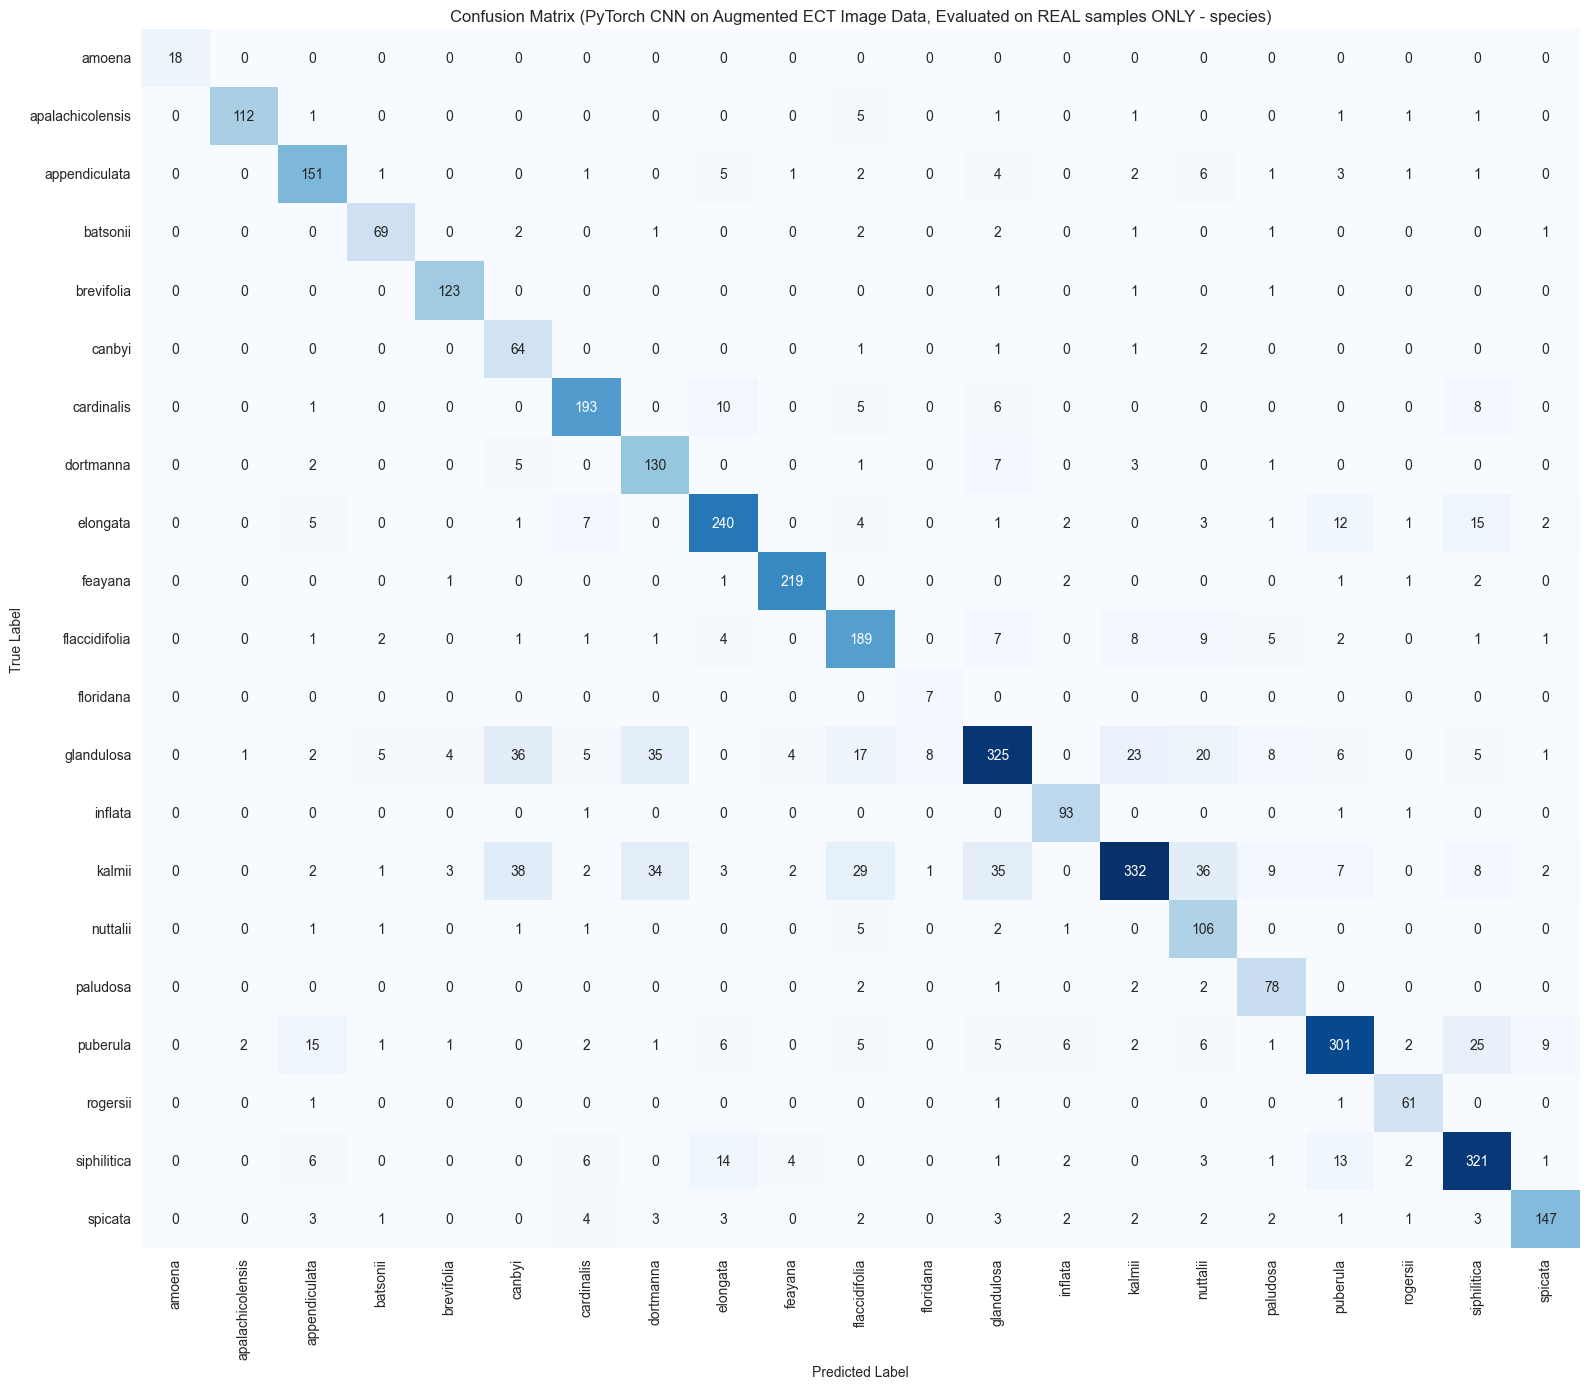

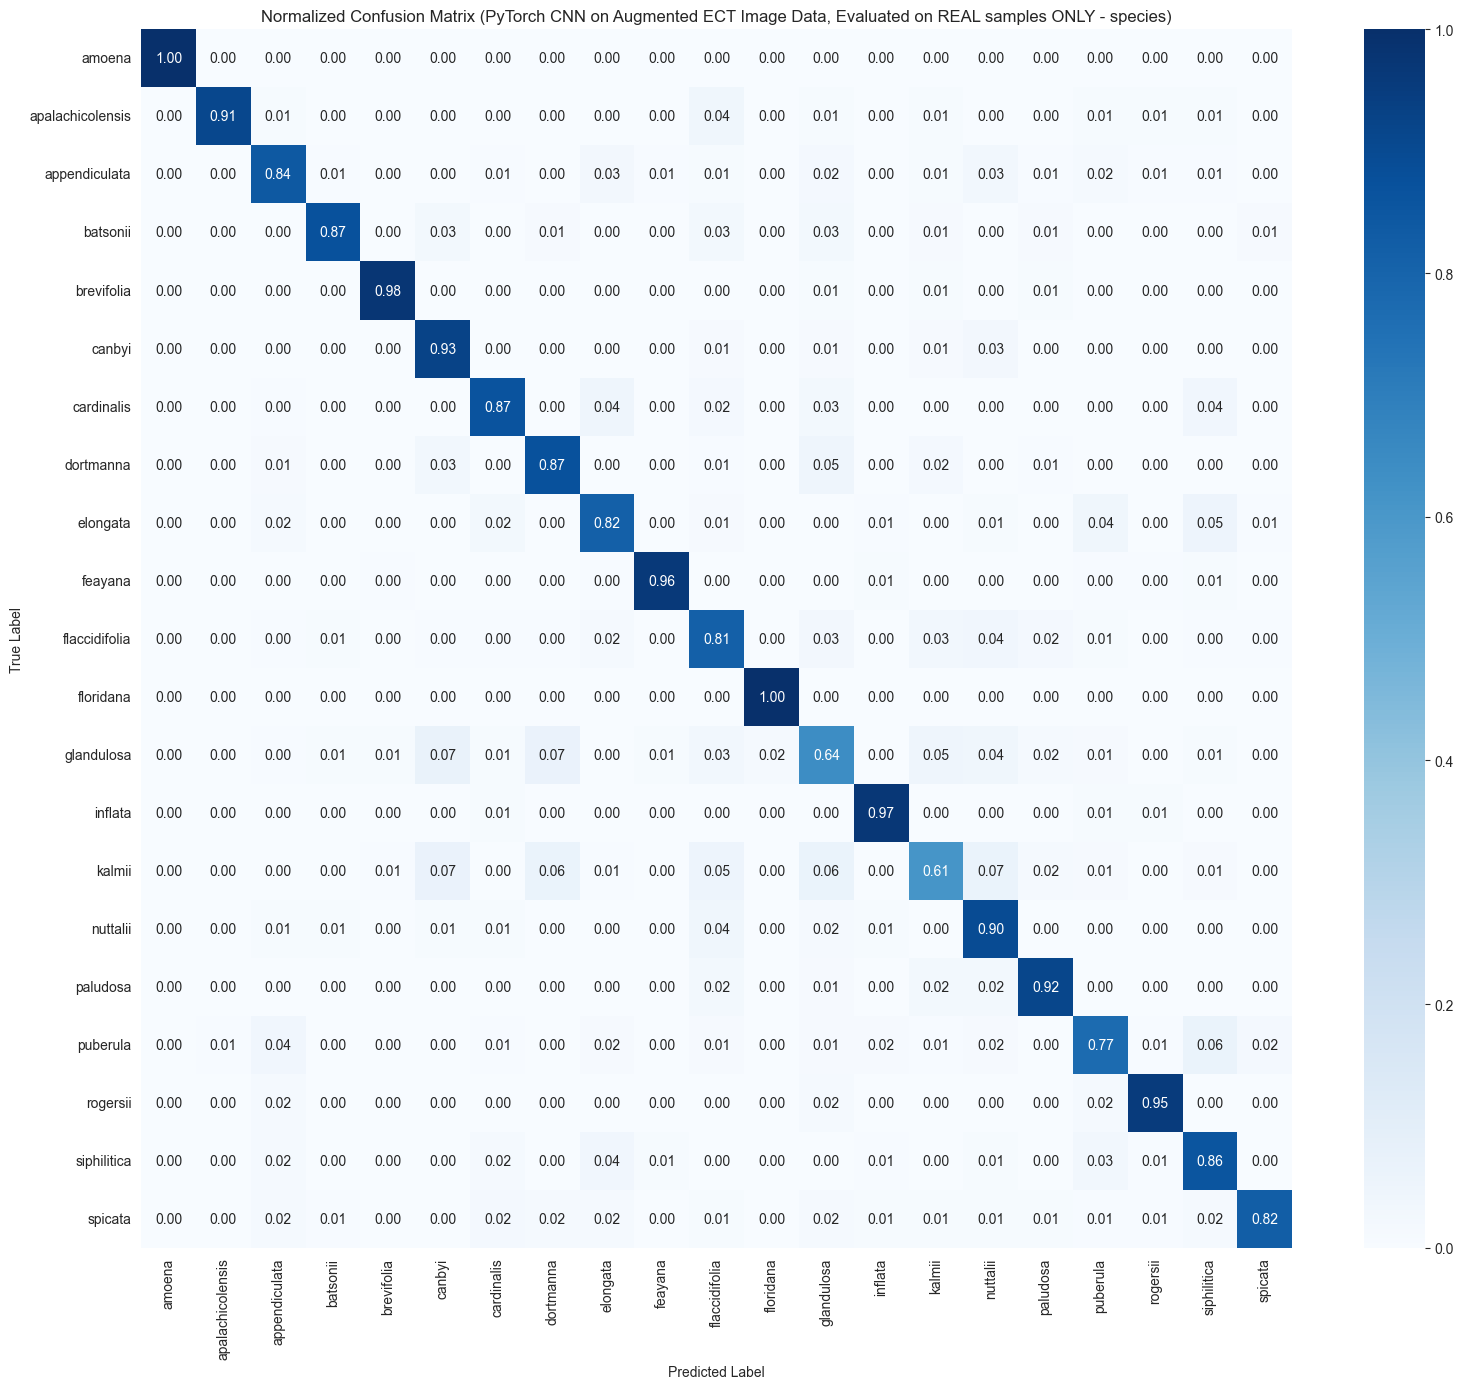

Metrics for 'Single_ECT_CNN_RevertedDropout' stored in results_storage for 'species'.

--- Current contents of results_storage (should include new model metrics) ---
{'species': {'class_counts': {'amoena': 18, 'apalachicolensis': 123, 'appendiculata': 179, 'batsonii': 79, 'brevifolia': 126, 'canbyi': 69, 'cardinalis': 223, 'dortmanna': 149, 'elongata': 294, 'feayana': 227, 'flaccidifolia': 232, 'floridana': 7, 'glandulosa': 505, 'inflata': 96, 'kalmii': 544, 'nuttalii': 118, 'paludosa': 85, 'puberula': 390, 'rogersii': 64, 'siphilitica': 374, 'spicata': 179}, 'model_metrics': {'unbalanced_lda': {'precision': {'amoena': 0.0, 'apalachicolensis': 0.15584415584415584, 'appendiculata': 0.2028985507246377, 'batsonii': 0.03571428571428571, 'brevifolia': 0.3793103448275862, 'canbyi': 0.22784810126582278, 'cardinalis': 0.305, 'dortmanna': 0.21359223300970873, 'elongata': 0.334384858044164, 'feayana': 0.3544973544973545, 'flaccidifolia': 0.12380952380952381, 'floridana': 0.0, 'glandulosa': 0.375

/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_34636/3783208692.py:360: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_to_visualize_

  Calculated average for class: 'amoena' (18 samples)
  Calculated average for class: 'apalachicolensis' (123 samples)
  Calculated average for class: 'appendiculata' (179 samples)
  Calculated average for class: 'batsonii' (79 samples)
  Calculated average for class: 'brevifolia' (126 samples)
  Calculated average for class: 'canbyi' (69 samples)
  Calculated average for class: 'cardinalis' (223 samples)
  Calculated average for class: 'dortmanna' (149 samples)
  Calculated average for class: 'elongata' (294 samples)
  Calculated average for class: 'feayana' (227 samples)
  Calculated average for class: 'flaccidifolia' (232 samples)
  Calculated average for class: 'floridana' (7 samples)
  Calculated average for class: 'glandulosa' (505 samples)
  Calculated average for class: 'inflata' (96 samples)
  Calculated average for class: 'kalmii' (544 samples)
  Calculated average for class: 'nuttalii' (118 samples)
  Calculated average for class: 'paludosa' (85 samples)
  Calculated average

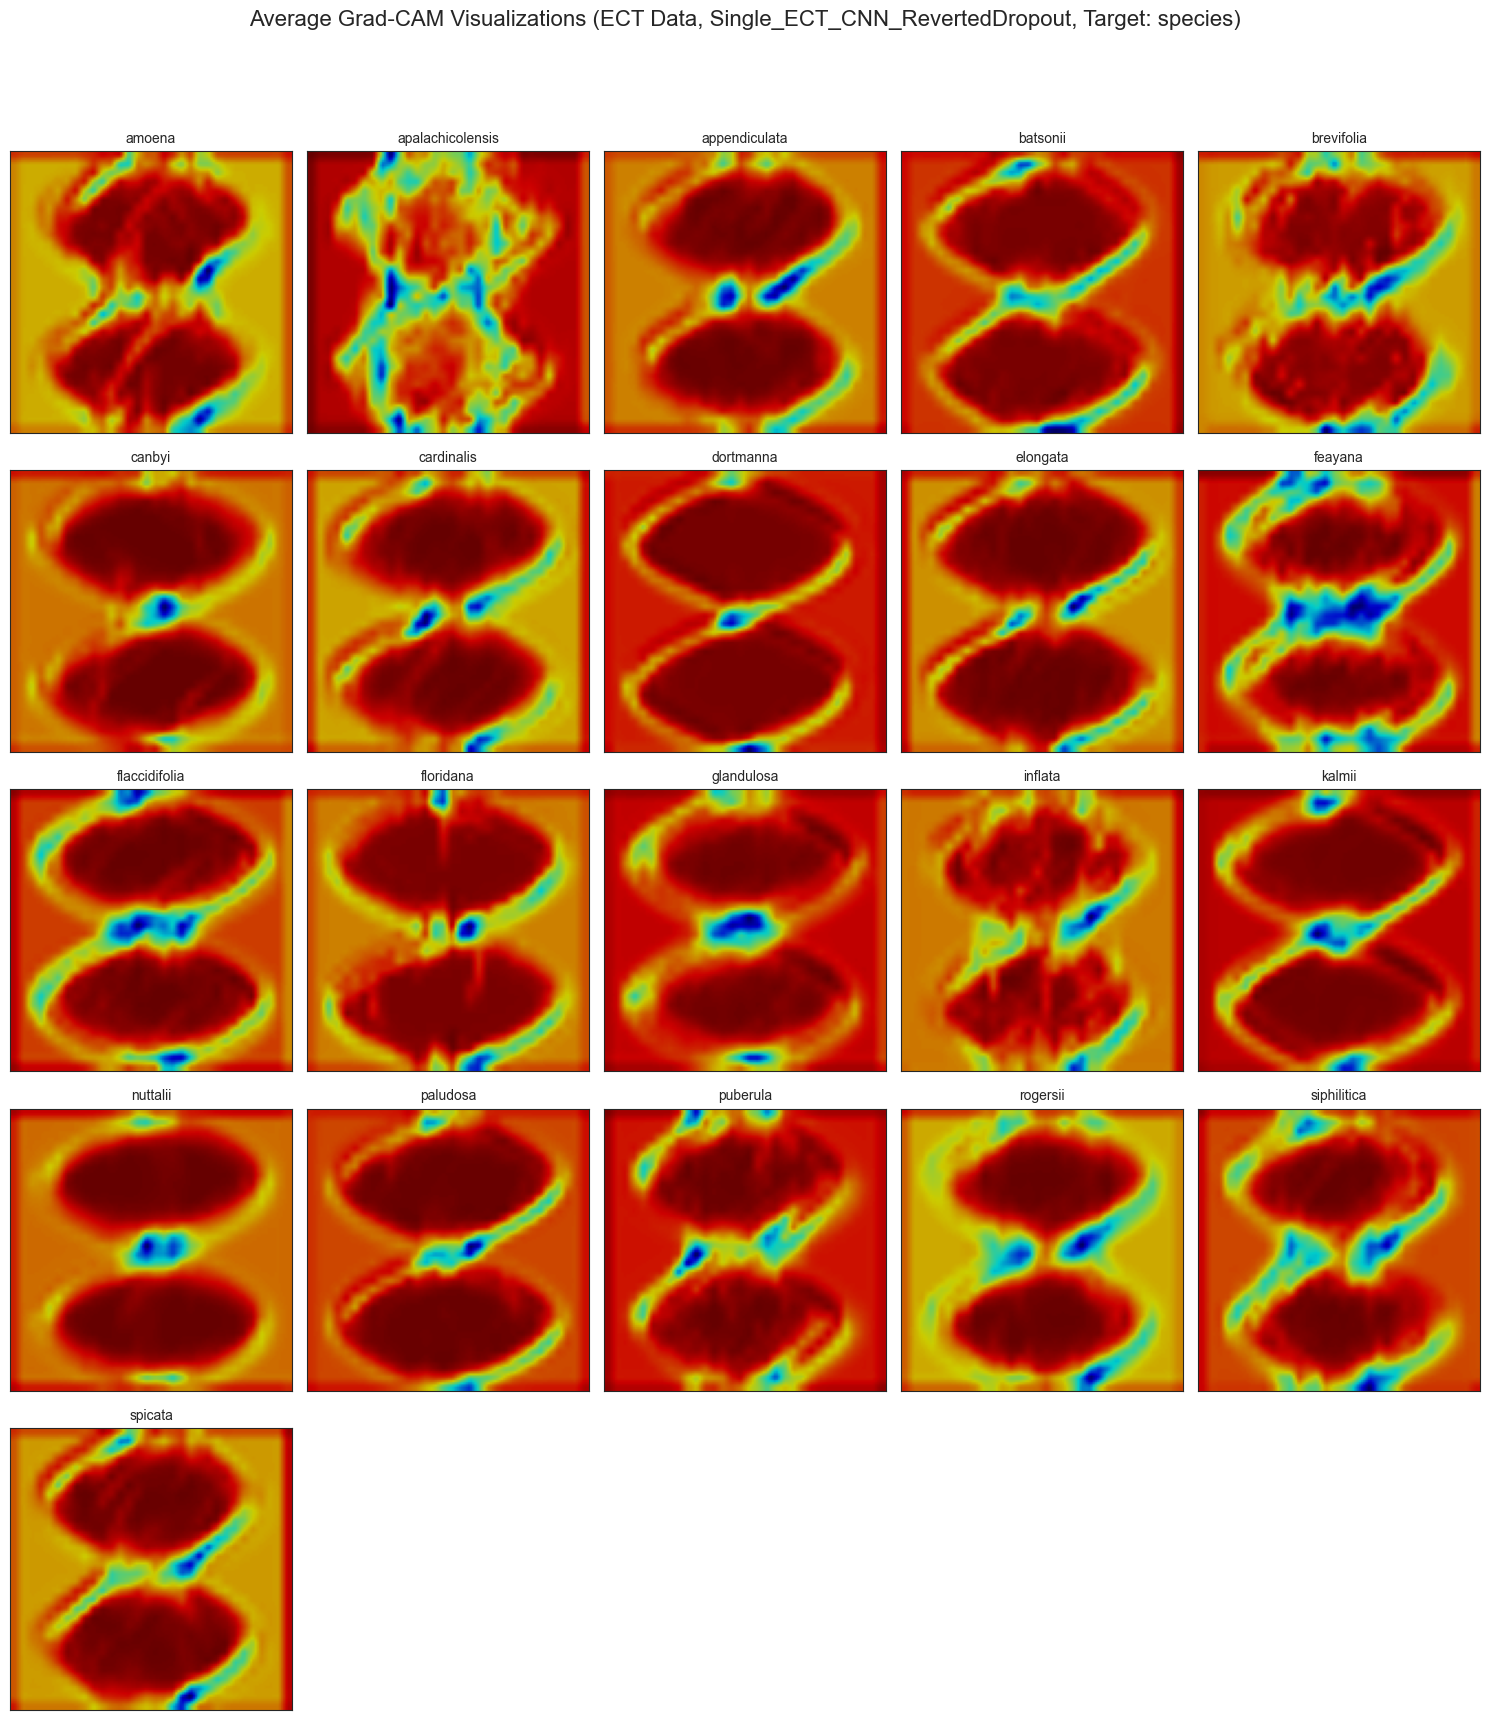

In [83]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import copy # For deepcopying the best model state
import math # For ceil in subplot grid calculation
import os # Ensure os is imported for path handling
import cv2 # For heatmap visualization (requires opencv-python)

# PyTorch Imports
import torch
import torch.nn as tnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- Configuration for CNN Training ---
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
K_FOLDS = 5 # For stratified cross-validation
PATIENCE = 10 # For early stopping
MODEL_IDENTIFIER = 'Single_ECT_CNN_RevertedDropout' # Unique identifier for this ECT model run

# Ensure MPS is available (or use CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load Data from Unified Generation Output ---
try:
    # IMPORTANT: Loading X_ect_images_augmented_shuffled for this model
    X_ect_images_augmented_shuffled = final_data['X_ect_images']
    y_augmented_encoded_shuffled = final_data['y_encoded']
    is_real_flag_augmented_shuffled = final_data['is_real_flag']
    label_encoder = final_data['label_encoder']
    class_names = final_data['class_names']
    num_classes = len(class_names)
    image_size = final_data['image_size']
    original_real_shuffled_logical_indices = final_data['original_real_shuffled_logical_indices']
    target_column_used_for_data = final_data['target_column_used'] # Get the actual target column used

    print(f"\n--- Data Loaded from Unified Generation Block for ECT CNN ---")
    print(f"Loaded ECT image data shape: {X_ect_images_augmented_shuffled.shape}")
    print(f"Number of classes: {num_classes}")
    print(f"Image size: {image_size}x{image_size}")
    print(f"Data was generated using TARGET_COLUMN: '{target_column_used_for_data}'")

except NameError:
    print("Error: 'final_data' dictionary not found. Please run the 'Unified Augmented Data Generation' block first.")
    raise RuntimeError("Required data not found. Please execute the data generation cell.")


# --- PyTorch Data Preparation ---

# Convert to PyTorch Tensors and Normalize ECT Image Data
# ECT Images: Are already (N, C, H, W) and should be float32 (0-1.0 from normalization during generation)
X_ect_images_tensor = torch.from_numpy(X_ect_images_augmented_shuffled).float()
# Labels: Convert to long tensor (for CrossEntropyLoss)
y_encoded_tensor = torch.from_numpy(y_augmented_encoded_shuffled).long()
# is_real_flag: Convert to boolean tensor (for filtering)
is_real_flag_tensor = torch.from_numpy(is_real_flag_augmented_shuffled).bool()

print(f"Tensor ECT image data shape: {X_ect_images_tensor.shape}")


# Create a custom PyTorch Dataset (same as before)
class LeafDataset(Dataset):
    def __init__(self, images, labels, is_real_flags):
        self.images = images
        self.labels = labels
        self.is_real_flags = is_real_flags

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx], self.is_real_flags[idx]


# --- Define PyTorch CNN Model Architecture (MODIFIED for Dropout and Padding) ---
class LeafCNN(tnn.Module):
    def __init__(self, num_classes, image_size):
        super(LeafCNN, self).__init__()
        self.features = tnn.Sequential(
            # Convolutional Layer 1
            tnn.Conv2d(1, 32, kernel_size=3, padding=1), # Input channels is 1 for grayscale ECT images, PADDING=1
            tnn.ReLU(),
            tnn.MaxPool2d(kernel_size=2, stride=2),

            # Convolutional Layer 2
            tnn.Conv2d(32, 64, kernel_size=3, padding=1), # PADDING=1
            tnn.ReLU(),
            tnn.MaxPool2d(kernel_size=2, stride=2),

            # Convolutional Layer 3
            tnn.Conv2d(64, 128, kernel_size=3, padding=1), # PADDING=1
            tnn.ReLU(),
            tnn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Calculate the size of the flattened features dynamically
        with torch.no_grad():
            # Ensure dummy input is on device and move self.features temporarily
            temp_features_model = self.features.to(device)
            dummy_input = torch.zeros(1, 1, image_size, image_size).to(device) # Dummy input for 1 channel
            flattened_size = temp_features_model(dummy_input).view(1, -1).shape[1]
            temp_features_model.to("cpu") # Move model back to CPU after calculation

        self.classifier = tnn.Sequential(
            tnn.Flatten(),
            tnn.Linear(flattened_size, 512), # Changed hidden layer size to 512 to match TwoStreamCNN
            tnn.ReLU(),
            tnn.Dropout(0.5), # This dropout remains, matching TwoStreamCNN's FC layer
            tnn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# --- Model Saving Setup ---
MODEL_SAVE_DIR = "trained_models"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

def save_model_checkpoint(model, optimizer, epoch, accuracy, model_identifier, target_column, fold_idx):
    filepath = os.path.join(MODEL_SAVE_DIR, f"{model_identifier}_fold{fold_idx}_best_{target_column}.pth")
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy,
    }
    torch.save(state, filepath)
    print(f"  --> Saved best model for Fold {fold_idx} (Acc: {accuracy:.4f})")


# --- PyTorch CNN Training and Evaluation with Stratified K-Fold (Evaluate on REAL samples ONLY) ---

print(f"\n--- Performing PyTorch CNN with {K_FOLDS}-Fold Stratified Cross-Validation (ECT Image Data) ---")

# Prepare the 'real' portion of the data for Stratified K-Fold splitting.
real_original_indices_global = torch.where(is_real_flag_tensor)[0].cpu().numpy()

X_original_ect_for_skf = X_ect_images_tensor[real_original_indices_global]
y_original_for_skf = y_encoded_tensor[real_original_indices_global] # These are the encoded (integer) labels for SKF

skf_pytorch = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

all_predictions_logits = [] # Collect logits for ensembling

# List to store file paths of the best model from each fold for potential later use (e.g., Grad-CAM)
saved_model_paths_per_fold = [None] * K_FOLDS # Pre-allocate list to store paths for each fold

for fold_idx, (train_original_real_indices, val_original_real_indices) in enumerate(skf_pytorch.split(X_original_ect_for_skf.cpu().numpy(), y_original_for_skf.cpu().numpy())):
    print(f"\n--- Fold {fold_idx + 1}/{K_FOLDS} ---")

    # --- Prepare Validation Data (ONLY REAL SAMPLES for this fold's validation split) ---
    X_val_ect_fold = X_original_ect_for_skf[val_original_real_indices]
    y_val_fold = y_original_for_skf[val_original_real_indices]
    
    val_dataset = LeafDataset(X_val_ect_fold, y_val_fold, torch.ones_like(y_val_fold, dtype=torch.bool)) # All are 'real' in this validation set
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # --- Prepare Training Data (REAL TRAIN SAMPLES + ALL AUGMENTED SAMPLES) ---
    synthetic_indices = torch.where(~is_real_flag_tensor)[0].cpu().numpy()
    global_real_train_indices = real_original_indices_global[train_original_real_indices]

    all_training_indices_global = np.concatenate((
        global_real_train_indices,
        synthetic_indices
    ))
    
    X_train_ect_fold_tensor = X_ect_images_tensor[all_training_indices_global]
    y_train_fold_tensor = y_encoded_tensor[all_training_indices_global]
    is_real_train_fold_tensor = is_real_flag_tensor[all_training_indices_global]

    train_dataset = LeafDataset(X_train_ect_fold_tensor, y_train_fold_tensor, is_real_train_fold_tensor)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)


    model = LeafCNN(num_classes=num_classes, image_size=image_size).to(device)
    criterion = tnn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict()) # Store best model weights
    best_overall_accuracy_for_saving_this_fold = 0.0 # Track best accuracy for saving this fold

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        for images, labels, _ in train_loader: # _ for is_real_flag (not used in training loss)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        model.eval()
        val_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        current_overall_accuracy_on_real_samples = 0.0 # Initialize for this epoch

        with torch.no_grad():
            for images, labels, _ in val_loader: # _ for is_real_flag (not used in val loss)
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

            avg_train_loss = running_loss / len(train_loader.dataset)
            avg_val_loss = val_loss / len(val_loader.dataset)
            val_accuracy = correct_predictions / total_samples

            current_overall_accuracy_on_real_samples = val_accuracy

            # Less verbose epoch print
            if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == NUM_EPOCHS -1:
                print(f"  Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f} (Real Samples)")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict()) # Save the best model
            epochs_no_improve = 0

            if current_overall_accuracy_on_real_samples > best_overall_accuracy_for_saving_this_fold:
                best_overall_accuracy_for_saving_this_fold = current_overall_accuracy_on_real_samples
                save_model_checkpoint(model, optimizer, epoch, best_overall_accuracy_for_saving_this_fold, MODEL_IDENTIFIER, target_column_used_for_data, fold_idx)
                # Store the path of the BEST model for this fold
                saved_model_paths_per_fold[fold_idx] = os.path.join(MODEL_SAVE_DIR, f"{MODEL_IDENTIFIER}_fold{fold_idx}_best_{target_column_used_for_data}.pth")

        else:
            epochs_no_improve += 1
            if epochs_no_improve == PATIENCE:
                print(f"  Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
                break

    model.load_state_dict(best_model_wts) # Load the best model weights
    print(f"Fold {fold_idx + 1} training complete. Best validation loss: {best_val_loss:.4f}")

    # --- Evaluate Best Model on ALL ORIGINAL REAL SAMPLES for Ensembling ---
    model.eval()
    fold_predictions_logits = []
    
    # Use the full set of original real data for prediction
    X_real_ect_tensor_all = X_original_ect_for_skf
    y_real_labels_all = y_original_for_skf

    real_dataset_for_pred = LeafDataset(X_real_ect_tensor_all, y_real_labels_all, torch.ones_like(y_real_labels_all, dtype=torch.bool))
    real_loader_for_pred = DataLoader(real_dataset_for_pred, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    with torch.no_grad():
        for images_batch, labels_batch, _ in real_loader_for_pred:
            images_batch = images_batch.to(device) # Move to device for inference
            outputs = model(images_batch)
            fold_predictions_logits.append(outputs.cpu().numpy())

    all_predictions_logits.append(np.concatenate(fold_predictions_logits, axis=0))


# --- Final Evaluation on REAL samples Only (using ensemble of fold models) ---

averaged_logits = np.mean(np.array(all_predictions_logits), axis=0)
final_predictions_encoded = np.argmax(averaged_logits, axis=1)

# True labels for the entire original real dataset
final_true_labels_encoded = y_original_for_skf.cpu().numpy()

# Inverse transform to get string names for reporting
final_true_labels_names = label_encoder.inverse_transform(final_true_labels_encoded)
final_predictions_names = label_encoder.inverse_transform(final_predictions_encoded)


overall_accuracy_real_pt_ect = accuracy_score(final_true_labels_names, final_predictions_names)
print(f"\n--- Overall Accuracy (PyTorch CNN on Augmented ECT Image Data, Evaluated on REAL samples ONLY - {target_column_used_for_data}): {overall_accuracy_real_pt_ect:.4f} ---")

print(f"\n--- Classification Report (PyTorch CNN on Augmented ECT Image Data, Evaluated on REAL samples ONLY - {target_column_used_for_data}) ---")
report_dict = classification_report(final_true_labels_names, final_predictions_names, target_names=class_names, zero_division=0, output_dict=True)
print(classification_report(final_true_labels_names, final_predictions_names, target_names=class_names, zero_division=0))

# --- Confusion Matrix Visualization ---
cm_real_pt_ect = confusion_matrix(final_true_labels_names, final_predictions_names, labels=class_names)

plt.figure(figsize=(16, 14))
sns.heatmap(cm_real_pt_ect, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (PyTorch CNN on Augmented ECT Image Data, Evaluated on REAL samples ONLY - {target_column_used_for_data})')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

cm_normalized_real_pt_ect = cm_real_pt_ect.astype('float') / cm_real_pt_ect.sum(axis=1)[:, np.newaxis]
cm_normalized_real_pt_ect[np.isnan(cm_normalized_real_pt_ect)] = 0

plt.figure(figsize=(16, 14))
sns.heatmap(cm_normalized_real_pt_ect, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Normalized Confusion Matrix (PyTorch CNN on Augmented ECT Image Data, Evaluated on REAL samples ONLY - {target_column_used_for_data})')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Store results in results_storage ---
TARGET_COLUMN = target_column_used_for_data # Dynamically set from loaded data
MODEL_NAME = 'Single_ECT_CNN_RevertedDropout' # Distinct name for the single ECT CNN

if 'results_storage' not in globals():
    results_storage = {}
if TARGET_COLUMN not in results_storage: # Should already be initialized, but for robustness
    results_storage[TARGET_COLUMN] = {'class_counts': {}, 'model_metrics': {}}

# Populate class_counts for TARGET_COLUMN in results_storage (if not already populated)
if not results_storage[TARGET_COLUMN]['class_counts']:
    class_counts_series = pd.Series(y_original_for_skf.cpu().numpy()).value_counts().sort_index()
    for encoded_label, count in class_counts_series.items():
        class_name = label_encoder.inverse_transform([encoded_label])[0]
        results_storage[TARGET_COLUMN]['class_counts'][class_name] = count
    print(f"Class counts populated for '{TARGET_COLUMN}'.")

# Populate model_metrics for the current run
results_storage[TARGET_COLUMN]['model_metrics'][MODEL_NAME] = {
    'precision': {cls: report_dict[cls]['precision'] for cls in class_names},
    'recall': {cls: report_dict[cls]['recall'] for cls in class_names}
}
print(f"Metrics for '{MODEL_NAME}' stored in results_storage for '{TARGET_COLUMN}'.")

print("\n--- Current contents of results_storage (should include new model metrics) ---")
print(results_storage)


# --- Grad-CAM Visualization: Average Heatmap per Class for ECT Data ---

print(f"\n--- Generating Average Grad-CAM Visualizations for {MODEL_IDENTIFIER} (Model from Fold 0) on ECT Data ---")

# Choose which saved model to load for Grad-CAM.
if len(saved_model_paths_per_fold) <= 0 or saved_model_paths_per_fold[0] is None or not os.path.exists(saved_model_paths_per_fold[0]):
    print(f"Error: Model file for Fold 0 not found or not saved at {saved_model_paths_per_fold[0] if len(saved_model_paths_per_fold) > 0 else 'N/A'}. Skipping Grad-CAM visualization for ECT.")
else:
    model_to_visualize_path = saved_model_paths_per_fold[0]

    cam_model = LeafCNN(num_classes=num_classes, image_size=image_size).to(device)
    checkpoint = torch.load(model_to_visualize_path, map_location=device)
    cam_model.load_state_dict(checkpoint['model_state_dict'])
    cam_model.eval()

    target_layer = cam_model.features[-3] # Last Conv2d layer in `self.features` sequential.


    class GradCAM:
        def __init__(self, model, target_layer):
            self.model = model
            self.target_layer = target_layer
            self.gradients = None
            self.activations = None

            found_layer = False
            for name, module in self.model.named_modules():
                if module is self.target_layer:
                    module.register_forward_hook(self._save_activation)
                    module.register_backward_hook(self._save_gradient)
                    found_layer = True
                    break
            if not found_layer:
                raise ValueError(f"Target layer {target_layer} not found in model named modules.")


        def _save_activation(self, module, input, output):
            self.activations = output

        def _save_gradient(self, module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def __call__(self, input_tensor, target_class=None):
            self.model.zero_grad()
            output = self.model(input_tensor)
            
            if target_class is None:
                target_class = output.argmax(dim=1).item()

            one_hot = torch.zeros_like(output).to(device)
            one_hot[0][target_class] = 1
            output.backward(gradient=one_hot, retain_graph=True)

            gradients = self.gradients[0].cpu().data.numpy()
            activations = self.activations[0].cpu().data.numpy()

            weights = np.mean(gradients, axis=(1, 2))
            cam = np.zeros(activations.shape[1:], dtype=np.float32)

            for i, w in enumerate(weights):
                cam += w * activations[i]

            cam = np.maximum(cam, 0)
            cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))
            return cam

    # --- show_cam_on_black_background for ECT heatmaps ---
    def show_cam_on_black_background(cam_heatmap, img_size):
        # cam_heatmap: numpy array (H, W) normalized 0-1
        # img_size: size of the original image (e.g., 64)
        
        black_background = np.zeros((img_size, img_size, 3), dtype=np.uint8)

        heatmap_colored = cv2.applyColorMap(np.uint8(255 * cam_heatmap), cv2.COLORMAP_JET)
        heatmap_colored = np.float32(heatmap_colored) / 255

        alpha = 0.8 # Controls the intensity/opacity of the heatmap.
        final_cam_img = np.uint8(255 * (heatmap_colored * alpha + np.float32(black_background) / 255 * (1-alpha)))

        return final_cam_img


    # --- Calculate Average Grad-CAM for Each Class (ECT Data) ---
    grad_cam = GradCAM(cam_model, target_layer)
    average_class_heatmaps = {}

    # Need indices of real ECT images, which corresponds to original_real_shuffled_logical_indices
    # X_original_ect_for_skf contains ONLY the real samples, in the original order they appeared in final_data['X_ect_images']
    # y_original_for_skf contains their corresponding labels.
    
    # Map global real indices to indices within X_original_ect_for_skf
    # This requires recreating a mapping or simply iterating over X_original_ect_for_skf directly.
    # Let's iterate directly over X_original_ect_for_skf for simplicity, as it contains all real samples.
    
    real_ect_indices_by_class = {cls_idx: [] for cls_idx in range(num_classes)}
    for i in range(len(X_original_ect_for_skf)):
        class_label = y_original_for_skf[i].item() # Label for this ECT image
        real_ect_indices_by_class[class_label].append(i) # Store index within X_original_ect_for_skf

    print("Calculating average Grad-CAM heatmaps per class for ECT data...")
    for class_idx in range(num_classes):
        class_name = class_names[class_idx]
        # These are indices within X_original_ect_for_skf and y_original_for_skf
        class_samples_ect_indices = real_ect_indices_by_class[class_idx]

        if not class_samples_ect_indices:
            print(f"  No real ECT samples for class '{class_name}'. Skipping average Grad-CAM.")
            average_class_heatmaps[class_idx] = None
            continue

        summed_heatmap = np.zeros((image_size, image_size), dtype=np.float32)
        count_for_average = 0

        for sample_internal_idx in class_samples_ect_indices:
            image_tensor = X_original_ect_for_skf[sample_internal_idx] # Get ECT image tensor
            input_image_for_cam = image_tensor.unsqueeze(0).to(device)

            heatmap = grad_cam(input_image_for_cam, target_class=class_idx)
            
            summed_heatmap += heatmap
            count_for_average += 1
        
        if count_for_average > 0:
            avg_heatmap = summed_heatmap / count_for_average
            avg_heatmap = avg_heatmap - np.min(avg_heatmap)
            if np.max(avg_heatmap) == 0:
                avg_heatmap = np.zeros_like(avg_heatmap)
            else:
                avg_heatmap = avg_heatmap / np.max(avg_heatmap)
            average_class_heatmaps[class_idx] = avg_heatmap
            print(f"  Calculated average for class: '{class_name}' ({count_for_average} samples)")
        else:
            average_class_heatmaps[class_idx] = None


    # --- Plotting Average Grad-CAMs in a Grid ---

    num_plots_total = num_classes
    num_cols_grid = math.ceil(math.sqrt(num_plots_total))
    num_rows_grid = math.ceil(num_plots_total / num_cols_grid)

    fig_width = num_cols_grid * 3.0
    fig_height = num_rows_grid * 3.5

    sns.set_style("white")
    plt.rcParams.update({'font.size': 10})

    fig, axes = plt.subplots(num_rows_grid, num_cols_grid, figsize=(fig_width, fig_height), squeeze=False)
    axes = axes.flatten()

    print(f"\nPlotting average Grad-CAMs in a {num_rows_grid}x{num_cols_grid} grid for ECT data...")

    for i in range(num_classes):
        ax = axes[i]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(class_names[i], fontsize=10)

        avg_heatmap = average_class_heatmaps[i]
        if avg_heatmap is not None:
            cam_image_on_black = show_cam_on_black_background(avg_heatmap, image_size)
            ax.imshow(cam_image_on_black)
        else:
            ax.text(0.5, 0.5, 'No Samples', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='gray', fontsize=10)


    for j in range(num_classes, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'Average Grad-CAM Visualizations (ECT Data, {MODEL_IDENTIFIER}, Target: {target_column_used_for_data})', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig(os.path.join(MODEL_SAVE_DIR, f"{MODEL_IDENTIFIER}_AverageGradCAM_ECT_{target_column_used_for_data}.png"), dpi=300)
    plt.show()

## Two stream CNN

Global TARGET_COLUMN for this session: 'species'
Using device: mps

--- Data Loaded from Unified Generation Block for Two-Stream CNN ---
Loaded image data shape: (11424, 128, 128, 1)
Loaded ECT image data shape: (11424, 1, 128, 128)
Number of classes: 21
Image size: 128x128
Number of original (real) samples: 4081
Data was generated using TARGET_COLUMN: 'species'
Tensor image data shape (after permute): torch.Size([11424, 1, 128, 128])
Tensor ECT image data shape: torch.Size([11424, 1, 128, 128])
--- Performing PyTorch Two-Stream CNN with 5-Fold Stratified Cross-Validation on Combined Data (Evaluating on REAL samples) ---

--- Fold 1/5 ---
DEBUG (Model Init): Flattened size of Image Stream: 32768
DEBUG (Model Init): Flattened size of ECT Stream: 32768
DEBUG (Model Init): Total Flattened Size for FC Layer: 65536
Epoch 1/50, Train Loss: 2.5023, Val Loss: 2.2350, Val Acc: 0.2717
Epoch 2/50, Train Loss: 1.9673, Val Loss: 2.0774, Val Acc: 0.3084
Epoch 3/50, Train Loss: 1.6356, Val Loss: 1.86

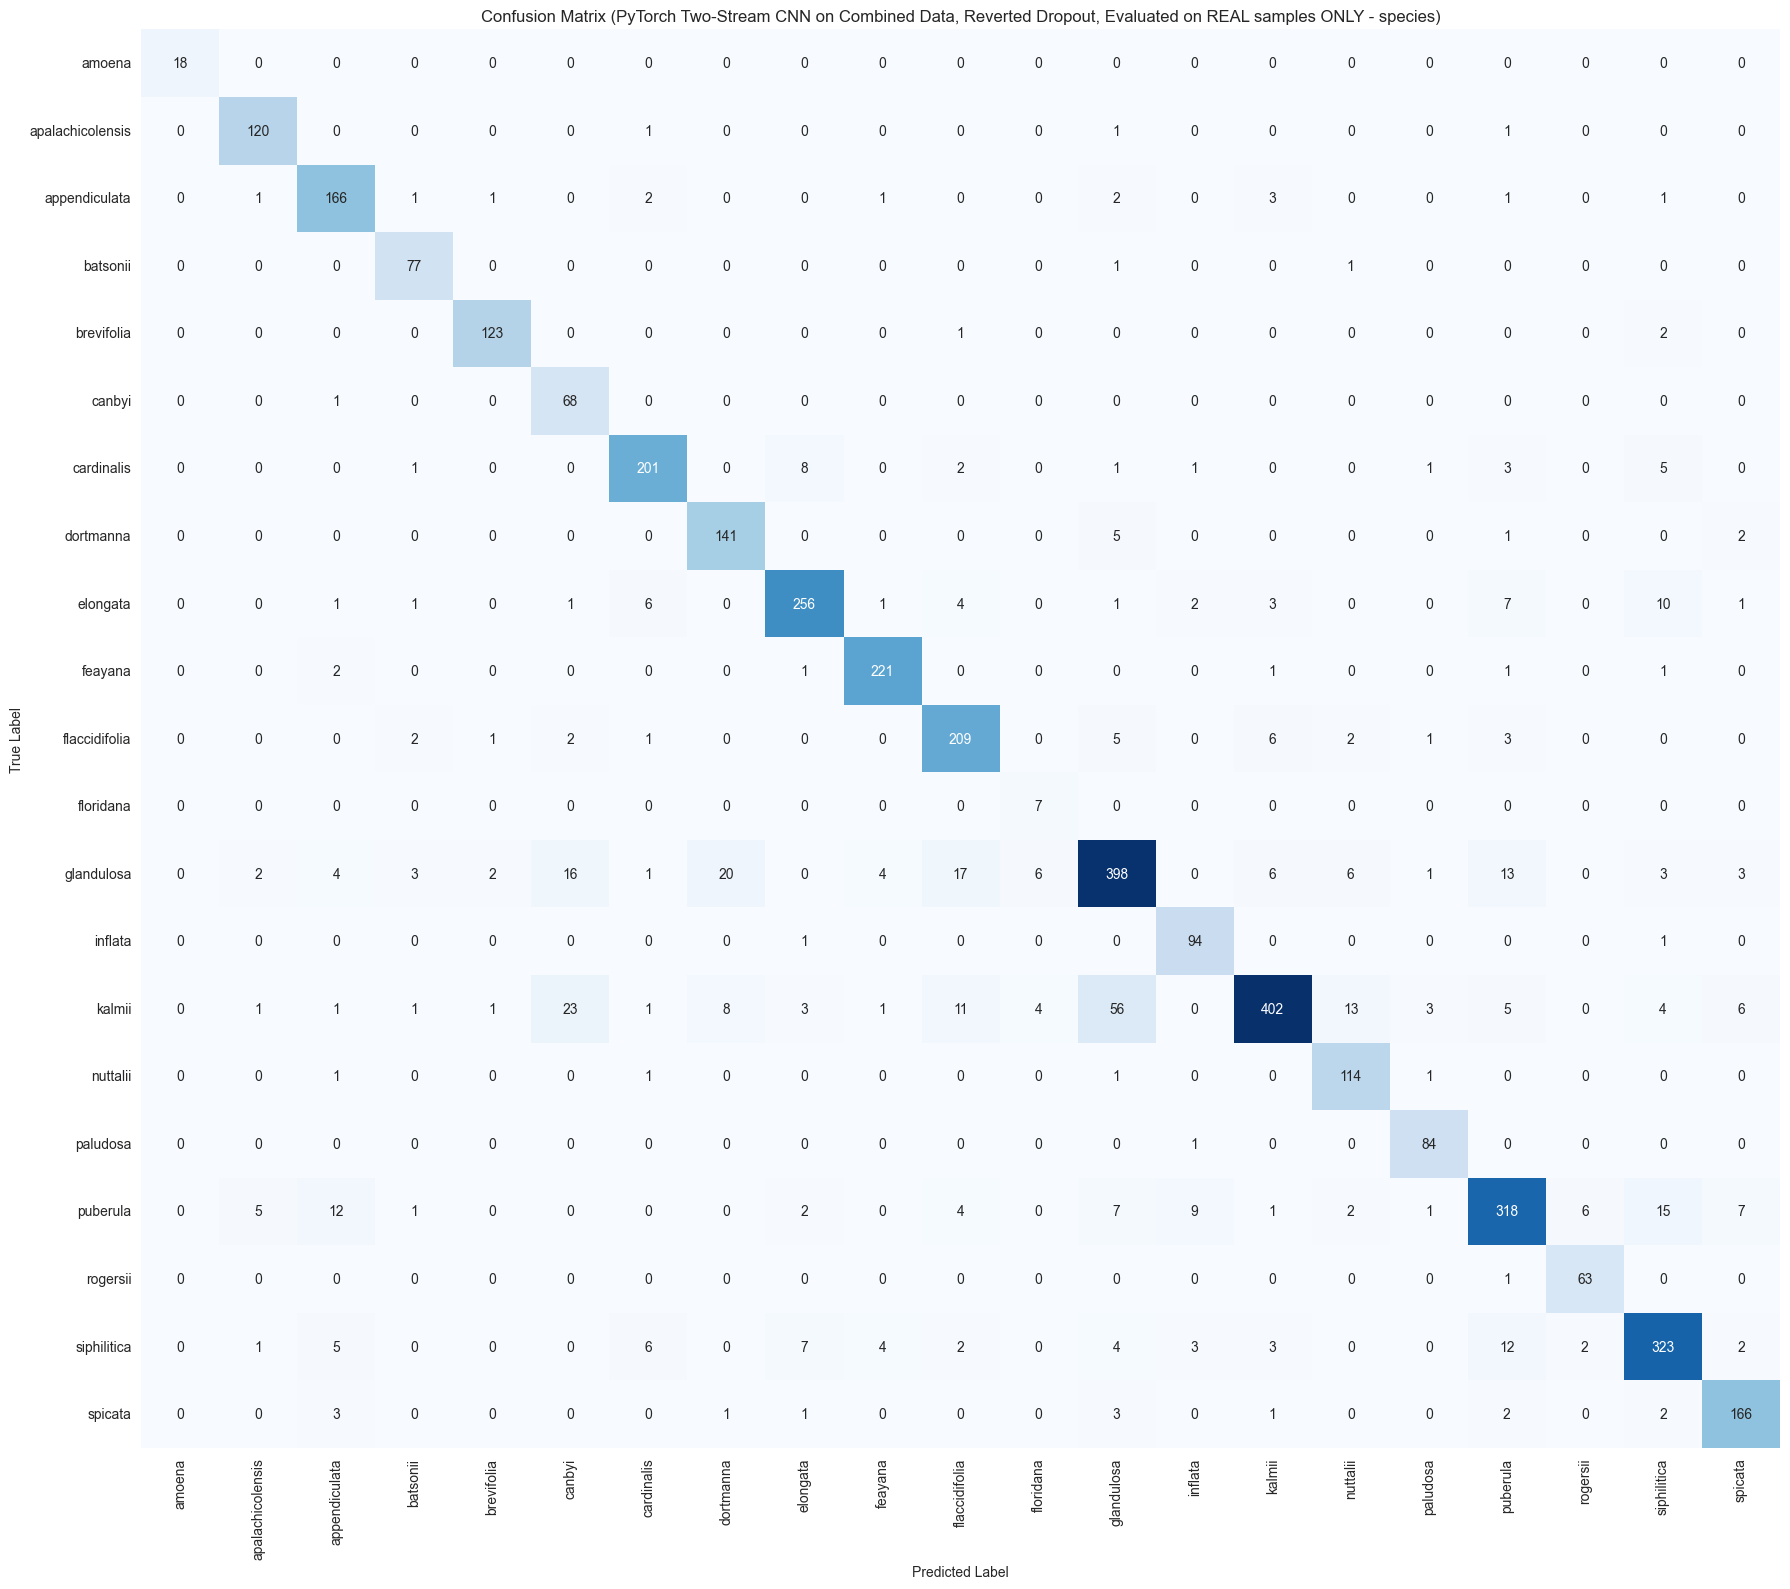

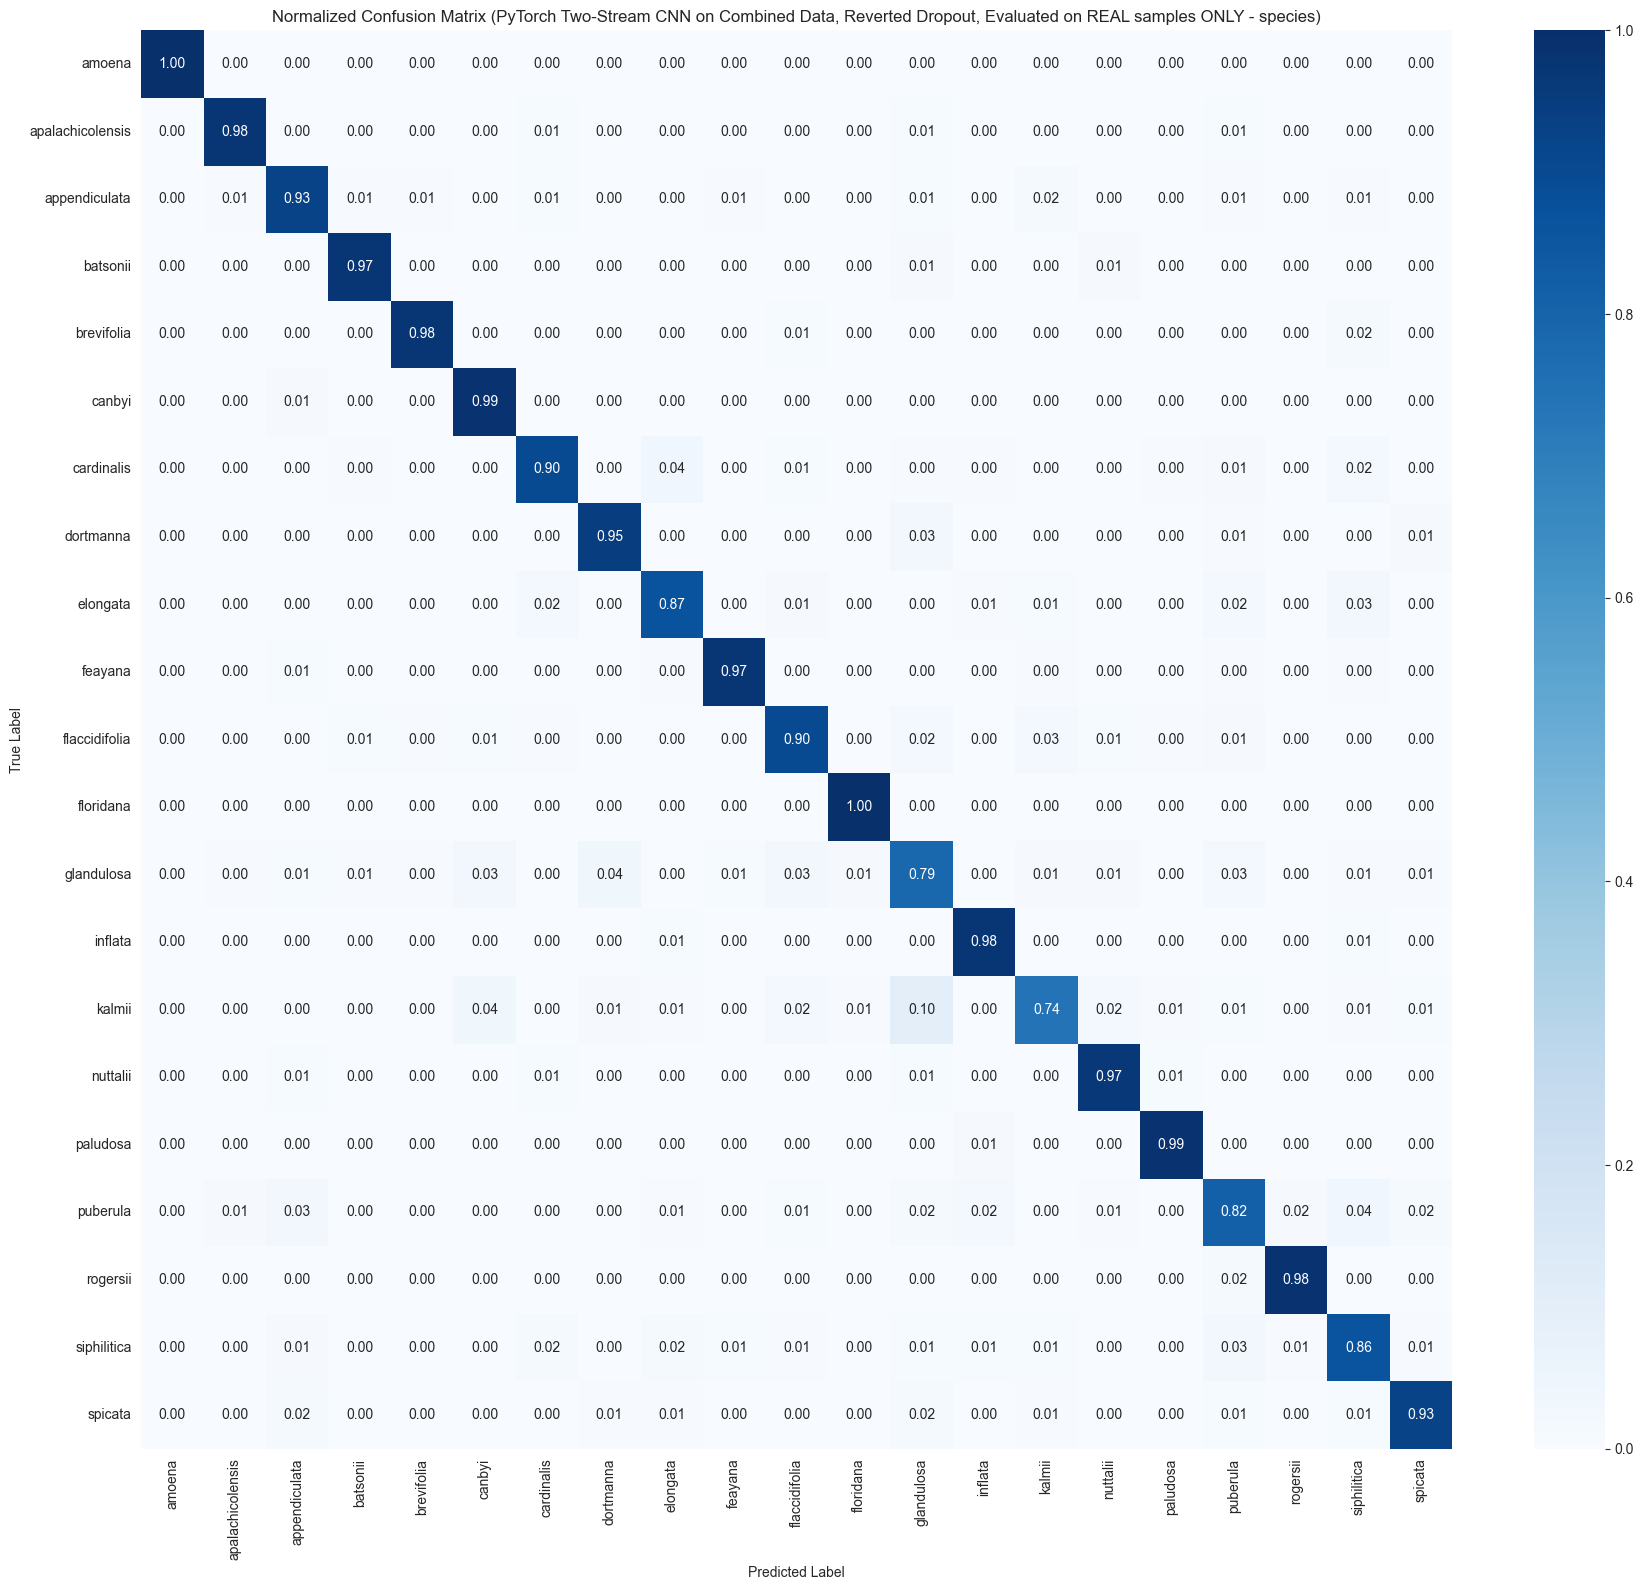


--- Current contents of results_storage (should include new model metrics) ---
{'species': {'class_counts': {'amoena': 18, 'apalachicolensis': 123, 'appendiculata': 179, 'batsonii': 79, 'brevifolia': 126, 'canbyi': 69, 'cardinalis': 223, 'dortmanna': 149, 'elongata': 294, 'feayana': 227, 'flaccidifolia': 232, 'floridana': 7, 'glandulosa': 505, 'inflata': 96, 'kalmii': 544, 'nuttalii': 118, 'paludosa': 85, 'puberula': 390, 'rogersii': 64, 'siphilitica': 374, 'spicata': 179}, 'model_metrics': {'unbalanced_lda': {'precision': {'amoena': 0.0, 'apalachicolensis': 0.15584415584415584, 'appendiculata': 0.2028985507246377, 'batsonii': 0.03571428571428571, 'brevifolia': 0.3793103448275862, 'canbyi': 0.22784810126582278, 'cardinalis': 0.305, 'dortmanna': 0.21359223300970873, 'elongata': 0.334384858044164, 'feayana': 0.3544973544973545, 'flaccidifolia': 0.12380952380952381, 'floridana': 0.0, 'glandulosa': 0.37590711175616837, 'inflata': 0.09259259259259259, 'kalmii': 0.36702767749699156, 'nuttal

In [84]:
# ======================================================================
# MASTER CONFIGURATION FOR THE ENTIRE NOTEBOOK SESSION
# SET THIS ONCE AT THE VERY BEGINNING!
# ======================================================================
TARGET_COLUMN = 'species' # <--- Ensure this matches the target you set in the generation step!
# ======================================================================

# Initialize this dictionary ONCE at the start of your notebook session
# This ensures it's available for storing results from different models
if 'results_storage' not in globals():
    results_storage = {}
if TARGET_COLUMN not in results_storage:
    results_storage[TARGET_COLUMN] = {
        'class_counts': {},
        'model_metrics': {} # This will store precision/recall for each model
    }
print(f"Global TARGET_COLUMN for this session: '{TARGET_COLUMN}'")


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset # Added Dataset import
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import copy # For deepcopying the best model state

# Set a global random seed for all operations where possible
np.random.seed(42)
torch.manual_seed(42)

# --- Configuration for CNN Training ---
BATCH_SIZE = 32
NUM_EPOCHS = 50 # Maximum epochs, early stopping will likely halt sooner
LEARNING_RATE = 0.001
K_FOLDS = 5
RANDOM_STATE = 42 # For reproducibility of splits and augmentations
PATIENCE = 10 # For early stopping


# --- Device Setup ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: mps")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using device: cpu")

# --- Load Data from Unified Generation Output ---
# This script ASSUMES the 'Unified Augmented Data Generation' block has been run
# and 'final_data' dictionary is available in the global scope.
try:
    X_images_augmented_shuffled = final_data['X_images']
    X_ect_images_augmented_shuffled = final_data['X_ect_images'] # Load pre-generated ECT images
    y_augmented_encoded_shuffled = final_data['y_encoded']
    is_real_flag_augmented_shuffled = final_data['is_real_flag'] # Keep real/synthetic flag
    label_encoder = final_data['label_encoder']
    class_names = final_data['class_names']
    num_classes = len(class_names)
    image_size = final_data['image_size']
    num_original_samples = final_data['num_original_samples'] # Get the count of real samples

    print(f"\n--- Data Loaded from Unified Generation Block for Two-Stream CNN ---")
    print(f"Loaded image data shape: {X_images_augmented_shuffled.shape}")
    print(f"Loaded ECT image data shape: {X_ect_images_augmented_shuffled.shape}")
    print(f"Number of classes: {num_classes}")
    print(f"Image size: {image_size}x{image_size}")
    print(f"Number of original (real) samples: {num_original_samples}")
    print(f"Data was generated using TARGET_COLUMN: '{final_data['target_column_used']}'")

except NameError:
    print("Error: 'final_data' dictionary not found. Please run the 'Unified Augmented Data Generation' block first.")
    raise RuntimeError("Required data not found. Please execute the data generation cell.")


# --- PyTorch Data Preparation ---

# Convert to PyTorch Tensors and Normalize Image Data
# Images: Convert to float32, PERMUTE dimensions for PyTorch (N, C, H, W), then normalize (0-255 to 0.0-1.0)
X_images_tensor = torch.from_numpy(X_images_augmented_shuffled).float().permute(0, 3, 1, 2) / 255.0
# ECT Images: Are already (N, C, H, W) and should be float32 (0-1.0 from normalization during generation)
X_ect_images_tensor = torch.from_numpy(X_ect_images_augmented_shuffled).float()
# Labels: Convert to long tensor (for CrossEntropyLoss)
y_encoded_tensor = torch.from_numpy(y_augmented_encoded_shuffled).long()
# is_real_flag: Convert to boolean tensor (for filtering)
is_real_flag_tensor = torch.from_numpy(is_real_flag_augmented_shuffled).bool()


print(f"Tensor image data shape (after permute): {X_images_tensor.shape}")
print(f"Tensor ECT image data shape: {X_ect_images_tensor.shape}")


# Create a custom PyTorch Dataset for two inputs
class TwoStreamDataset(Dataset):
    def __init__(self, images, ect_images, labels, is_real_flags):
        self.images = images
        self.ect_images = ect_images
        self.labels = labels
        self.is_real_flags = is_real_flags

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.ect_images[idx], self.labels[idx], self.is_real_flags[idx]


# --- PyTorch Two-Stream CNN Model Definition (MODIFIED for REVERTED DROPOUT) ---
class TwoStreamCNN(nn.Module):
    def __init__(self, num_classes, image_size, img_channels=1, ect_channels=1):
        super(TwoStreamCNN, self).__init__()

        # Stream for Original Images
        self.image_stream = nn.Sequential(
            nn.Conv2d(img_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(0.25), # REMOVED DROPOUT

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(0.25), # REMOVED DROPOUT

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(0.25) # REMOVED DROPOUT
        )

        # Stream for ECT Images
        self.ect_stream = nn.Sequential(
            nn.Conv2d(ect_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(0.25), # REMOVED DROPOUT

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(0.25), # REMOVED DROPOUT

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(0.25) # REMOVED DROPOUT
        )

        # Calculate input features for the linear layer dynamically
        with torch.no_grad():
            # Create dummy inputs on the correct device (important for module initialization)
            temp_image_stream = self.image_stream.to(device)
            temp_ect_stream = self.ect_stream.to(device)

            dummy_input_img = torch.zeros(1, img_channels, image_size, image_size).to(device)
            dummy_input_ect = torch.zeros(1, ect_channels, image_size, image_size).to(device)
            
            flattened_size_img = temp_image_stream(dummy_input_img).view(1, -1).shape[1]
            flattened_size_ect = temp_ect_stream(dummy_input_ect).view(1, -1).shape[1]

            total_flattened_size = flattened_size_img + flattened_size_ect

            print(f"DEBUG (Model Init): Flattened size of Image Stream: {flattened_size_img}")
            print(f"DEBUG (Model Init): Flattened size of ECT Stream: {flattened_size_ect}")
            print(f"DEBUG (Model Init): Total Flattened Size for FC Layer: {total_flattened_size}")

        self.fc_layers = nn.Sequential(
            nn.Linear(total_flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5), # <-- This dropout remains as in the PREVIOUS model
            nn.Linear(512, num_classes)
        )

    def forward(self, img_input, ect_input):
        img_features = self.image_stream(img_input)
        ect_features = self.ect_stream(ect_input)

        img_features = img_features.view(img_features.size(0), -1)
        ect_features = ect_features.view(ect_features.size(0), -1)

        # Concatenate features from both streams
        combined_features = torch.cat((img_features, ect_features), dim=1)

        output = self.fc_layers(combined_features)
        return output

# --- 5-Fold Stratified Cross-Validation (Evaluating on REAL samples Only) ---
print(f"--- Performing PyTorch Two-Stream CNN with {K_FOLDS}-Fold Stratified Cross-Validation on Combined Data (Evaluating on REAL samples) ---")

# Populate class_counts for TARGET_COLUMN in results_storage (if not already populated)
if not results_storage[TARGET_COLUMN]['class_counts']:
    class_counts_series = pd.Series(y_encoded_tensor[is_real_flag_tensor].cpu().numpy()).value_counts().sort_index()
    for encoded_label, count in class_counts_series.items():
        class_name = label_encoder.inverse_transform([encoded_label])[0]
        results_storage[TARGET_COLUMN]['class_counts'][class_name] = count
    print(f"Class counts populated for '{TARGET_COLUMN}'.")

# Prepare the 'real' portion of the data for Stratified K-Fold splitting.
real_original_indices = torch.where(is_real_flag_tensor)[0].cpu().numpy()

X_original_images_for_skf = X_images_tensor[real_original_indices]
X_original_ect_for_skf = X_ect_images_tensor[real_original_indices]
y_original_for_skf = y_encoded_tensor[real_original_indices] # These are the encoded (integer) labels for SKF

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

all_predictions_logits = []
all_true_labels_real_validation = [] # To collect all true labels across folds for final report

for fold_idx, (train_original_real_indices, val_original_real_indices) in enumerate(skf.split(X_original_images_for_skf.cpu().numpy(), y_original_for_skf.cpu().numpy())):
    print(f"\n--- Fold {fold_idx + 1}/{K_FOLDS} ---")

    # --- Prepare Validation Data (ONLY REAL SAMPLES for this fold's validation split) ---
    X_val_img_fold = X_original_images_for_skf[val_original_real_indices]
    X_val_ect_fold = X_original_ect_for_skf[val_original_real_indices]
    y_val_fold = y_original_for_skf[val_original_real_indices]
    
    val_dataset = TwoStreamDataset(X_val_img_fold, X_val_ect_fold, y_val_fold, torch.ones_like(y_val_fold, dtype=torch.bool)) # All are 'real' in this validation set
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # --- Prepare Training Data (REAL TRAIN SAMPLES + ALL AUGMENTED SAMPLES) ---
    synthetic_indices = torch.where(~is_real_flag_tensor)[0].cpu().numpy()
    global_real_train_indices = real_original_indices[train_original_real_indices]

    all_training_indices_global = np.concatenate((
        global_real_train_indices,
        synthetic_indices
    ))
    
    X_train_img_fold_tensor = X_images_tensor[all_training_indices_global]
    X_train_ect_fold_tensor = X_ect_images_tensor[all_training_indices_global]
    y_train_fold_tensor = y_encoded_tensor[all_training_indices_global]
    is_real_train_fold_tensor = is_real_flag_tensor[all_training_indices_global]

    train_dataset = TwoStreamDataset(X_train_img_fold_tensor, X_train_ect_fold_tensor, y_train_fold_tensor, is_real_train_fold_tensor)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


    # --- Model Initialization and Training Loop ---
    model = TwoStreamCNN(num_classes=num_classes, image_size=image_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0.0
        for img_inputs, ect_inputs, labels, _ in train_loader: # _ for is_real_flag (not used in training loss)
            img_inputs, ect_inputs, labels = img_inputs.to(device), ect_inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(img_inputs, ect_inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * img_inputs.size(0)

        train_loss /= len(train_dataset)

        model.eval()
        val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for img_inputs, ect_inputs, labels, _ in val_loader: # _ for is_real_flag
                img_inputs, ect_inputs, labels = img_inputs.to(device), ect_inputs.to(device), labels.to(device)
                outputs = model(img_inputs, ect_inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * img_inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        val_loss /= len(val_dataset)
        val_accuracy = correct_predictions / total_predictions

        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == PATIENCE: # Early stopping patience
                print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
                break

    model.load_state_dict(best_model_wts)
    print(f"Fold {fold_idx + 1} training complete. Best validation loss: {best_val_loss:.4f}")

    # --- Evaluate Best Model on ALL ORIGINAL REAL SAMPLES for Ensembling ---
    # We predict on the *entire* set of original real samples in each fold's best model,
    # then average these predictions at the end for final evaluation.
    model.eval()
    fold_predictions_logits = []

    X_real_img_tensor_all = X_original_images_for_skf.to(device)
    X_real_ect_tensor_all = X_original_ect_for_skf.to(device)
    y_real_labels_all = y_original_for_skf.to(device) # Keep true labels here for consistency with all_true_labels_real_validation

    real_dataset_for_pred = TwoStreamDataset(X_real_img_tensor_all, X_real_ect_tensor_all, y_real_labels_all, torch.ones_like(y_real_labels_all, dtype=torch.bool))
    real_loader_for_pred = DataLoader(real_dataset_for_pred, batch_size=BATCH_SIZE, shuffle=False)

    with torch.no_grad():
        for img_inputs, ect_inputs, labels_true, _ in real_loader_for_pred:
            outputs = model(img_inputs, ect_inputs)
            fold_predictions_logits.append(outputs.cpu().numpy())
            # Collect true labels for the entire real dataset
            all_true_labels_real_validation.append(labels_true.cpu().numpy())

    all_predictions_logits.append(np.concatenate(fold_predictions_logits, axis=0))

# --- Final Evaluation on REAL samples Only (using ensemble of fold models) ---

# Average the logits from all folds for each sample
averaged_logits = np.mean(np.array(all_predictions_logits), axis=0)
final_predictions_encoded = np.argmax(averaged_logits, axis=1)

# True labels for the entire original real dataset (make sure it's flattened and consistent)
# Need to concatenate all_true_labels_real_validation only once to avoid duplication
# Ensure it only stores each real sample's true label ONCE
# Since skf.split processes the *same* X_original_images_for_skf each time,
# and we're predicting on *all* X_original_images_for_skf, y_original_for_skf is the correct full set.
final_true_labels_encoded = y_original_for_skf.cpu().numpy()


# Inverse transform to get string names for reporting
final_true_labels_names = label_encoder.inverse_transform(final_true_labels_encoded)
final_predictions_names = label_encoder.inverse_transform(final_predictions_encoded)

overall_accuracy = accuracy_score(final_true_labels_names, final_predictions_names)
print(f"\n--- Overall Accuracy (PyTorch Two-Stream CNN on Combined Data, Evaluated on REAL samples ONLY - {TARGET_COLUMN}): {overall_accuracy:.4f} ---")

print(f"\n--- Classification Report (PyTorch Two-Stream CNN on Combined Data, Evaluated on REAL samples ONLY - {TARGET_COLUMN}) ---")
report = classification_report(final_true_labels_names, final_predictions_names, target_names=list(label_encoder.classes_), zero_division=0, output_dict=True)
print(classification_report(final_true_labels_names, final_predictions_names, target_names=list(label_encoder.classes_), zero_division=0))

# --- Store results in results_storage ---
MODEL_NAME = 'Two_Stream_CNN_RevertedDropout' # Giving it a distinct name for plotting comparison
if TARGET_COLUMN not in results_storage: # Should already be initialized, but for robustness
    results_storage[TARGET_COLUMN] = {'class_counts': {}, 'model_metrics': {}}

# Populate model_metrics for the current run
results_storage[TARGET_COLUMN]['model_metrics'][MODEL_NAME] = {
    'precision': {cls: report[cls]['precision'] for cls in label_encoder.classes_},
    'recall': {cls: report[cls]['recall'] for cls in label_encoder.classes_}
}
print(f"Metrics for '{MODEL_NAME}' stored in results_storage for '{TARGET_COLUMN}'.")


# --- Confusion Matrix Visualization (Raw Counts) ---
cm_real_pt = confusion_matrix(final_true_labels_names, final_predictions_names, labels=label_encoder.classes_)

plt.figure(figsize=(18, 16))
sns.heatmap(cm_real_pt, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (PyTorch Two-Stream CNN on Combined Data, Reverted Dropout, Evaluated on REAL samples ONLY - {TARGET_COLUMN})')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Confusion Matrix Visualization (Normalized) ---
cm_normalized_real_pt = cm_real_pt.astype('float') / cm_real_pt.sum(axis=1)[:, np.newaxis]
cm_normalized_real_pt[np.isnan(cm_normalized_real_pt)] = 0 # Handle cases where a class has no true samples

plt.figure(figsize=(18, 16))
sns.heatmap(cm_normalized_real_pt, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Normalized Confusion Matrix (PyTorch Two-Stream CNN on Combined Data, Reverted Dropout, Evaluated on REAL samples ONLY - {TARGET_COLUMN})')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n--- Current contents of results_storage (should include new model metrics) ---")
print(results_storage)